# Notebook 30: CO Core Mass

In this notebook we hope to find out CHE is efficient at producing a pile-up of $35\,\mathrm{M}_\odot$ BHs under some particular setting for our wind model.

In [1]:
# nb_id is used to identify this notebook's output files (i.e., figures) if there are any
# it should match the first two digits in the notebook's title
nb_id = 30

## Imports

In [2]:
from pathlib import Path
from math import isnan

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

import astropy.units as u
import astropy.constants as ct
from scipy.signal import find_peaks

import mesa_reader as mr
import mesaPlot as mp
import tulips as tp

import sys
sys.path.append('..')
from src.star import fix_unit, eggleton_rl1_radius, a_from_p, p_from_a, marchant_l2_radius

/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <

In [3]:
CODE_ROOT = Path('/mnt/home/ldesa/repos/cher')
DATA_ROOT = Path('/mnt/ceph/users/ldesa/mesa_che_grids')

In [4]:
PROJECT_FOLDER = DATA_ROOT/'sse_carbon'
FIGURE_FOLDER = Path(f'./output/nb{nb_id}/figures')
FIGURE_FOLDER.mkdir(parents=True, exist_ok=True)

In [5]:
plt.style.use('./plotstyle.mplstyle')

## Definitions

### Constants

In [6]:
ZSUN = 0.014

### Utilities

In [7]:
def savefig(fig, fname):
    """Saves png, pdf and eps figure files to a nb-specific folder."""
    fname = f'nb{nb_id}_{fname}'
    plt.savefig(FIGURE_FOLDER/(fname+'.png'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.pdf'), bbox_inches='tight')
    plt.savefig(FIGURE_FOLDER/(fname+'.eps'), bbox_inches='tight')

In [8]:
def normarr(arr):
    return (arr-min(arr))/(max(arr)-min(arr))

In [9]:
def get_model_folder(model_id, verbose=True):
    """Finds model folder given its id."""
    matches = list(PROJECT_FOLDER.glob(f'{model_id}_*'))
    
    if len(matches) > 1:
        if verbose:
            print('\n'.join((
                f'Multiple matches for id {model_id} found in {PROJECT_FOLDER}:',
                *[str(match) for match in matches]
            )))
        return
    elif len(matches) != 0:
        match = matches[0]
        if verbose:
            print(f'Found match {match}')
        return match
    else:
        if verbose:
            print(f'No matches found in {PROJECT_FOLDER}')
        return           

In [10]:
def get_model_dict(grid_folder):
    """Given a model folder, loads the paths of specific stars into a 
    m1, p_orb dictionary."""
    d = dict()
    for model_folder in grid_folder.glob('m*_w*'):
        if model_folder.suffix == '.log':
            continue
        m, w = model_folder.name.replace('d', 'e').split('_')        
        m = f'{float(m.lstrip("m")):.1f}'
        w = float(w.lstrip('w'))
        p = 2*np.pi / w / (60*60*24)
        p = f'{p:.2f}'
        if m not in d.keys():
            d[m] = dict()
        d[m][p] = model_folder
    return d

In [11]:
def mesareader_operator(expression):
    """Converts strings into operations between mesareader columns.
    
    Supports summation, subtraction, multiplication, division and exp10."""
    operations = ['+', '-', '*', '/', '^', 'E', '(', ')', ',']
    
    mr_expression = ''
    attr = ''
    char_i = 0
    while char_i < len(expression):
        char = expression[char_i]
        if char not in operations:
            mr_expression += f'h.__getattr__("{char}'
        else:
            if char == '^':
                char = '10**'
            elif char == 'E':
                char = 'gamma_e('
            mr_expression += f'{char}h.__getattr__("'
        char_i += 1
        char = expression[char_i]
        while char not in operations+['']:
            attr += char
            char_i += 1
            try:
                char = expression[char_i]
            except IndexError:
                char = ''
        if char == '^':
            char = '10**'
        elif char == 'E':
                char = 'gamma_e('
        attr = f'{attr}"){char}'
        mr_expression += attr
        attr = ''
        char_i += 1
            
    return mr_expression


In [12]:
mesareader_operator('log_L/Estar_mass,^log_L,surface_h1)')

'h.__getattr__("log_L")/gamma_e(h.__getattr__("star_mass"),10**h.__getattr__("log_L"),h.__getattr__("surface_h1"))'

### Plotting

In [13]:
def history_plot(ax, model_dict_list, model_styles, model_labels, x, y, invert_xaxis, invert_yaxis, title=False,
                 label_period=True):
    """2D line plot for all m1, p_orb combinations from a given model.
    
    Assumes a single m1 per dict.
    """
    
    #base_dict = model_dict_list[0]
    #all_paths = [base_dict[k1][k2] for k1 in base_dict.keys() for k2 in base_dict[k1].keys()] 
    
    all_periods = []
    for dict_ in model_dict_list:
        for k1 in dict_.keys():
            for k2 in dict_[k1].keys():
                all_periods.append(k2)
    all_periods = np.unique(all_periods)
    all_periods = all_periods[np.argsort([float(p) for p in all_periods])]
    
    period_color_dict = {}
    for i, p in enumerate(all_periods):
        period_color_dict[p] = cm.jet(i/len(all_periods))
    
    handles = []
    for p_key in all_periods:
        p = float(p_key)
        c = period_color_dict[p_key]
        
        if label_period:
            label = f'${p:.2f}\\,\\mathrm{{d}}$'
        else:
            label = None
        handles.append(Line2D([], [], ls='-', color=c, label=label))
               
        for dict_, ls in zip(model_dict_list, model_styles):
            dict_ = dict_[list(dict_.keys())[0]]
            try:
                model_path = dict_[p_key]
                h = mr.MesaData(str(model_path/'LOGS/history.data'))
            except:
                print(f'Model {model_path} failed to load.')
                continue
            else:
                x_data = eval(mesareader_operator(x))
                y_data = eval(mesareader_operator(y))
                ax.plot(x_data, y_data, ls=ls, color=c, lw=1)
                
    if invert_xaxis:
        ax.invert_xaxis()
    if invert_yaxis:
        ax.invert_yaxis()
    
    if title:
        ax.set_title(model_labels[0], fontsize=20)
    #else:
        #for ls, label in zip(model_styles, model_labels):
         #   handles.append(Line2D([], [], color='k', ls=ls, label=label))
    if label_period:
        ax.legend(handles=handles, frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2)
    
    return ax

### Winds

In [14]:
def _sanders_winds(l, t, z):
    logz = np.log10(z/ZSUN)
    alpha = 0.32 * logz + 1.4
    l0 = 10.**(-0.87*logz + 5.06)
    mdot10 = 10.**(-0.75*logz - 4.06)
    
    if l <= l0:
        log_power_term = 0
    else:
        log_power_term = np.log10(l/l0) ** alpha
              
    w = mdot10 * log_power_term * (l/(10*l0))**0.75
    
    if t > 1.41e5 and l > l0:
        log_w = np.log10(w) - 6*np.log10(t/1.41e5)
        w = 10.**log_w
    return w

def _vink2017_winds(l, z):
    log_mdot = - 13.3 + 1.36*np.log10(l) + 0.61*np.log10(z/ZSUN)
    return 10.**log_mdot

def _vink2001_winds(l, t, m, z):
    Teff_jump = 1e3*(61.2 + 2.59*(-13.636 + 0.889*np.log10(z/ZSUN)))
    
    if t > 27.5e3:
        a = 1
    elif t < 22.5e3:
        a = 0
    else:
        dt = 100
        if t > Teff_jump + dt:
            a = 1
        elif t < Teff_jump - dt:
            a = 0
        else:
            a = (t - (Teff_jump - dt)) / (2*dt)
    
    if a > 0:
        vinf_div_vesc = 2.6
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.697
            + 2.194 * np.log10(l/1e5)
            - 1.313 * np.log10(m/3e1)  
            - 1.226 * np.log10(vinf_div_vesc/2e0)              
            + 0.933 * np.log10(t/4e4) 
            - 10.92 * np.log10(t/4e4)**2
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot1 = 10.**log_mdot
    else:
        mdot1 = 0
        
    if a < 1:
        vinf_div_vesc = 1.3    
        vinf_div_vesc = vinf_div_vesc * (z/ZSUN)**0.13
        log_mdot = (
            - 6.688 
            + 2.210 * np.log10(l/1e5) 
            - 1.339 * np.log10(m/3e1) 
            - 1.601 * np.log10(vinf_div_vesc/2)
            + 1.07 * np.log10(t/2e4) 
            + 0.85 * np.log10(z/ZSUN)
            )
        mdot2 = 10.**log_mdot
    else:
        mdot2 = 0
        
    w = a*mdot1 + (1-a)*mdot2  
    return w


In [15]:
vink2001_winds = np.vectorize(_vink2001_winds)
vink2017_winds = np.vectorize(_vink2017_winds)
sanders_winds = np.vectorize(_sanders_winds)

In [16]:
vink2001_test_teffs = np.logspace(3, 6, 100)
vink2001_test_mdots = vink2001_winds(1e6, vink2001_test_teffs, 60, ZSUN)

In [17]:
def _winds(l, t, m, z, y):
    
    v01 = vink2001_winds(l, t, m, z)
    v17 = vink2017_winds(l, z)
    s23 = sanders_winds(l, t, z)
    
    he_w = max(v17, s23)
    
    if y < 0.4:
        y_weight = 0
    elif y < 0.7:
        y_weight = (y - 0.4)/0.3
    else:
        y_weight = 1
        
    w = y_weight * he_w + (1-y_weight) * v01
    
    return w
    

In [18]:
winds = np.vectorize(_winds)

## HR diagram

In [19]:
def log_l_const_rad(log_teff, r):
    teff = 10.**log_teff * u.K
    r = fix_unit(r, u.Rsun)
    log_l = np.log10(4*np.pi*ct.sigma_sb * teff**4 * r**2 / u.Lsun)
    return log_l
log_l_const_rad = np.vectorize(log_l_const_rad)

In [20]:
def hd_limit(log_teff):
    teff = 10**log_teff * u.K
    log_l = (
        np.log10(1.e5*np.sqrt(4*np.pi))
        + 0.5*np.log10(ct.sigma_sb * u.Rsun**2 * teff**4 / u.Lsun)
    ).value
    log_l = max(log_l, np.log10(6.e5))
    return log_l
hd_limit = np.vectorize(hd_limit)

In [21]:
def hr_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        y='log_L',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')

    # GUIDELINES
    
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    ## Humphreys-Davidson limit and LBV regime
    hd_x = np.linspace(*xlim, 100)
    hd_y = hd_limit(hd_x)
    ax.plot(hd_x, hd_y, 'k--', lw=1)
    ax.fill_between(hd_x, hd_y, [ylim[1]]*len(hd_y), color='k', alpha=0.05)

    ## Lines of constant radius
    r_to_plot = np.concatenate((np.arange(0.5, 1, 0.1), np.arange(1, 10, 1), np.arange(10, 40, 10)))
    for i, r in enumerate(r_to_plot):
        r_y = log_l_const_rad(hd_x, r)
        ax.plot(hd_x, r_y, 'k--', lw=0.5, alpha=0.5)
        
        # label every two lines
        if not i%2:
            rotation = -np.arctan((r_y[10]-r_y[0])/(hd_x[10]-hd_x[0]))/np.pi*180       
            r_y_ = r_y[(hd_x >= xlim[1]) & (hd_x <= xlim[0])]
            y = r_y_[np.argmin(np.abs(r_y_-ylim[1]))]     
            x = hd_x[np.argmin(np.abs(r_y-y))]
            if (x < max(xlim) and x > min(xlim)) and (y < max(ylim) and y > min(ylim)):
                ax.text(
                    x, 
                    y,
                    f'${r:.1f}\\,\\mathrm{{R}}_\\odot$',
                    rotation=rotation,
                    ha='left',
                    va='top', 
                    fontsize=6,
                    alpha=0.8
                    )
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return ax

In [22]:
def density_temperature_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_center_Rho',
        y='log_center_T',
        invert_xaxis=False,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log \\rho_\\mathrm{c}/\\mathrm{g}\\,\\mathrm{cm}^{-3}$')
    if labely:
        ax.set_ylabel('$\\log T_\\mathrm{c}/\\mathrm{K}$')

    # GUIDELINES
    
    if xlim is None:
        xlim = ax.get_xlim()
    if ylim is None:
        ylim = ax.get_ylim()

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    return ax

In [23]:
def old_e_scattering_edd_l(m):
    m = fix_unit(m, u.Msun)
    k = 0.4 * u.cm**2 /u.g
    l = 4*np.pi*ct.c*ct.G*m/k
    l = l.to(u.Lsun)
    return l.value

In [24]:
def gamma_e(m, l, x):
    m = fix_unit(m, u.Msun).value
    l = fix_unit(l, u.Lsun).value
    return 10.**-4.813 * (1+x) * l/m

In [25]:
def compas_gamma_e(m, l):
    m = fix_unit(m, u.Msun).value
    l = fix_unit(l, u.Lsun).value
    return 7.66e-5 * 0.325*l/m

Text(0, 0.5, '$\\Gamma_\\mathrm{e}$')

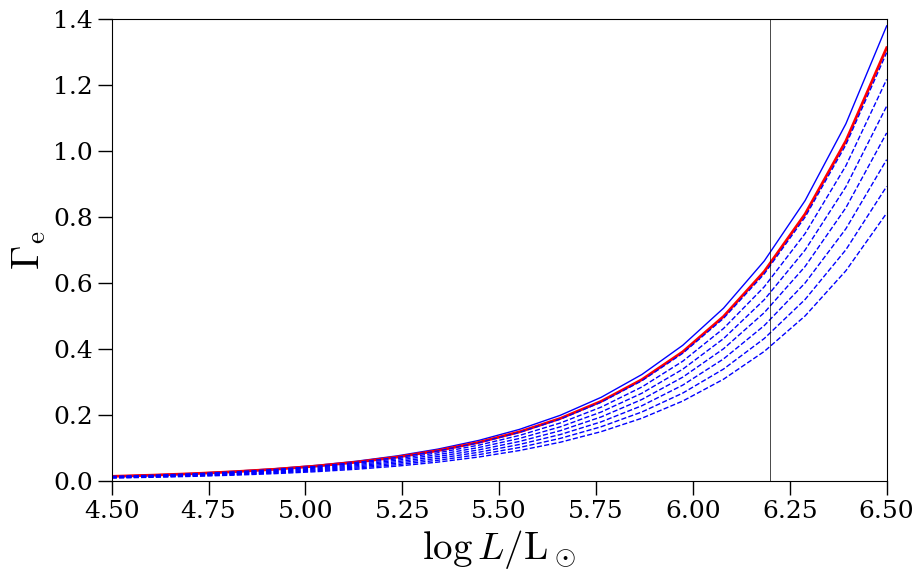

In [26]:
fig, ax = plt.subplots(figsize=(10,6))

m = 60
l = np.linspace(4.5, 6.5, 20)

lw = 1

x = 0.7
ax.plot(l, gamma_e(m, 10.**l, x), 'b-', lw=lw)
ax.plot(l, compas_gamma_e(m, 10.**l), 'r-')

x = 0.6
ax.plot(l, gamma_e(m, 10.**l, x), 'b--', lw=lw)

x = 0.5
ax.plot(l, gamma_e(m, 10.**l, x), 'b--', lw=lw)

x = 0.4
ax.plot(l, gamma_e(m, 10.**l, x), 'b--', lw=lw)

x = 0.3
ax.plot(l, gamma_e(m, 10.**l, x), 'b--', lw=lw)

x = 0.2
ax.plot(l, gamma_e(m, 10.**l, x), 'b--', lw=lw)

x = 0.1
ax.plot(l, gamma_e(m, 10.**l, x), 'b--', lw=lw)

x = 0
ax.plot(l, gamma_e(m, 10.**l, x), 'b--', lw=lw)

ax.vlines(6.2, 0, 1.5, color='k', lw=0.5)

ax.set_xlim(4.5, 6.5)
ax.set_ylim(0, 1.4)

ax.set_xlabel('$\\log L/\\mathrm{L}_\\odot$')
ax.set_ylabel('$\\Gamma_\\mathrm{e}$')

In [27]:
def hre_diagram_tracks(
    ax,
    models_to_plot,
    model_style_list,
    xlim, 
    ylim,
    legend=True,
    labelx=True, 
    labely=True
    ):
    model_dict_list = model_dicts[models_to_plot]
    model_label_list = model_labels[models_to_plot]
    
    settings = dict(
        x='log_Teff',
        #y='^log_L/Estar_mass)',
        y='Estar_mass,^log_L,surface_h1)',
        invert_xaxis=True,
        invert_yaxis=False,
        model_dict_list=model_dict_list,
        model_styles=model_style_list,
        model_labels=model_label_list,
        label_period=legend
        )

    ax = history_plot(ax, **settings)

    if labelx:
        ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
    if labely:
        ax.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
    
    if xlim is not None:    
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
    
    return ax

### Final properties

In [28]:
def get_core_mass_spin_w(logs, iso):
    central_iso_arr = [logs.profile_data(profile_number=n).__getattr__(iso)[-1] for n in logs.profile_numbers]
    max_iso_i = np.argmax(central_iso_arr)
    core_prof = logs.profile_data(profile_number=logs.profile_numbers[max_iso_i])
    core_edge_index = np.where(np.abs(core_prof.__getattr__(iso)-core_prof.__getattr__(iso)[-1]) <= 0.01)[0][0]
    core_mass = core_prof.mass[core_edge_index]
    core_am = 10**core_prof.log_J_inside[core_edge_index]
    core_w = core_prof.omega[core_edge_index]
    core_spin = (ct.c.cgs * core_am * u.g*u.cm**2/u.s / (ct.G.cgs * (core_mass * ct.M_sun.cgs)**2 )).to(u.dimensionless_unscaled).value
    return core_mass, core_spin, core_w

In [29]:
class WindIntegrator:
    
    def __init__(self, model_path, q0=1) -> None:
        self.h = mr.MesaData(str(model_path/'LOGS/history.data'))
        self.logs = mr.MesaLogDir(str(model_path/'LOGS'))
        self.time = self.h.star_age
        self.mdot = -10.**self.h.log_abs_mdot
        self.w0 = self.h.surf_avg_omega[np.where(self.h.surf_avg_omega > 0)[0][0]]
        self.p0 = 2*np.pi/self.w0 * u.s.to(u.d)
        self.q0 = q0
        
    @staticmethod
    def a_from_p(p, m, q):
        p = fix_unit(p, u.d)
        m = fix_unit(m, u.Msun)
        a = np.cbrt(ct.G * (1+q) * m / (4*np.pi**2) * p**2)
        a = a.to(u.Rsun).value
        return a
        
    @staticmethod
    def p_from_a(a, m, q):
        a = fix_unit(a, u.Rsun)
        m = fix_unit(m, u.Msun)
        p = np.sqrt(4 * np.pi**2 / (ct.G * (1+q) * m) * a**3)
        p = p.to(u.d).value
        return p
    
    def integrate(self, t_target):
        m = self.h.star_mass[0]
        p = self.p0
        q = self.q0
        a = self.a_from_p(p, m, q)
        
        i = 0
        t0 = self.time[i]
        t1 = self.time[i+1]
        mdot = self.mdot[i]
        while t1 < t_target:
            dm = mdot*(t1-t0)
            da = -2/(1+q) * dm/m
            dq = 0
            
            m += dm
            a += da
            q += dq
            p = self.p_from_a(a, m, q)
            
            i += 1
            try:
                t1 = self.time[i+1]   
            except:
                print(f'Reached end of model at t={t1/1e6:.2f} Myr')
                break
            else:
                t0 = self.time[i]
                mdot = self.mdot[i]
        
        return m, p, a, q
    
    @staticmethod
    def p_from_s(s, m):
        j = (ct.G.cgs * (m * u.Msun)**2 * s / ct.c.cgs).to(u.s).value
        return p
    
    def get_final_core_mps(self):
        core_m, core_s, core_w = get_core_mass_spin_w(self.logs, iso='o16')
        core_p = 2*np.pi/core_w * u.s.to(u.d)
        return core_m, core_p, core_s

# Analysis

For now we only have models with mass variations, where all other settings fixed. These are $\delta_\mathrm{mesh}=1$, $Z=\mathrm{Z}_\odot/10$, $Y_0=0.4$ and $\delta Y=0.3$.

In [30]:
model_ids = np.arange(1, 21, 1)
model_ids = np.array([f'{id:03d}' for id in model_ids])
model_folders = np.array([get_model_folder(id) for id in model_ids])
model_dicts = np.array([get_model_dict(folder) for folder in model_folders])
model_labels = np.array([f'${float(id):0f}\,\\mathrm{{M}}_\\odot$' for id in model_ids])

Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/002_md1_m30_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/003_md1_m40_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/004_md1_m50_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/005_md1_m60_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/006_md1_m70_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/007_md1_m80_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/008_md1_m90_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/009_md1_m100_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/010_md1_m110_zsundiv10_04y0_03dy
Found match /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/011_md1_m120_zsund

Let's check the stellar models available.

In [31]:
print('Available models:')
for i in range(len(model_ids)):
    print(f'\t{model_folders[i]}:')
    keys1 = list(model_dicts[i].keys())
    keys1 = np.array(keys1)[np.argsort([float(key) for key in keys1])]
    for key1 in keys1:
        keys2 = list(model_dicts[i][key1].keys())
        keys2 = np.array(keys2)[np.argsort([float(key) for key in keys2])]
        print(f'\t\t(m1/msun) {key1}:')
        for key2 in keys2:
            print(f'\t\t\t(p_orb/d) {key2}')

Available models:
	/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy:
		(m1/msun) 20.0:
			(p_orb/d) 0.35
			(p_orb/d) 0.40
			(p_orb/d) 0.45
			(p_orb/d) 0.50
			(p_orb/d) 0.55
			(p_orb/d) 0.60
			(p_orb/d) 0.65
			(p_orb/d) 0.70
			(p_orb/d) 0.75
			(p_orb/d) 0.80
			(p_orb/d) 0.85
			(p_orb/d) 0.90
			(p_orb/d) 1.00
			(p_orb/d) 1.10
			(p_orb/d) 1.20
			(p_orb/d) 1.30
			(p_orb/d) 1.40
			(p_orb/d) 1.50
			(p_orb/d) 1.60
			(p_orb/d) 1.70
			(p_orb/d) 1.80
			(p_orb/d) 1.90
			(p_orb/d) 2.00
			(p_orb/d) 2.10
			(p_orb/d) 2.20
			(p_orb/d) 2.30
			(p_orb/d) 2.40
			(p_orb/d) 2.50
			(p_orb/d) 2.60
			(p_orb/d) 2.80
			(p_orb/d) 3.00
			(p_orb/d) 3.20
			(p_orb/d) 3.40
			(p_orb/d) 3.60
			(p_orb/d) 3.80
			(p_orb/d) 4.00
	/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/002_md1_m30_zsundiv10_04y0_03dy:
		(m1/msun) 30.0:
			(p_orb/d) 0.35
			(p_orb/d) 0.40
			(p_orb/d) 0.45
			(p_orb/d) 0.50
			(p_orb/d) 0.55
			(p_orb/d) 0.60
			(p_orb/d) 0.65
			(p_or

### The effect of mass

Let's first look at the evolution of our systems in the HR diagram.

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(20, 14))
fig.subplots_adjust(wspace=0)

mass_label_x = 0.1
mass_label_y = 0.1
mass_label_fontsize = 18

xlim = (5.5, 4.5)
ylim = (4.5, 6.5)

# PLOT M=20
ax = axes[0, 0]
models_to_plot = [0]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$20\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=50
ax = axes[0, 1]
models_to_plot = [1]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$30\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=40
ax = axes[0, 2]
models_to_plot = [2]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$40\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=50
ax = axes[0, 3]
models_to_plot = [3]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$50\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=60
ax = axes[0, 4]
models_to_plot = [4]
model_style_list = ['-']
legend = True
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$60\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

xlim = (5.5, 4.6)
ylim = (5.75, 6.5)

# PLOT M=70
ax = axes[1, 0]
models_to_plot = [5]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$70\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=80
ax = axes[1, 1]
models_to_plot = [6]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$80\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=90
ax = axes[1, 2]
models_to_plot = [7]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$90\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=100
ax = axes[1, 3]
models_to_plot = [8]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$100\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=110
ax = axes[1, 4]
models_to_plot = [9]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$110\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

xlim = (5.5, 4.7)
ylim = (6.1, 6.7)

# PLOT M=120
ax = axes[2, 0]
models_to_plot = [10]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$120\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=140
ax = axes[2, 1]
models_to_plot = [11]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$140\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=160
ax = axes[2, 2]
models_to_plot = [12]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$160\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=180
ax = axes[2, 3]
models_to_plot = [13]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$180\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=200
ax = axes[2, 4]
models_to_plot = [14]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$200\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

xlim = (5.5, 4.7)
ylim = (6.0, 7.0)

# PLOT M=220
ax = axes[3, 0]
models_to_plot = [15]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(mass_label_x, mass_label_y, '$220\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=240
ax = axes[3, 1]
models_to_plot = [16]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$240\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=260
ax = axes[3, 2]
models_to_plot = [17]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$260\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=280
ax = axes[3, 3]
models_to_plot = [18]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$280\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

# PLOT M=300
ax = axes[3, 4]
models_to_plot = [19]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(mass_label_x, mass_label_y, '$300\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes, fontsize=mass_label_fontsize)

#######################################

fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\log L/\\mathrm{L}_\\odot$', rotation=90, va='center', ha='right')

savefig(fig, 'hr_allp_mass_comparison_new')

Model /mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w1.454d-04 failed to load.


### Stopping conditions

A few of the models are stopped because they are either not stable or not CHE. 

* Models which are critically rotating at ZAMS immediately respond by acquiring strong wind-boosted mass loss and expanding dramatically, while they are still trying to relax to the set initial spin period; these are not stable and are stopped at ZAMS or very shortly thereafter. These are easily identified as the lower period (bluer) straight tracks that start expanding at ZAMS (head to lower temperatures).

* Some of the slower rotators do not become chemically homogeneous and the models are stopped when $\mathrm{X}_\mathrm{center}/\mathrm{X}_\mathrm{surface}=0.7$. This stopping condition is visible in the longer period tracks (redder) that are cut off as they are leaving the main sequence and expanding.

* The current implementation of the "no critical rotation at ZAMS" condition catches and stops some models as they reach critical rotation when they contract *post*-MS. This affects low-mass highly rotating stars, which lose less AM through winds and thus reach critical rotation after contracting. This is what stops the $(20\,\mathrm{M}_\odot,0.35\,\mathrm{d})$, $(30\,\mathrm{M}_\odot,0.35\,\mathrm{d})$ and $(30\,\mathrm{M}_\odot,0.40\,\mathrm{d})$ tracks.

* Some tracks "break" post-core He burning: $(20\,\mathrm{M}_\odot,0.35\,\mathrm{d})$. Those we check one by one.

### $60\,\mathrm{M}_\odot,0.35\,\mathrm{d}$

Text(0.5, 1.0, '$60.0\\,\\mathrm{M}_\\odot$')

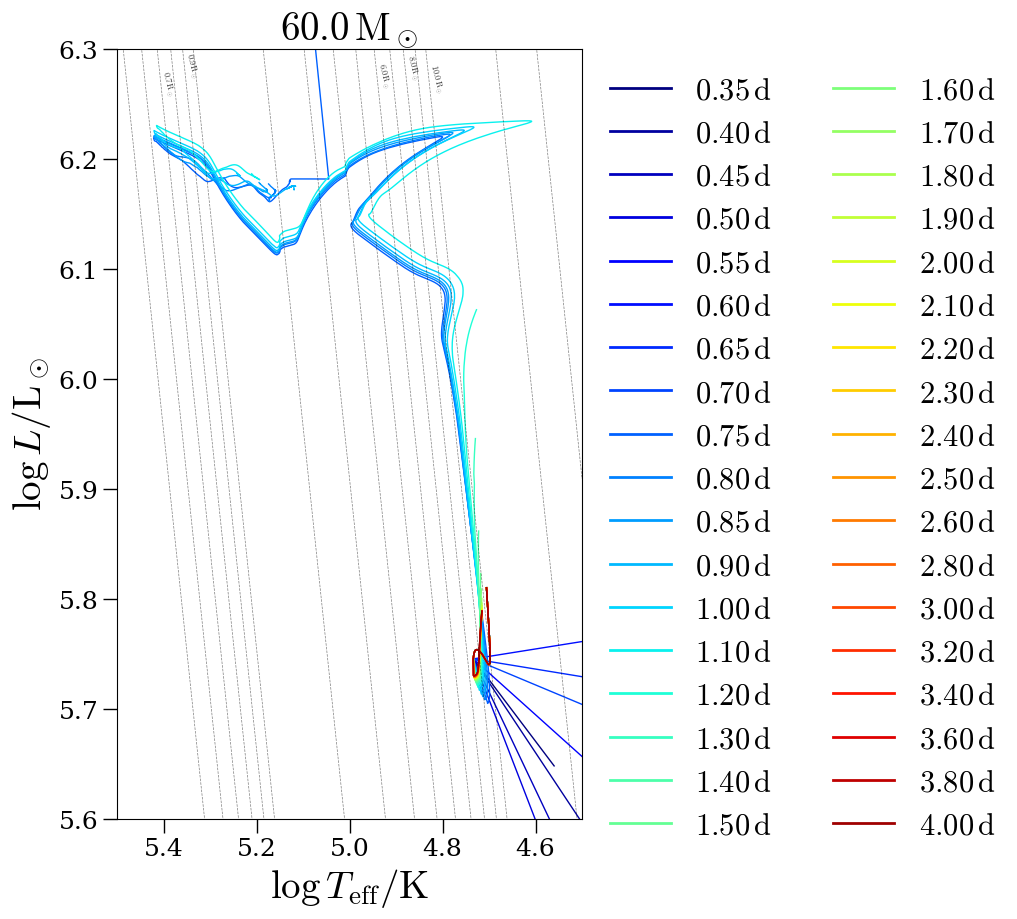

In [32]:
fig, ax = plt.subplots(figsize=(6, 10))
test_m = '60.0'

models_to_plot = [4]
model_style_list = ['-']
xlim = (5.5, 4.5)
ylim = (5.6, 6.3)
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=[4],
    model_style_list=['-'],
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

Text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$')

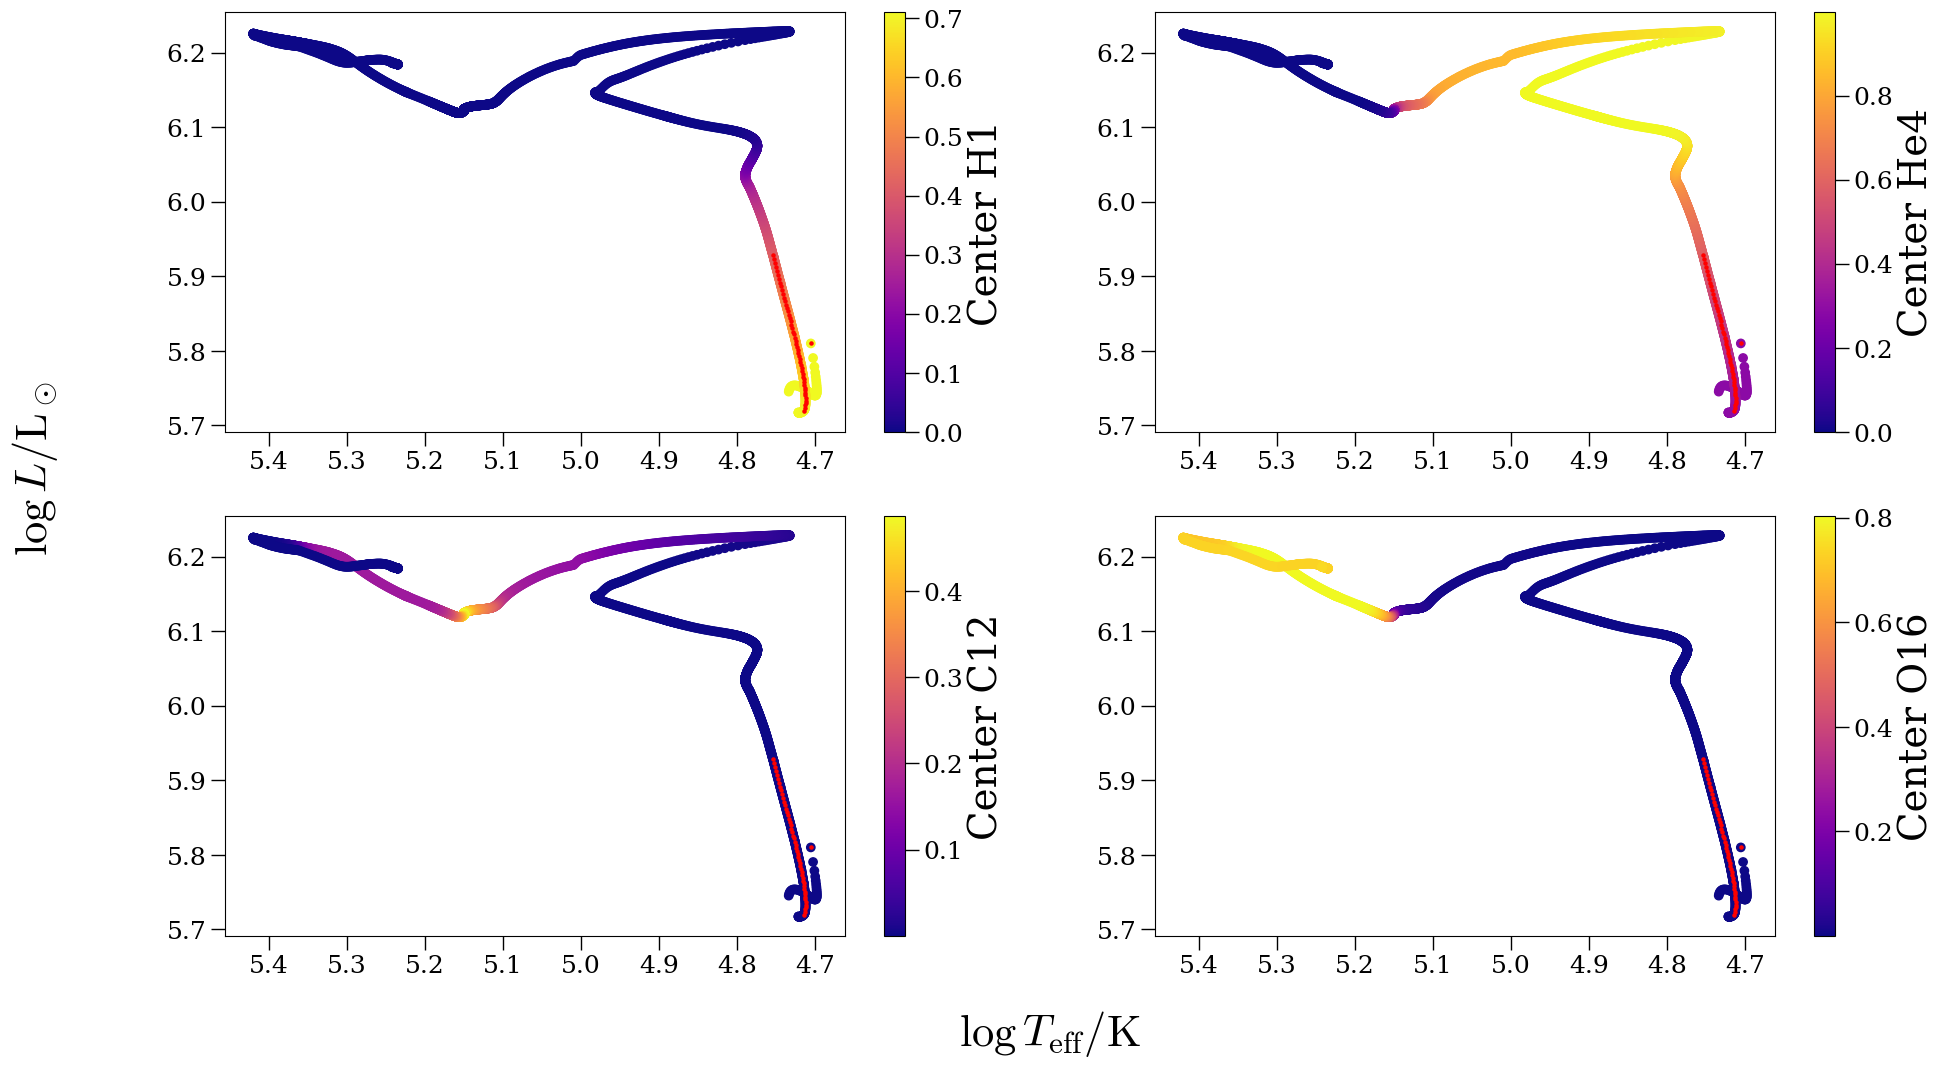

In [34]:
wind_test_h = mr.MesaData(str(model_dicts[4]['60.0']['1.00']/'LOGS/history.data'))

fig, axes = plt.subplots(2, 2, figsize=(22, 12))

h = wind_test_h
cmap = cm.plasma
y = h.log_L
x = h.log_Teff

cdata = [
    h.center_h1,
    h.center_he4,
    h.center_c12,
    h.center_o16
]

labels = [
    'Center H1',
    'Center He4',
    'Center C12',
    'Center O16'
]

for ax, label, cdatum in zip(axes.flatten(), labels, cdata):
    c = cmap(normarr(cdatum))
    ax.scatter(x, y, c=c, alpha=1)
    ax.invert_xaxis()

    cb = fig.colorbar(ScalarMappable(Normalize(vmin=min(cdatum), vmax=max(cdatum)), cmap=cmap), ax=ax)
    cb.set_label(label)
    
# Time interval markers
models_to_mark = np.arange(0, 4000, 100)
models_to_mark = np.arange(0, 10**6.4, 5e4)
model_numbers = h.star_age
modelmarker_indices = [np.argmin(np.abs(model_n-model_numbers)) for model_n in models_to_mark]
modelmarker_logl = h.log_L[modelmarker_indices]
modelmarker_logteff = h.log_Teff[modelmarker_indices]
for ax in axes.flatten():
    ax.scatter(modelmarker_logteff, modelmarker_logl, color='r', marker='o', alpha=1, s=5)

fig.text(0.05, 0.5, '$\\log L/\\mathrm{L}_\\odot$', ha='right', va='center', rotation=90, transform=fig.transFigure, fontsize=32)
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top', transform=fig.transFigure, fontsize=32)

In [34]:
def X(z):
    slope = (0.7-0.75)/(0.014-0)
    intercept = 0.7
    offset = 0.014
    return intercept + slope*(z-offset)

In [35]:
def mu(z):
    x = X(z)
    y = 1 - x - z
    mu = 1/(2*x + 3/4*y + 1/2*z)
    return mu

In [36]:
def rad_dom_boundary(rho, z):
    m = mu(z)
    t = 3.2e7 * m**(-1/3) * rho**(1/3)
    return t

In [37]:
# from MESA eos plotter
def parse(fname):
    nY, nX = np.loadtxt(fname, max_rows=1, skiprows=3, unpack=True, dtype=int)
    data = np.loadtxt(fname, skiprows=4)
    data = np.reshape(data, ((nX, nY, -1)))
    Yran = np.array(data[0,:,0])
    Xran = np.array(data[:,0,1])
    data = np.swapaxes(data, 0, 1)
    return data, Yran, Xran

eosDT, Yran, Xran = parse('eos_plotter.dat')

Text(0.5, 0.98, '$300.0\\,\\mathrm{M}_\\odot$')

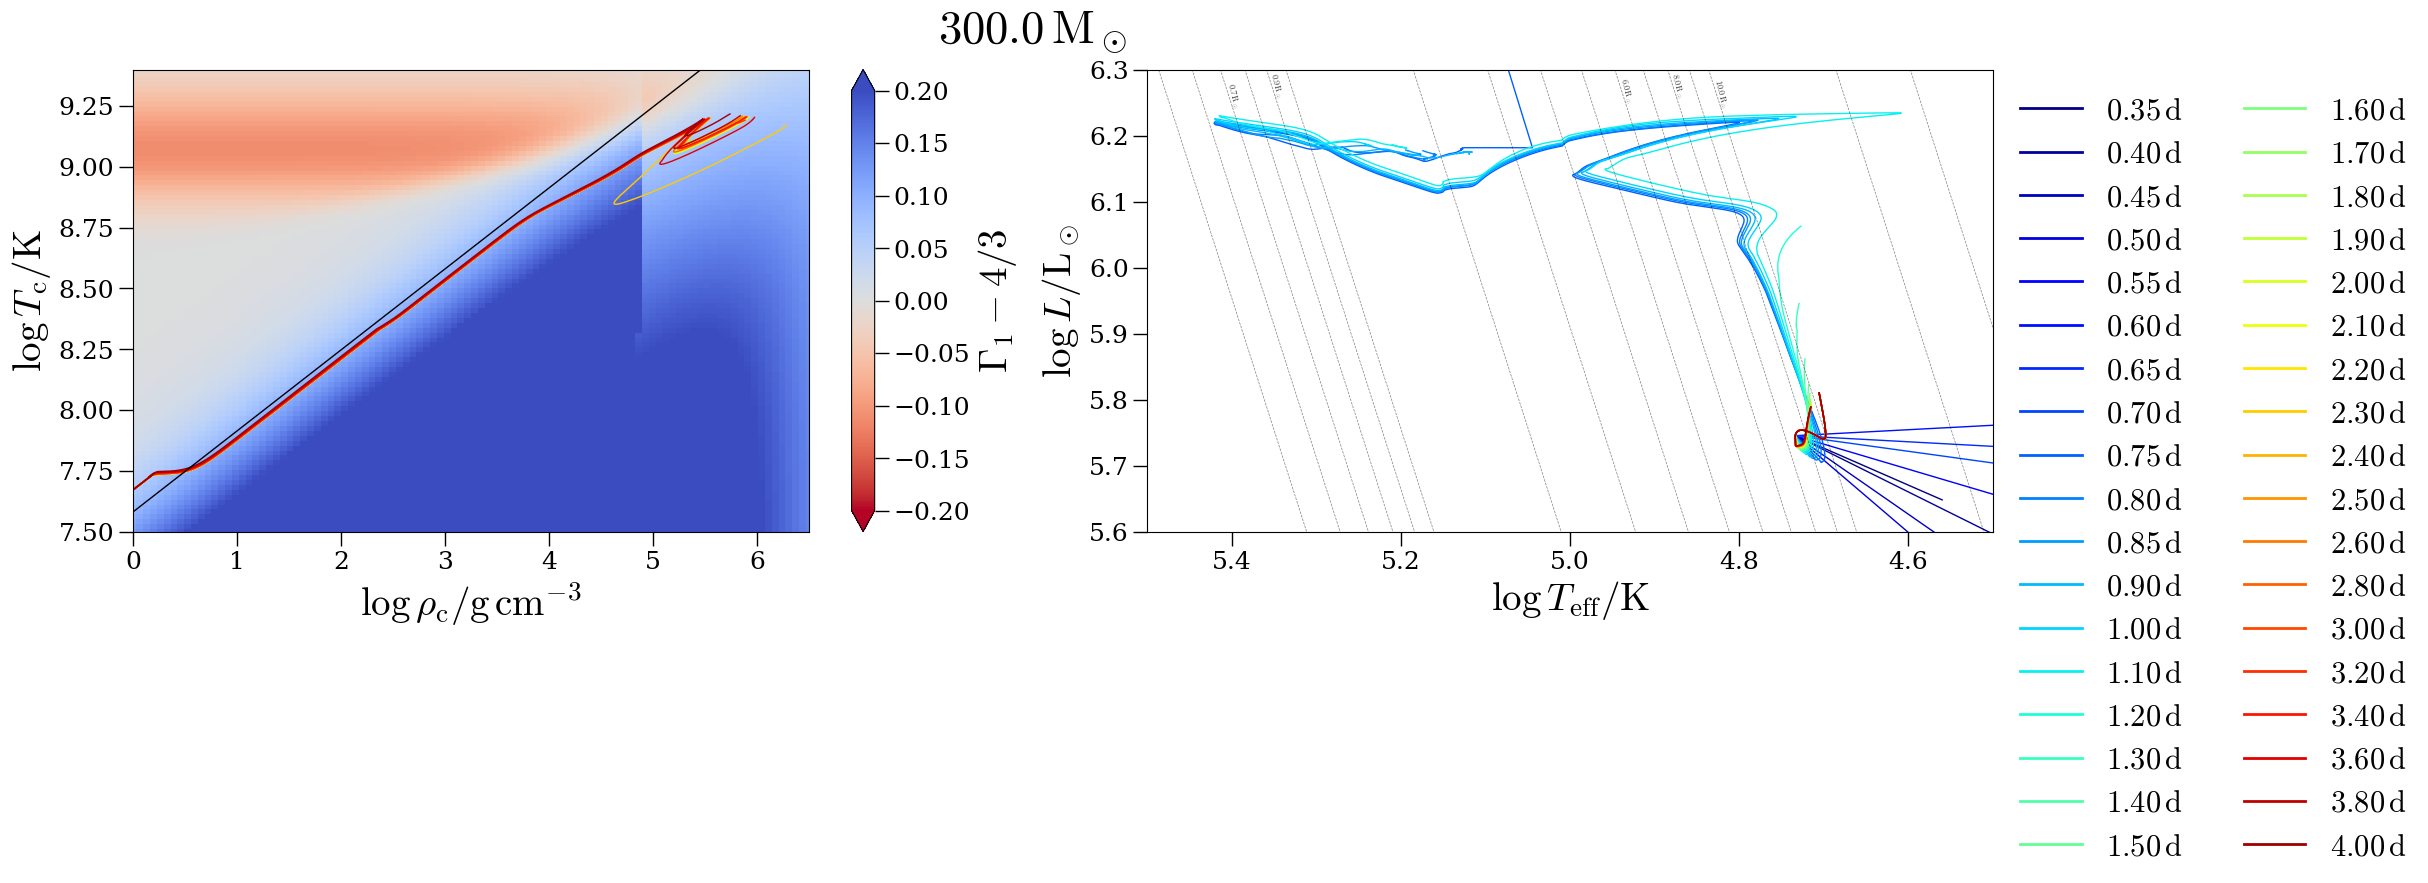

In [40]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(24, 6))
test_m = '300.0'
z = ZSUN/10

models_to_plot = [19]
model_style_list = ['-']
xlim = (0, 6.5)
ylim = (7.5, 9.4)
legend = False
labelx = True
labely = True

ax1 = density_temperature_diagram_tracks(
    ax=ax1,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax1.plot(np.linspace(-10, 10, 20), np.log10(rad_dom_boundary(10.**np.linspace(-10, 10, 20), z)), 'k-', lw=1)
pcol = ax1.pcolormesh(Xran, Yran, eosDT[...,2]-4/3, shading='nearest', cmap=cm.coolwarm_r, vmin=-0.2, vmax=0.2)
cax = fig.colorbar(pcol, extend='both')
cax.set_label('$\Gamma_1-4/3$')

ax.set_xlim(0, 6.5)
ax.set_ylim(7.5, 9.4)

models_to_plot = [4]
model_style_list = ['-']
xlim = (5.5, 4.5)
ylim = (5.6, 6.3)
legend = True
labelx = True
labely = True

ax2 = hr_diagram_tracks(
    ax=ax2,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

fig.suptitle(f'${test_m}\,\mathrm{{M}}_\\odot$')

Text(0.5, 0.98, '$180.0\\,\\mathrm{M}_\\odot$')

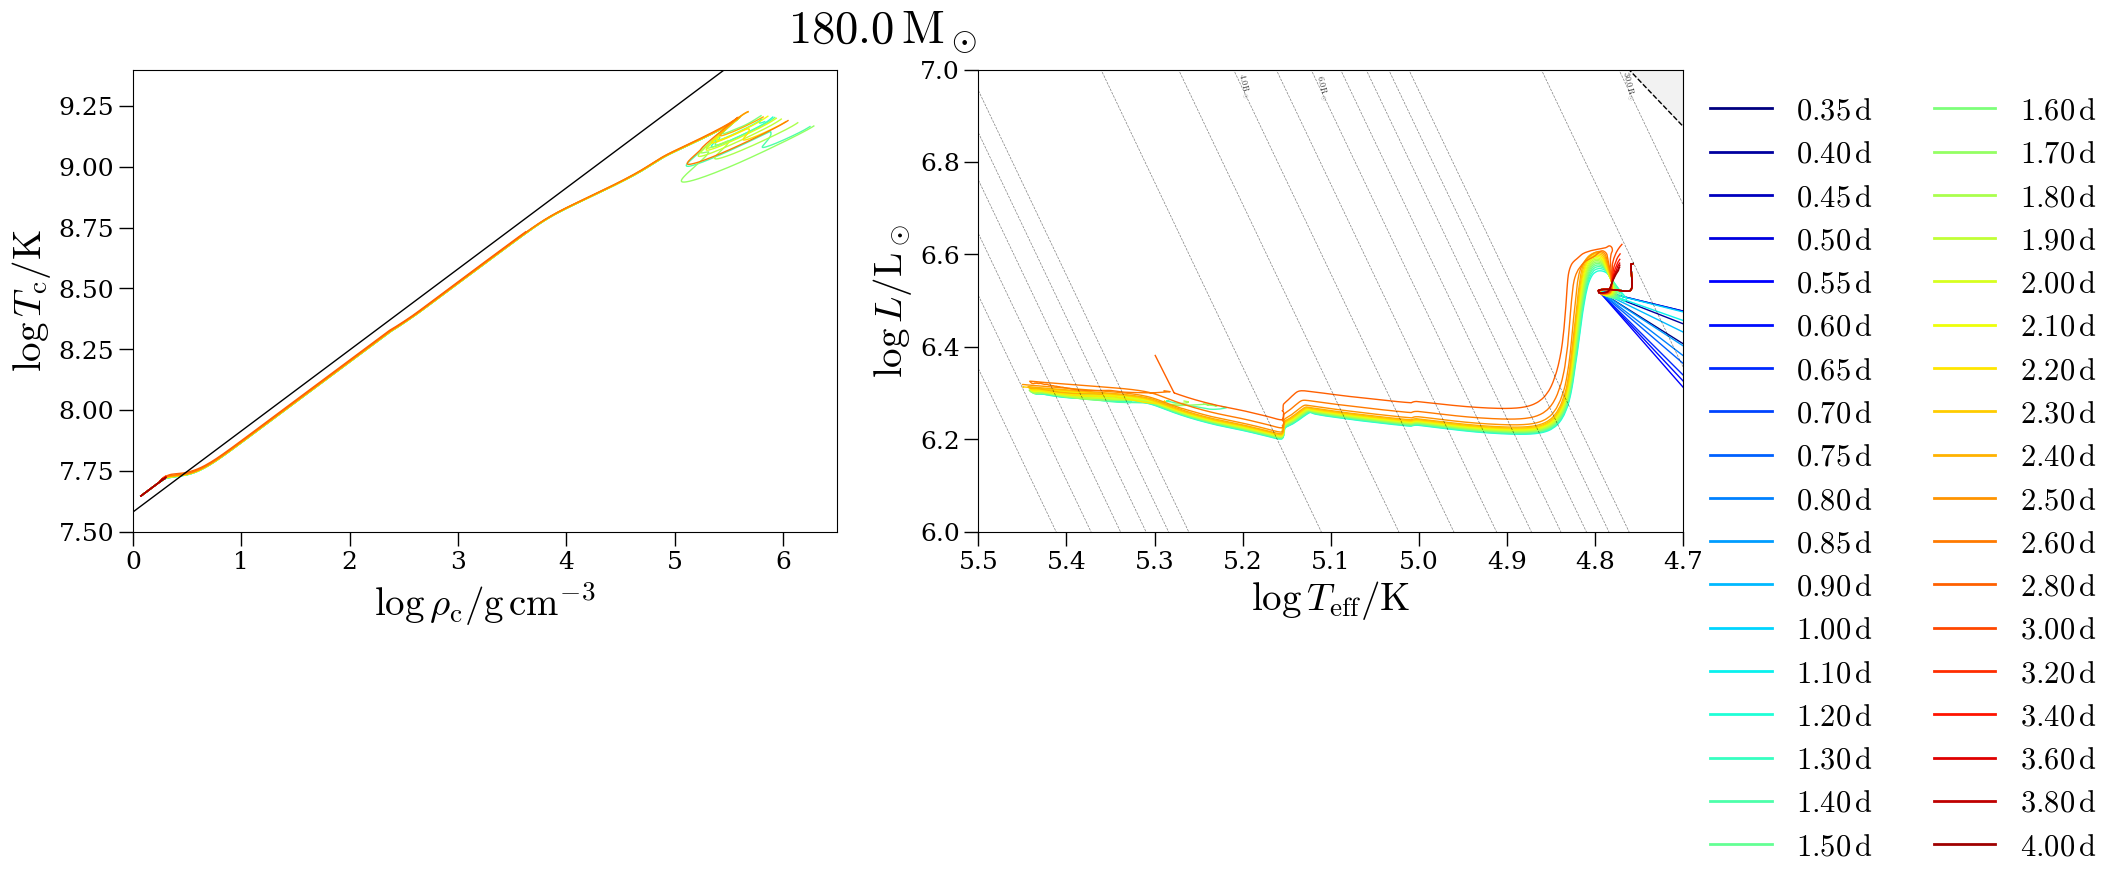

In [39]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 6))
test_m = '180.0'
z = ZSUN/10

models_to_plot = [13]
model_style_list = ['-']
xlim = (0, 6.5)
ylim = (7.5, 9.4)
legend = False
labelx = True
labely = True

ax1 = density_temperature_diagram_tracks(
    ax=ax1,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax1.plot(np.linspace(-10, 10, 20), np.log10(rad_dom_boundary(10.**np.linspace(-10, 10, 20), z)), 'k-', lw=1)

models_to_plot = [13]
model_style_list = ['-']
xlim = (5.5, 4.7)
ylim = (6.0, 7.0)
legend = True
labelx = True
labely = True

ax2 = hr_diagram_tracks(
    ax=ax2,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

fig.suptitle(f'${test_m}\,\mathrm{{M}}_\\odot$')

Text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$')

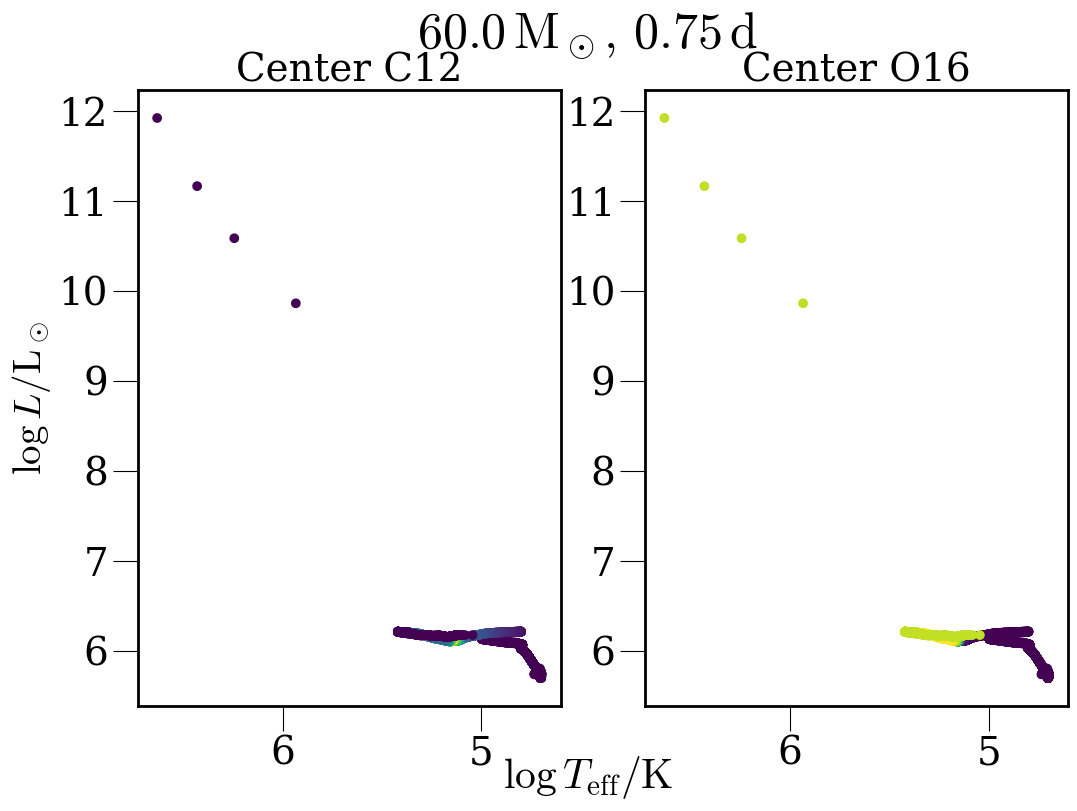

In [67]:
test_m = '60.0'
test_p = '0.75'
test_h = mr.MesaData(str(model_dicts[4][test_m][test_p]/'LOGS/history.data'))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 8))

ax1.scatter(test_h.log_Teff, test_h.log_L, c=test_h.center_c12)
ax1.invert_xaxis()
ax1.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
ax1.set_title('Center C12')

ax2.scatter(test_h.log_Teff, test_h.log_L, c=test_h.center_o16)
ax2.invert_xaxis()
ax2.set_title('Center O16')

fig.suptitle(f'${test_m}\\,\\mathrm{{M}}_\\odot,\\,{test_p}\\,\\mathrm{{d}}$')
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top')

(5.5, 4.6)

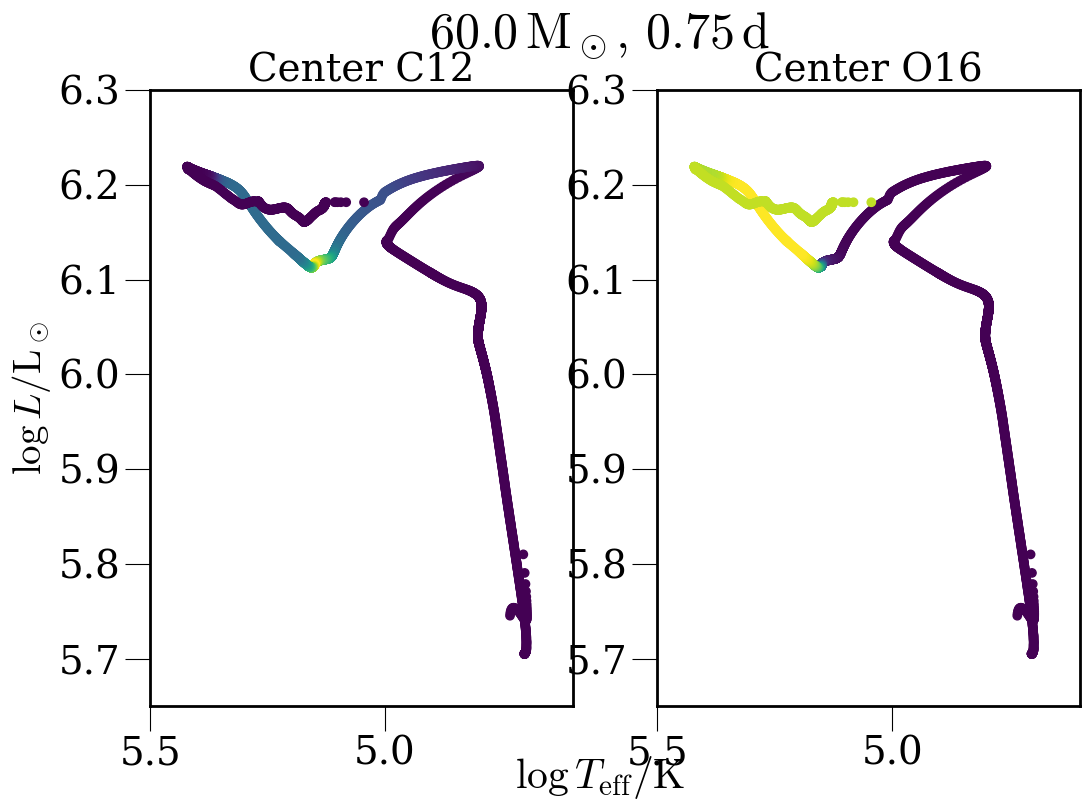

In [214]:
test_id = 4
test_m = '60.0'
test_p = '0.75'
test_h = mr.MesaData(str(model_dicts[test_id][test_m][test_p]/'LOGS/history.data'))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 8))

ax1.scatter(test_h.log_Teff, test_h.log_L, c=test_h.center_c12)
ax1.invert_xaxis()
ax1.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
ax1.set_title('Center C12')

ax2.scatter(test_h.log_Teff, test_h.log_L, c=test_h.center_o16)
ax2.invert_xaxis()
ax2.set_title('Center O16')

fig.suptitle(f'${test_m}\\,\\mathrm{{M}}_\\odot,\\,{test_p}\\,\\mathrm{{d}}$')
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top')

ylim = (5.65, 6.3)
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)

xlim = (5.5, 4.6)
ax1.set_xlim(xlim)
ax2.set_xlim(xlim)



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


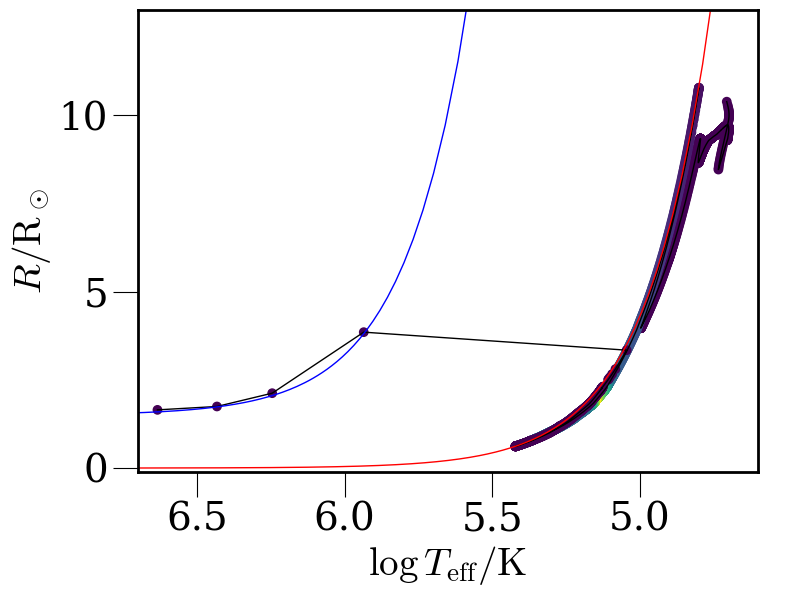

In [215]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_h.log_Teff, test_h.radius, c=test_h.center_c12)
ax.plot(test_h.log_Teff, test_h.radius, c='k', lw=1)
ax.plot(np.log10(np.linspace(10**ax.get_xlim()[0], 10**ax.get_xlim()[1], 1000)), 4.3e10*np.linspace(10**ax.get_xlim()[0], 10**ax.get_xlim()[1], 1000)**-2, 'r-', lw=1)
ax.plot(np.log10(np.linspace(10**ax.get_xlim()[0], 10**ax.get_xlim()[1], 1000))+0.8, 1.5+4.3e10*np.linspace(10**ax.get_xlim()[0], 10**ax.get_xlim()[1], 1000)**-2, 'b-', lw=1)

ax.set_xlim(6.7, 4.6)
ax.set_ylim(-0.1, 13)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$R/\\mathrm{R}_\\odot$')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

In [250]:
test_id = 4
test_m = '60.0'
test_p = '0.75'
test_case = model_dicts[test_id][test_m][test_p]
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

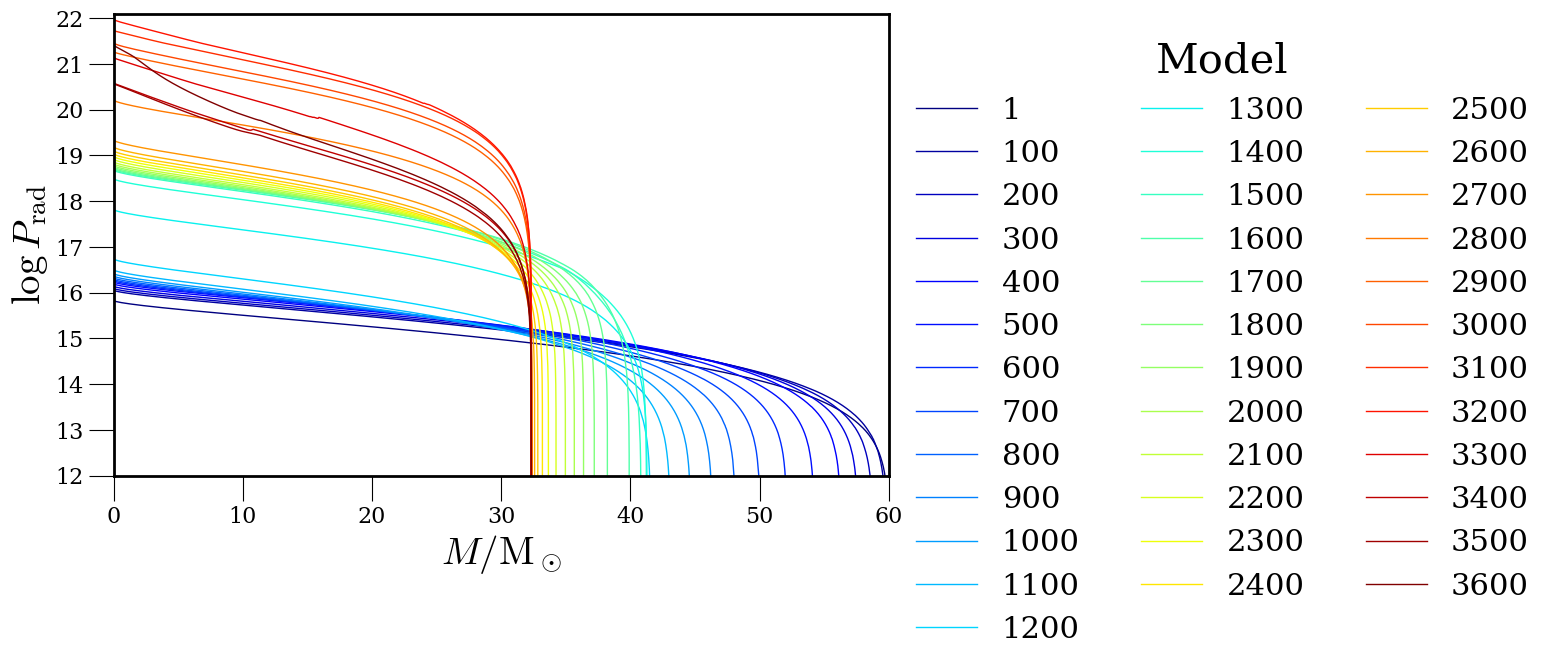

In [251]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    prof = logs.profile_data(profile_number=n)
    c = cm.jet(prof.model_number/3600)
    ax.plot(prof.mass, np.log10(prof.prad), c=c, label=f'{prof.model_number}', lw=1)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3, title='Model')
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\log P_\\mathrm{rad}$')
ax.set_ylim(12, 22.1)
ax.set_xlim(0, 60)
ax.tick_params(labelsize=16)
ax.set_yticks(np.arange(12, 23, 1))
    

In [42]:
test_id = 4
test_m = '60.0'
test_p = '0.80'
test_case = model_dicts[test_id][test_m][test_p]
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

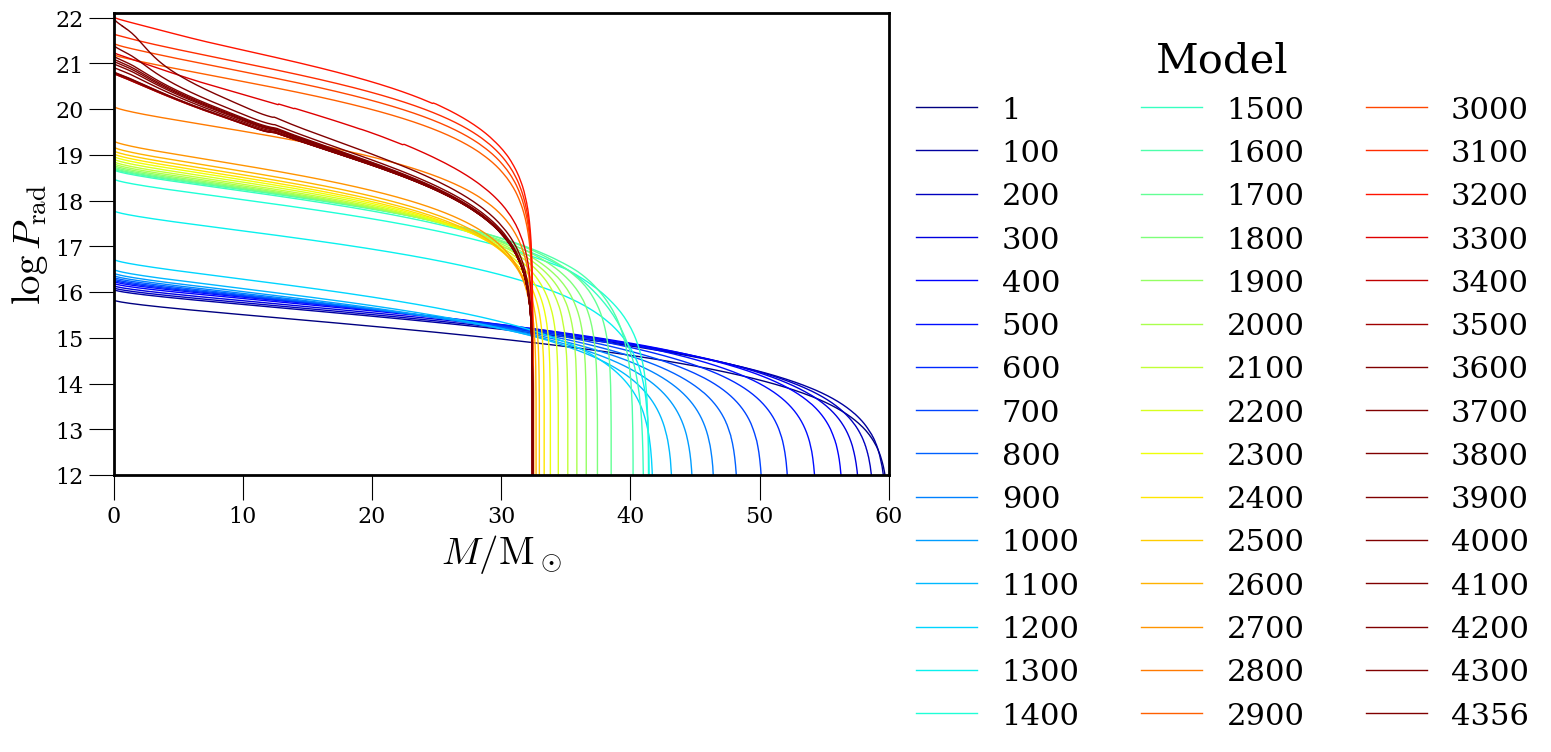

In [253]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    prof = logs.profile_data(profile_number=n)
    c = cm.jet(prof.model_number/3600)
    ax.plot(prof.mass, np.log10(prof.prad), c=c, label=f'{prof.model_number}', lw=1)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3, title='Model')
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\log P_\\mathrm{rad}$')
ax.set_ylim(12, 22.1)
ax.set_xlim(0, 60)
ax.tick_params(labelsize=16)
ax.set_yticks(np.arange(12, 23, 1))
    

In [55]:
test_id = 4
test_m = '60.0'
test_p = '0.75'
test_case = model_dicts[test_id][test_m][test_p]
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

(8.5, 10.0)

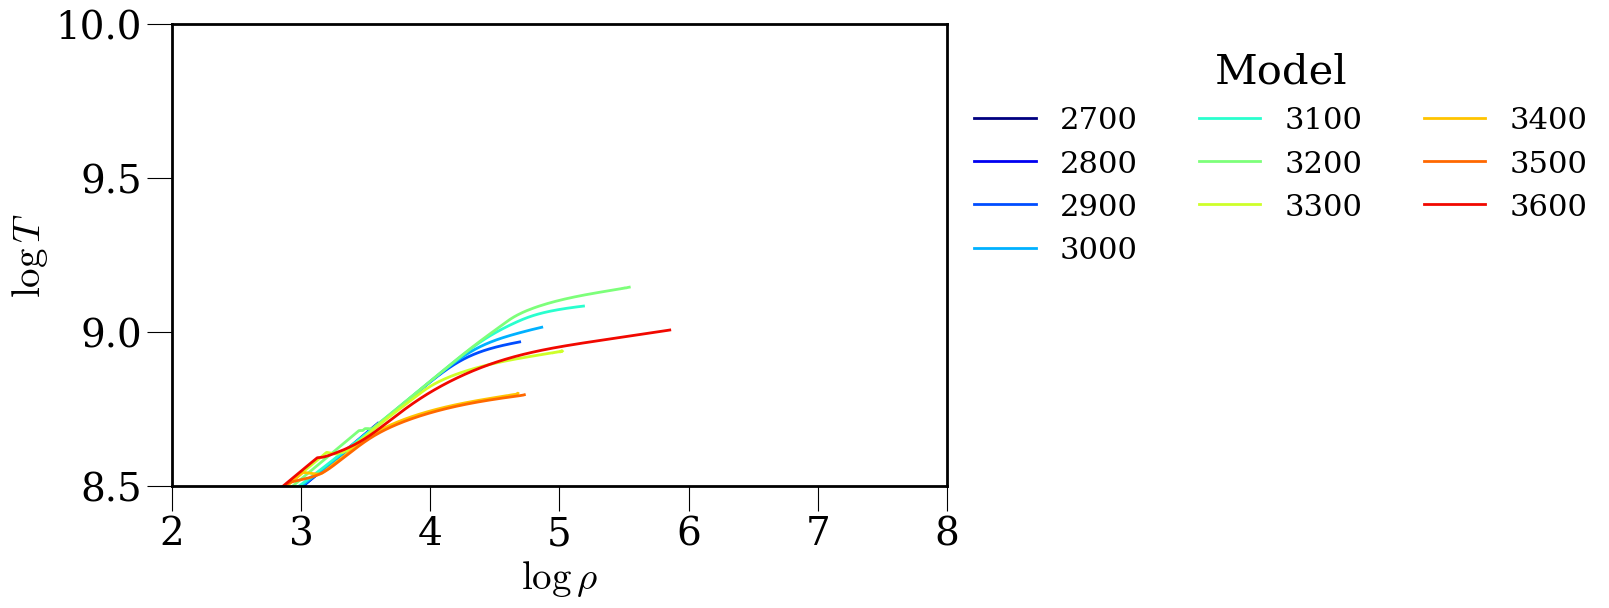

In [57]:
fig, ax = plt.subplots(figsize=(10,6))

a = -10
for i, n in enumerate(profile_numbers[a:]):
    prof = logs.profile_data(profile_number=n)
    c = cm.jet(i/len(profile_numbers[a:]))
    ax.plot(prof.logRho, prof.logT, c=c, label=f'{prof.model_number}', lw=2)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3, title='Model')
ax.set_xlabel('$\\log\\rho$')
ax.set_ylabel('$\\log T$')
#ax.set_ylim(12, 22.1)
#ax.set_xlim(0, 60)
#ax.tick_params(labelsize=16)
#ax.set_yticks(np.arange(12, 23, 1))
ax.set_xlim(2, 8)
ax.set_ylim(8.5, 10)

In [54]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[4]['60.0']['0.75']/'LOGS'))
mm.scrubHistory()

2618.0


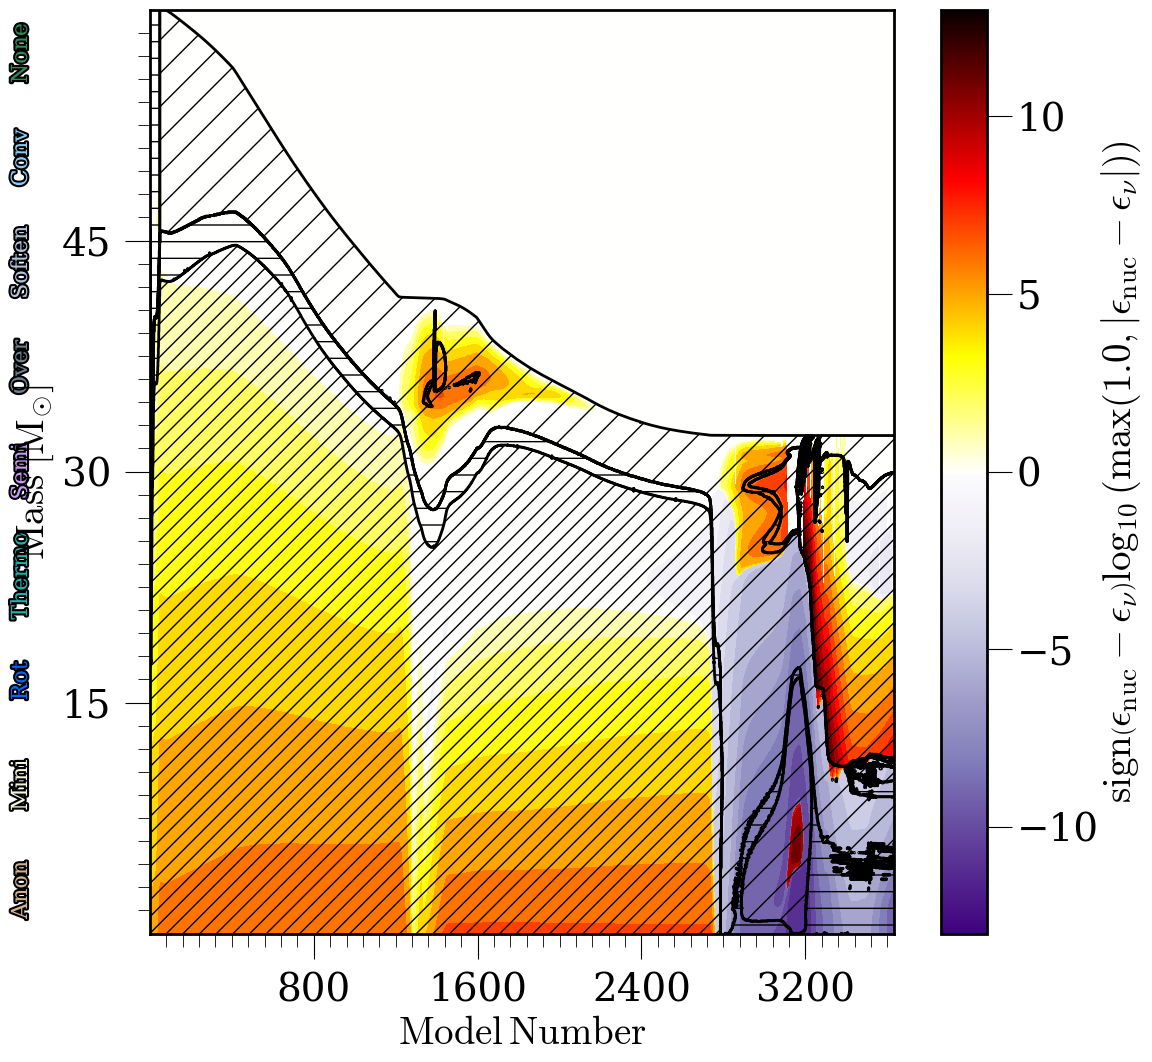

<Figure size 640x480 with 0 Axes>

In [55]:
p = mp.plot()
p.plotKip3(mm, show_mix=True, mix_hatch=True)
savefig(fig, 'kipp_mass_60_075')

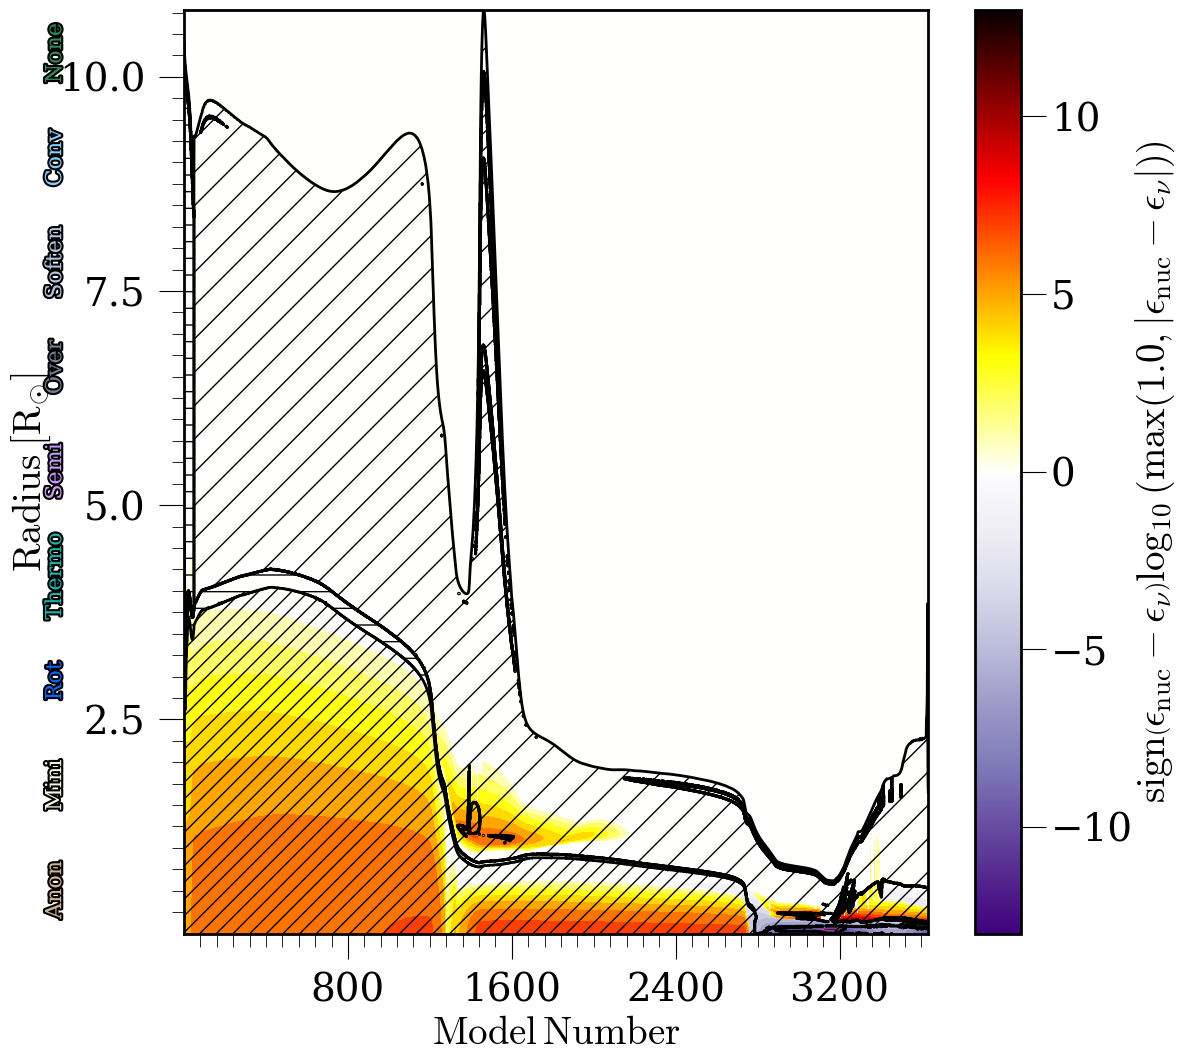

<Figure size 640x480 with 0 Axes>

In [56]:
p = mp.plot()
p.plotKip3(mm, show_mix=True, mix_hatch=True, yaxis='radius')
savefig(fig, 'kipp_radius_60_075')

Text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$')

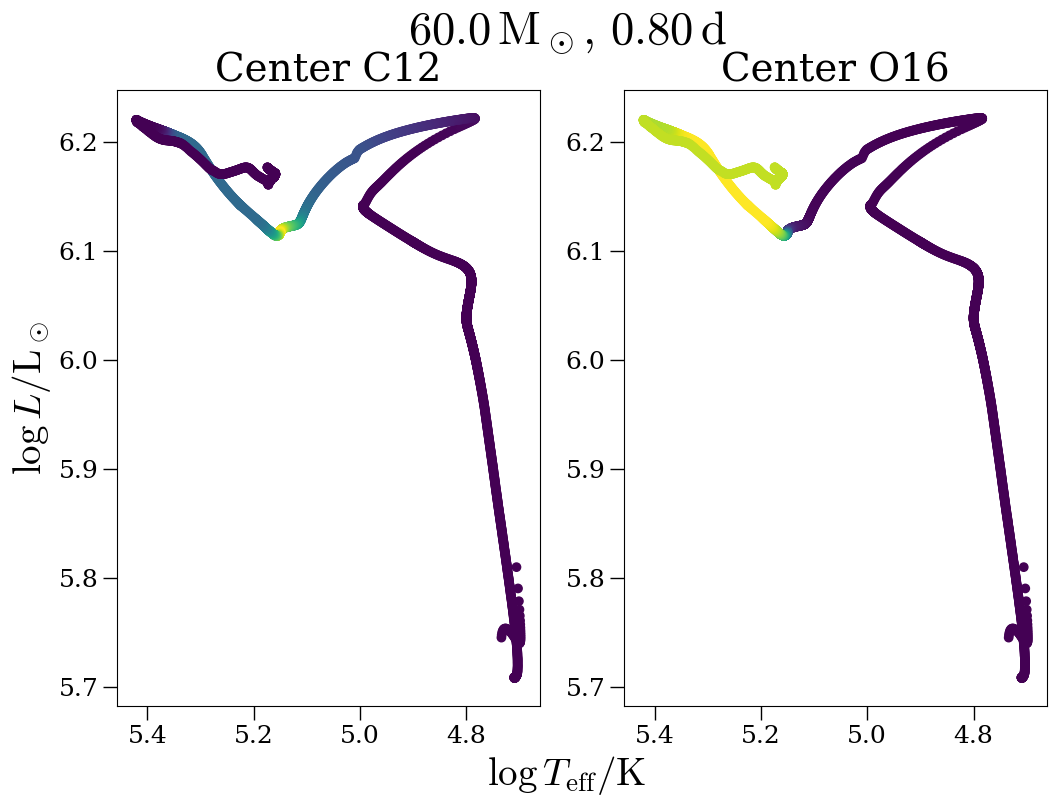

In [33]:
test_id = 4
test_m = '60.0'
test_p = '0.80'
test_h = mr.MesaData(str(model_dicts[test_id][test_m][test_p]/'LOGS/history.data'))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 8))

ax1.scatter(test_h.log_Teff, test_h.log_L, c=test_h.center_c12)
ax1.invert_xaxis()
ax1.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
ax1.set_title('Center C12')

ax2.scatter(test_h.log_Teff, test_h.log_L, c=test_h.center_o16)
ax2.invert_xaxis()
ax2.set_title('Center O16')

fig.suptitle(f'${test_m}\\,\\mathrm{{M}}_\\odot,\\,{test_p}\\,\\mathrm{{d}}$')
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top')



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


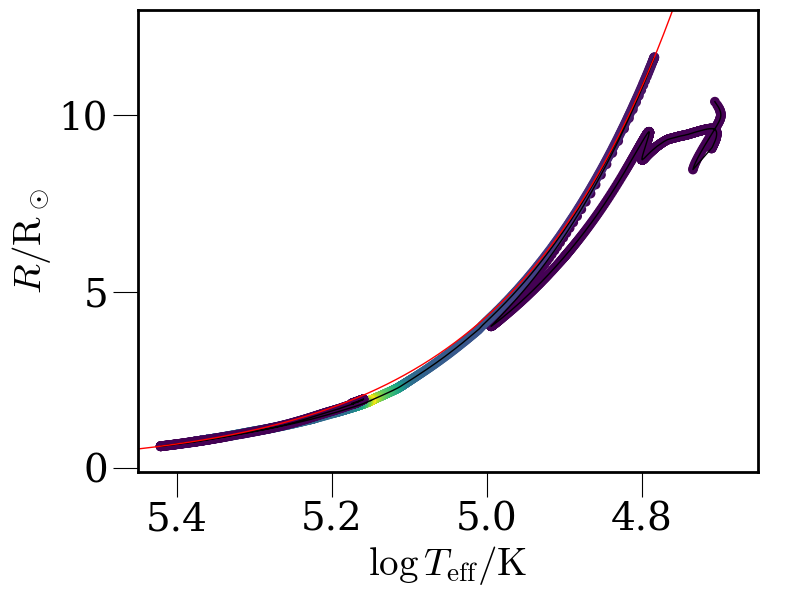

In [213]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(test_h.log_Teff, test_h.radius, c=test_h.center_c12)
ax.plot(test_h.log_Teff, test_h.radius, c='k', lw=1)
ax.plot(np.log10(np.linspace(10**ax.get_xlim()[0], 10**ax.get_xlim()[1], 1000)), 4.3e10*np.linspace(10**ax.get_xlim()[0], 10**ax.get_xlim()[1], 1000)**-2, 'r-', lw=1)
#ax.plot(np.log10(np.linspace(10**ax.get_xlim()[0], 10**ax.get_xlim()[1], 1000))+0.8, 1.5+4.3e10*np.linspace(10**ax.get_xlim()[0], 10**ax.get_xlim()[1], 1000)**-2, 'b-', lw=1)

ax.set_xlim(5.45, 4.65)
ax.set_ylim(-0.1, 13)

ax.set_xlabel('$\\log T_\\mathrm{eff}/\\mathrm{K}$')
ax.set_ylabel('$R/\\mathrm{R}_\\odot$')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

In [34]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[test_id][test_m][test_p]/'LOGS'))
mm.scrubHistory()

2488.0


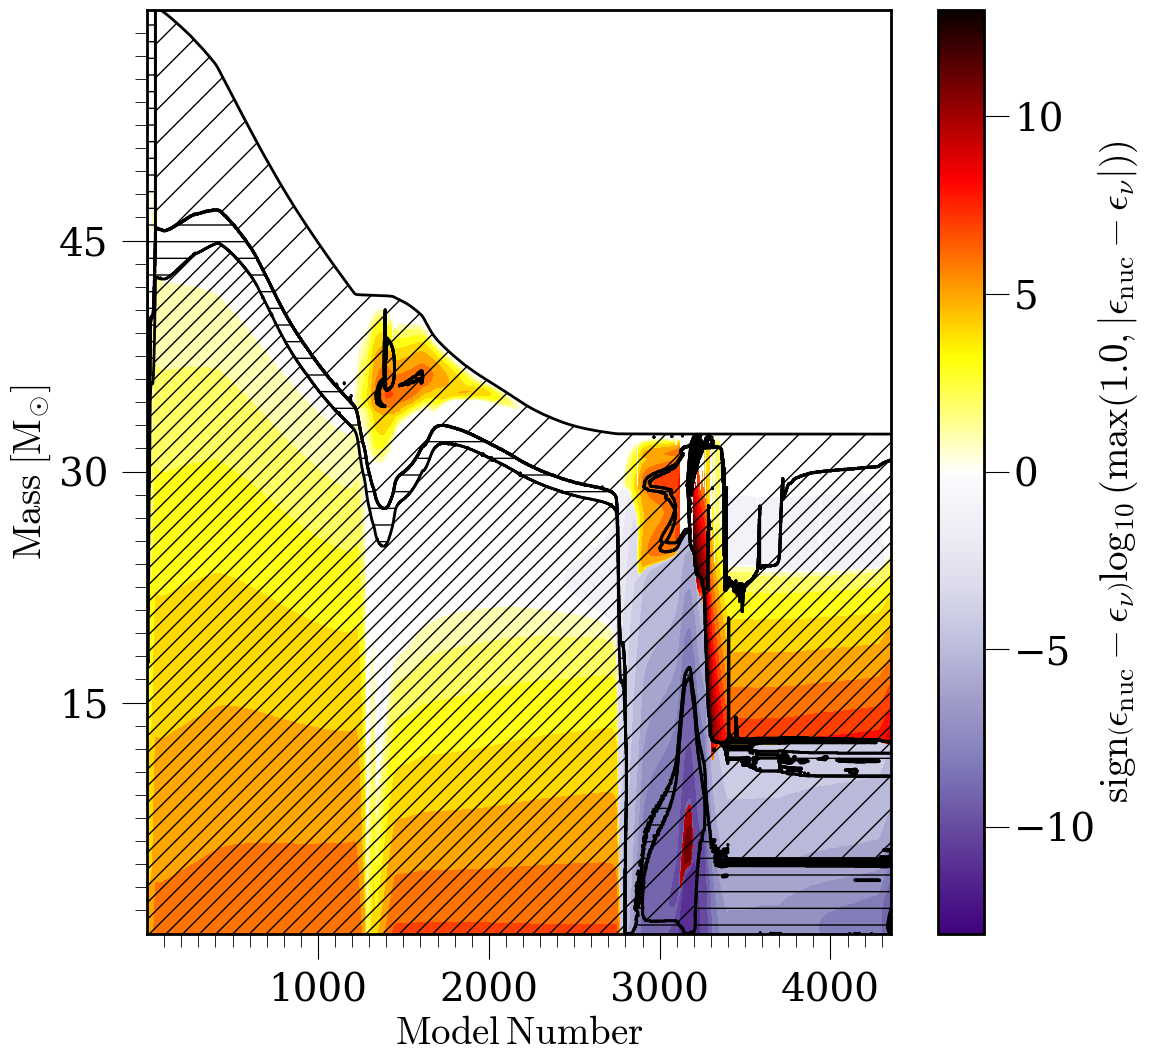

<Figure size 640x480 with 0 Axes>

In [37]:
yaxis = 'mass'
mod_max = None

fig, ax = plt.subplots(figsize=(12, 12))

p = mp.plot()
p.plotKip3(mm, show_mix=True, mix_hatch=True, show_mix_labels=False, yaxis=yaxis, mod_max=mod_max, fig=fig, ax=ax)

fig.suptitle(f'${test_m}\\,\\mathrm{{M}}_\\odot,\\,{test_p}\\,\\mathrm{{d}}$')
savefig(fig, f'kipp_mass_{test_m}_{test_p}')

2488.0


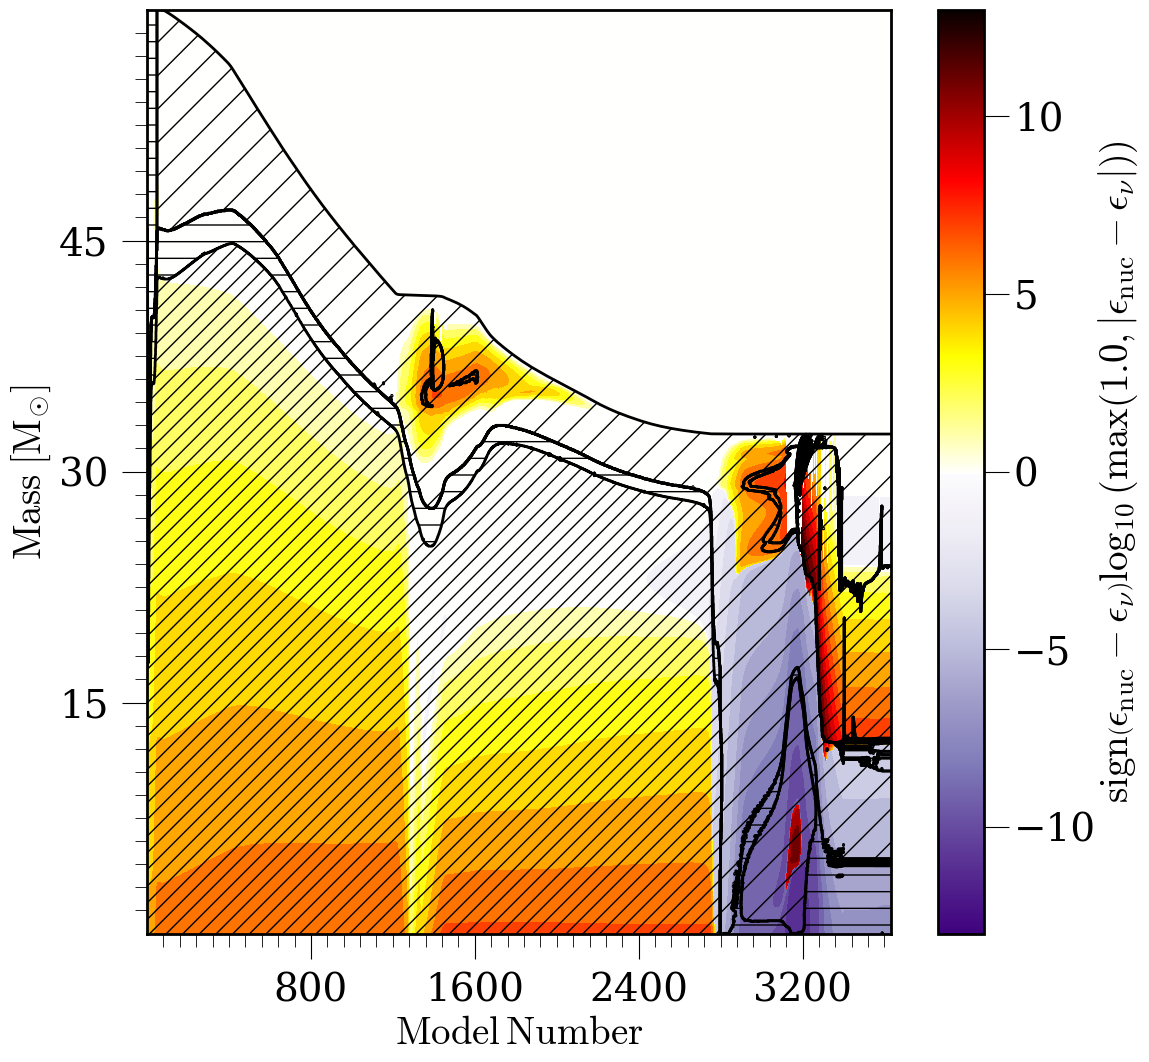

<Figure size 640x480 with 0 Axes>

In [80]:
yaxis = 'mass'
mod_max = 3633

fig, ax = plt.subplots(figsize=(12, 12))

p = mp.plot()
p.plotKip3(mm, show_mix=True, mix_hatch=True, show_mix_labels=False, yaxis=yaxis, mod_max=3633, fig=fig, ax=ax)

fig.suptitle(f'${test_m}\\,\\mathrm{{M}}_\\odot,\\,{test_p}\\,\\mathrm{{d}}$')
savefig(fig, f'kipp_mass_{test_m}_{test_p}')

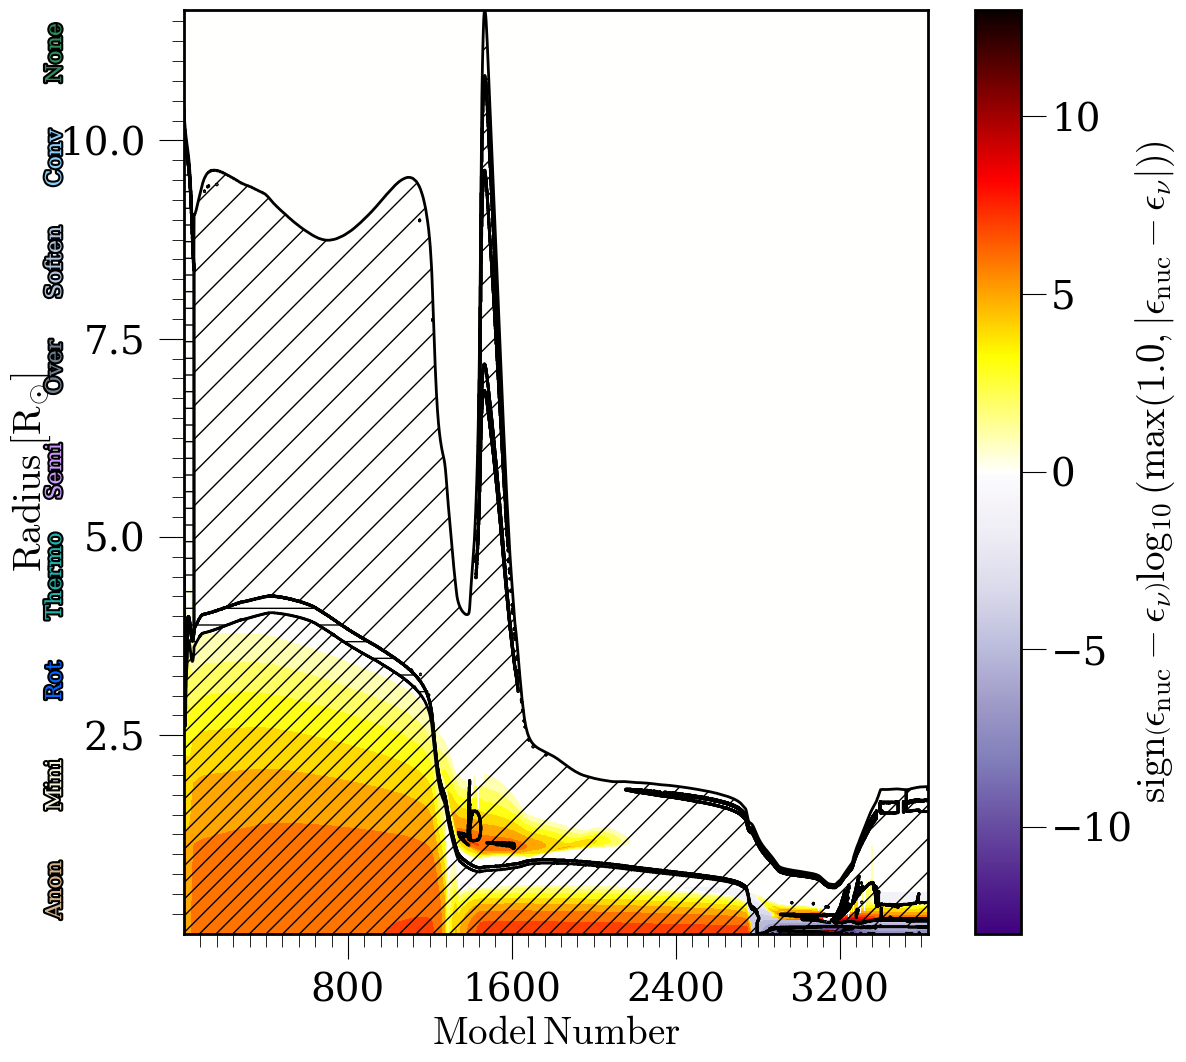

<Figure size 640x480 with 0 Axes>

In [71]:
p = mp.plot()
p.plotKip3(mm, show_mix=True, mix_hatch=True, yaxis='radius', mod_max=3633, )
savefig(fig, 'kipp_radius_60_080')

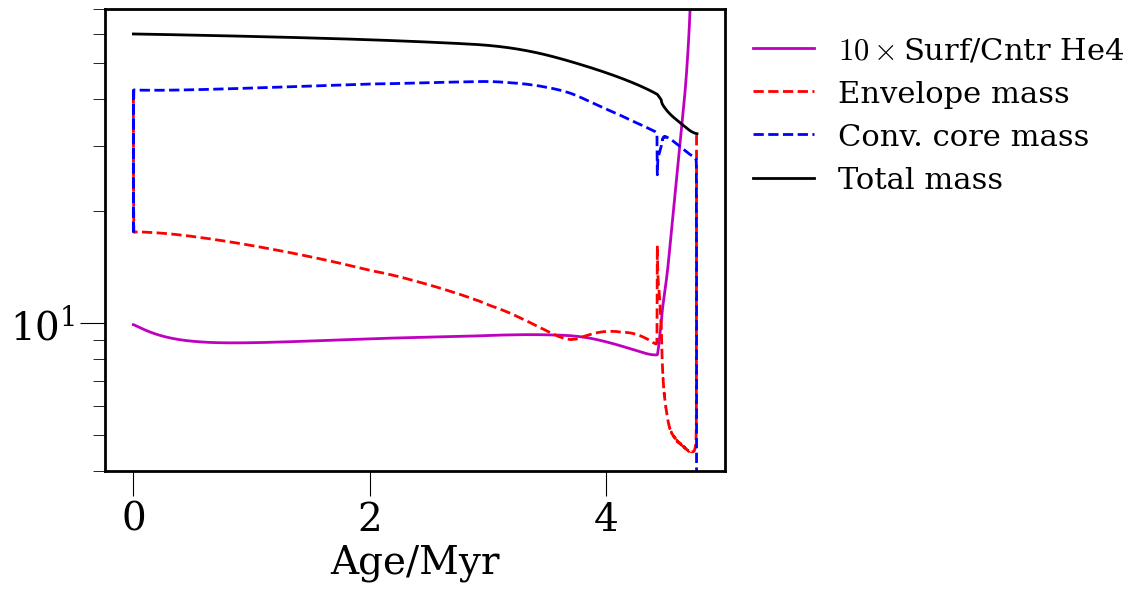

In [139]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(test_h.star_age/1e6, 10*test_h.surface_he4/test_h.center_he4, 'm-', label='$10\\times$Surf/Cntr He4')
ax.plot(test_h.star_age/1e6, test_h.star_mass-test_h.mass_conv_core, 'r--', label='Envelope mass')
ax.plot(test_h.star_age/1e6, test_h.mass_conv_core, 'b--', label='Conv. core mass')
ax.plot(test_h.star_age/1e6, test_h.star_mass, 'k-', label='Total mass')
ax.set_xlabel('Age/Myr')
ax.set_ylim(4, 70)
ax.set_yscale('log')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

In [ ]:
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[test_id][test_m][test_p]/'LOGS'))
mm.scrubHistory()

Text(0.5, 0.05, '$\\log\\rho$')

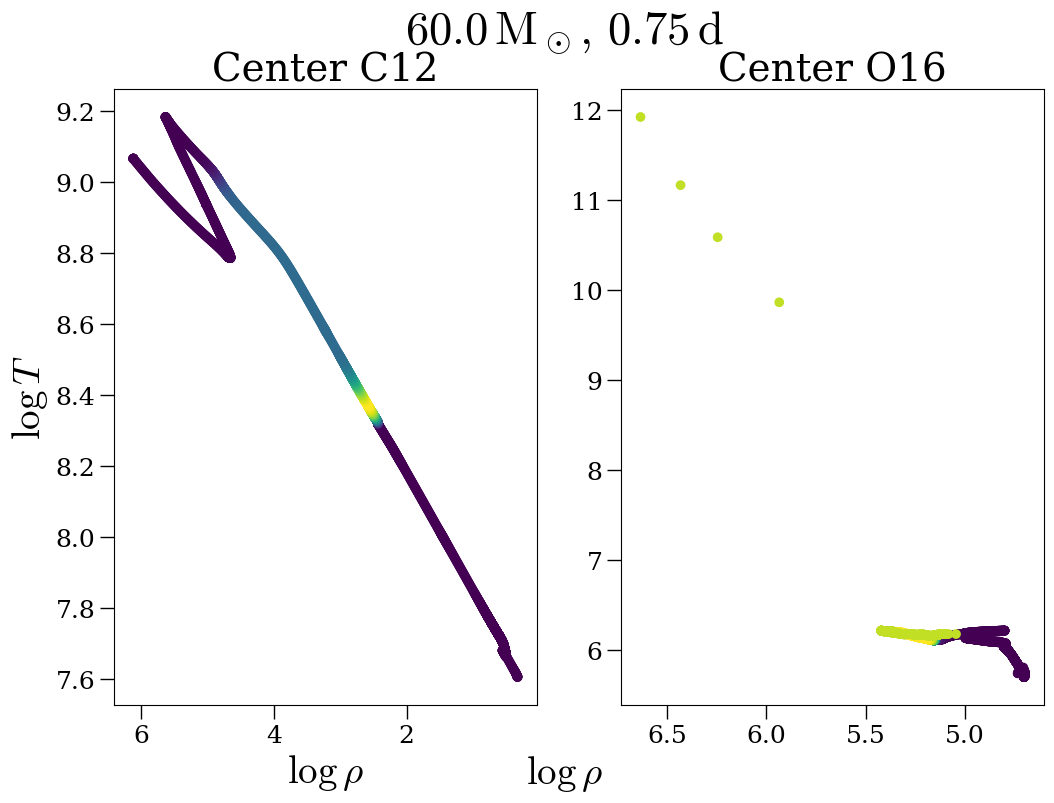

In [119]:
test_m = '60.0'
test_p = '0.75'
test_h = mr.MesaData(str(model_dicts[4][test_m][test_p]/'LOGS/history.data'))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 8))

ax1.scatter(test_h.log_center_Rho, test_h.log_center_T, c=test_h.center_c12)
ax1.invert_xaxis()
ax1.set_xlabel('$\\log \\rho$')
ax1.set_ylabel('$\\log T$')

ax1.set_title('Center C12')

ax2.scatter(test_h.log_Teff, test_h.log_L, c=test_h.center_o16)
ax2.invert_xaxis()
ax2.set_title('Center O16')

fig.suptitle(f'${test_m}\\,\\mathrm{{M}}_\\odot,\\,{test_p}\\,\\mathrm{{d}}$')
fig.text(0.5, 0.05, '$\\log\\rho$', ha='center', va='top')


The lest step of this run hits two stopping conditions: $dt/t_\mathrm{KH}<3\times10^{-4}$ and $dt<dt_\mathrm{min}$.

Text(0.5, 1.0, '$180.0\\,\\mathrm{M}_\\odot$')

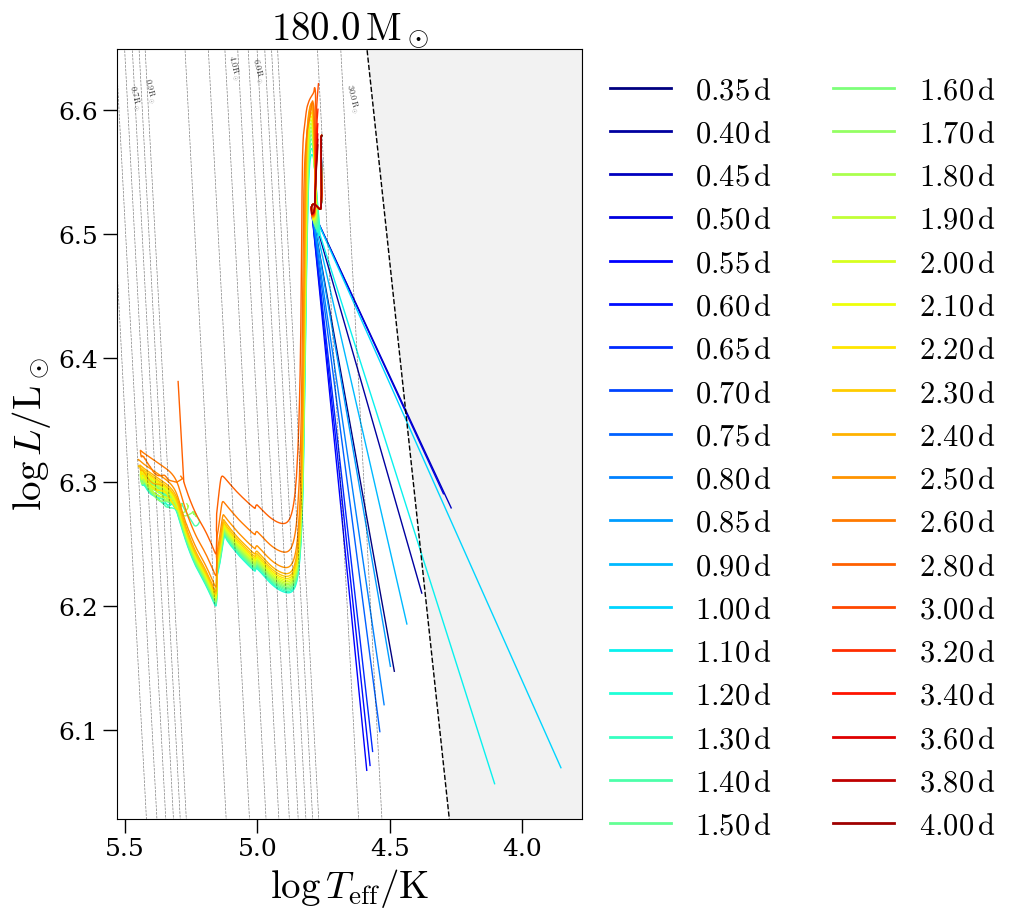

In [86]:
fig, ax = plt.subplots(figsize=(6, 10))
test_m = '180.0'

models_to_plot = [13]
model_style_list = ['-']
xlim = None
ylim = None
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

Text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$')

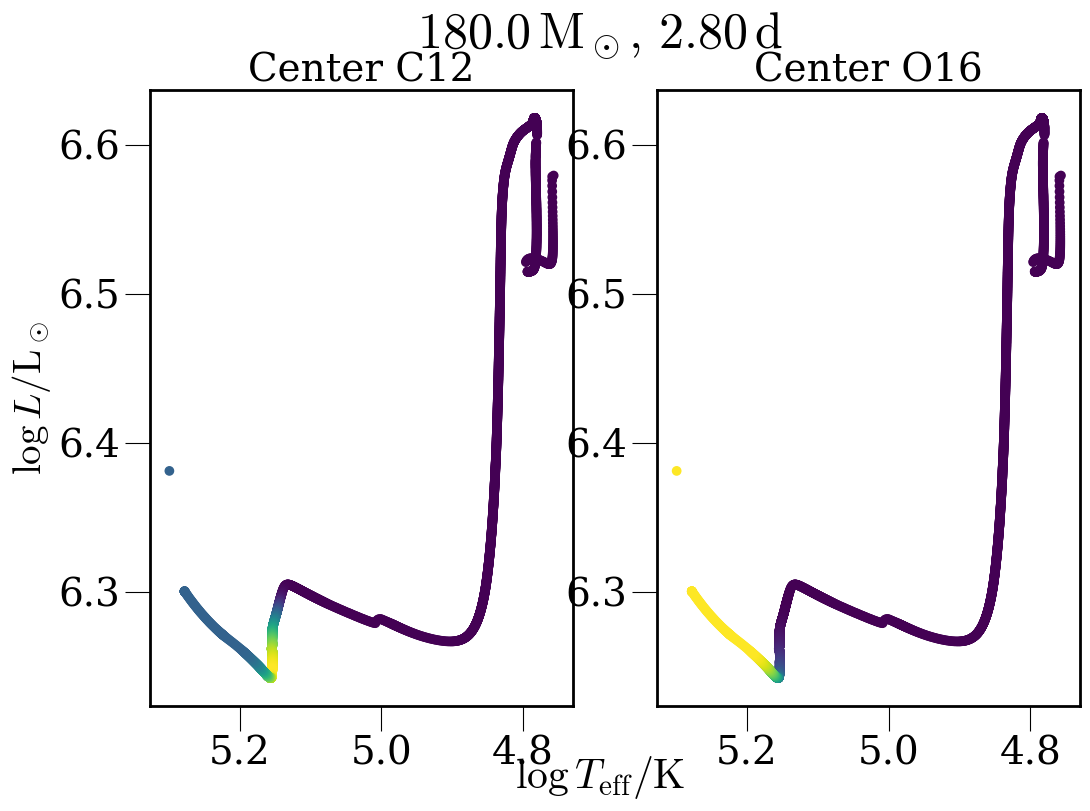

In [94]:
test_m = '180.0'
test_p = '2.80'
test_h = mr.MesaData(str(model_dicts[13][test_m][test_p]/'LOGS/history.data'))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 8))

ax1.scatter(test_h.log_Teff, test_h.log_L, c=test_h.center_c12)
ax1.invert_xaxis()
ax1.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
ax1.set_title('Center C12')

ax2.scatter(test_h.log_Teff, test_h.log_L, c=test_h.center_o16)
ax2.invert_xaxis()
ax2.set_title('Center O16')

fig.suptitle(f'${test_m}\\,\\mathrm{{M}}_\\odot,\\,{test_p}\\,\\mathrm{{d}}$')
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top')

In [260]:
test_id = 13
test_m = '180.0'
test_p = '2.80'
test_case = model_dicts[test_id][test_m][test_p]
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

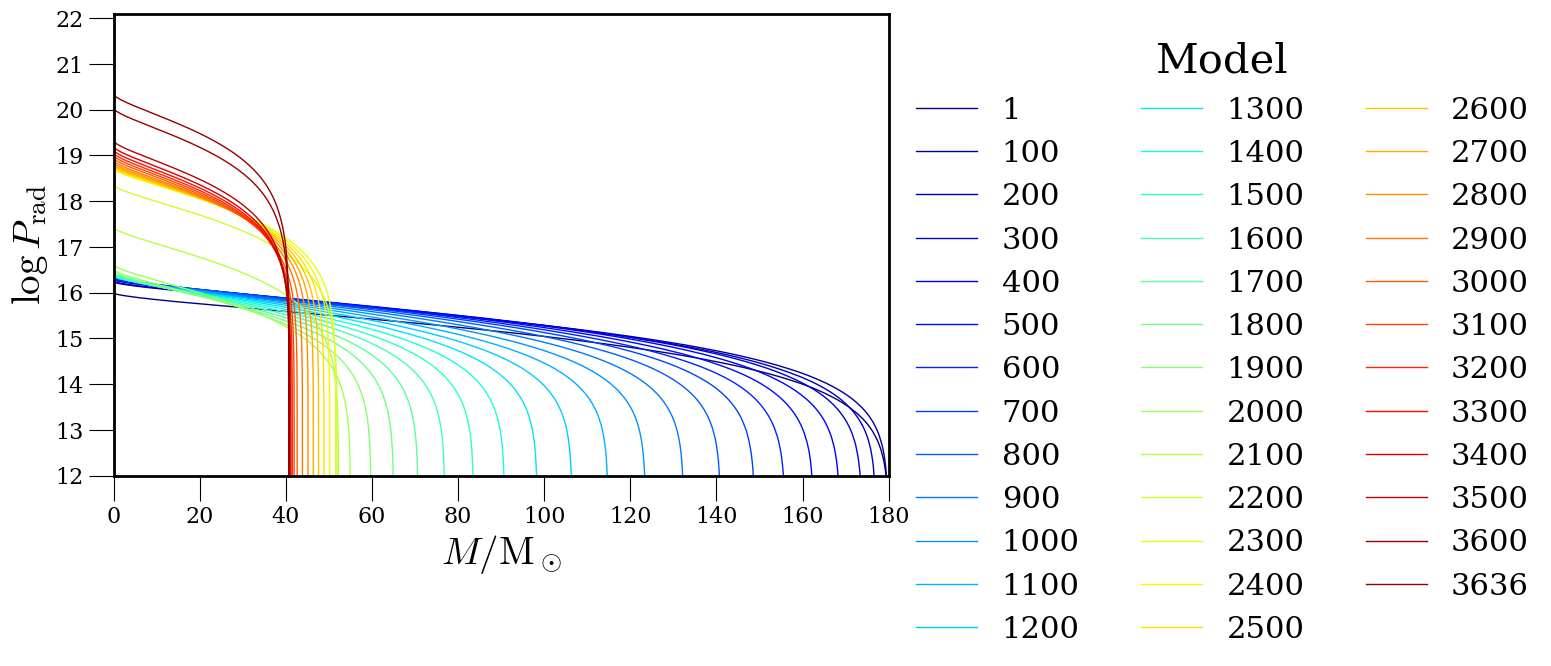

In [261]:
fig, ax = plt.subplots(figsize=(10,6))

for n in profile_numbers:
    prof = logs.profile_data(profile_number=n)
    c = cm.jet(prof.model_number/3700)
    ax.plot(prof.mass, np.log10(prof.prad), c=c, label=f'{prof.model_number}', lw=1)
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3, title='Model')
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\log P_\\mathrm{rad}$')
ax.set_ylim(12, 22.1)
ax.set_xlim(0, 180)
ax.tick_params(labelsize=16)
ax.set_yticks(np.arange(12, 23, 1))
    

In [263]:
test_id = 13
test_m = '180.0'
test_p = '2.80'
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[test_id][test_m][test_p]/'LOGS'))
mm.scrubHistory()

2296.0


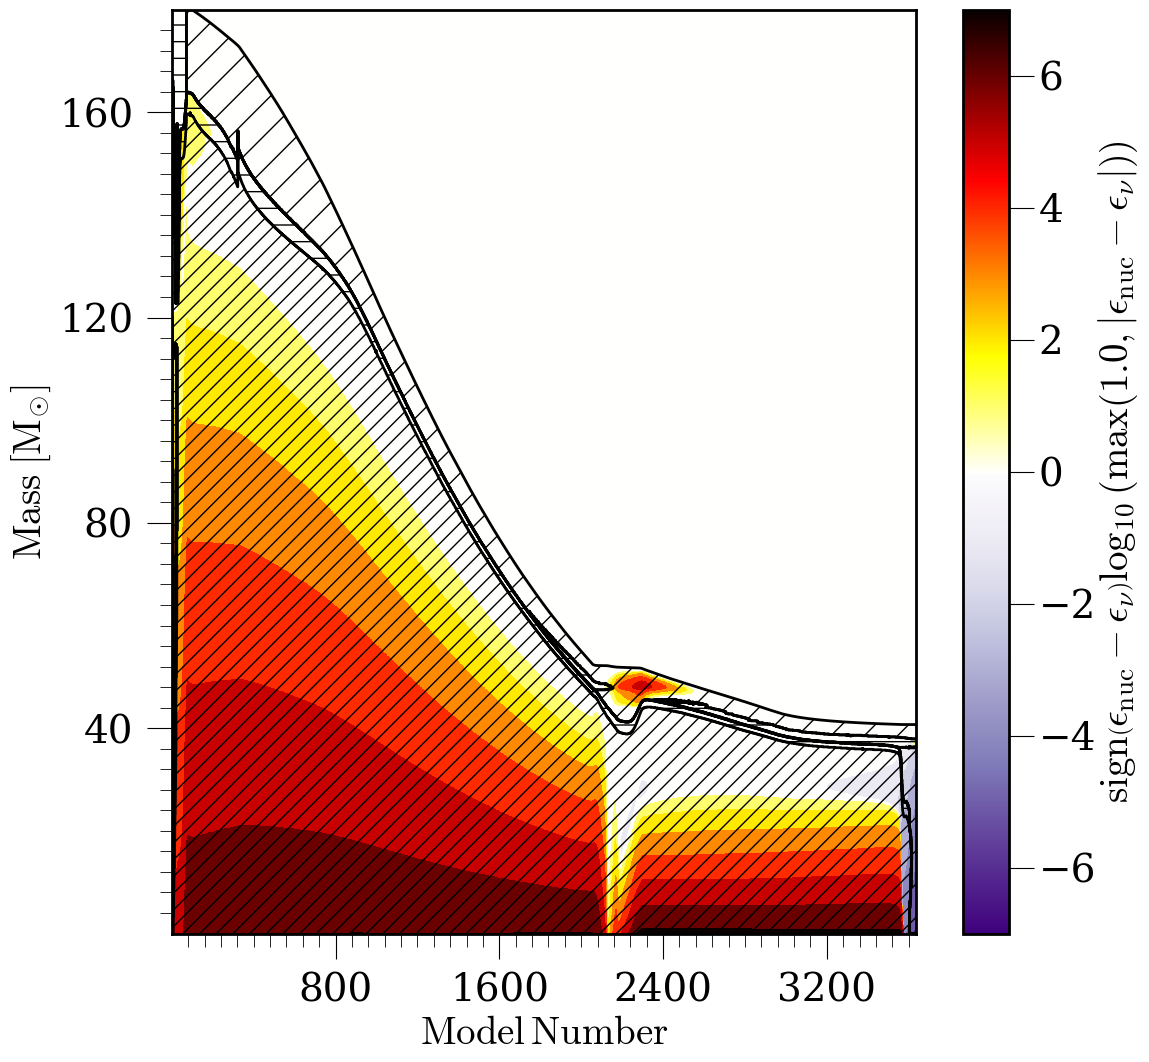

<Figure size 640x480 with 0 Axes>

In [264]:
yaxis = 'mass'
mod_max = 3633

fig, ax = plt.subplots(figsize=(12, 12))

p = mp.plot()
p.plotKip3(mm, show_mix=True, mix_hatch=True, show_mix_labels=False, yaxis=yaxis, fig=fig, ax=ax)

fig.suptitle(f'${test_m}\\,\\mathrm{{M}}_\\odot,\\,{test_p}\\,\\mathrm{{d}}$')
savefig(fig, f'kipp_mass_{test_m}_{test_p}')

In [266]:
test_id = 13
test_m = '180.0'
test_p = '2.60'
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[test_id][test_m][test_p]/'LOGS'))
mm.scrubHistory()

2379.0


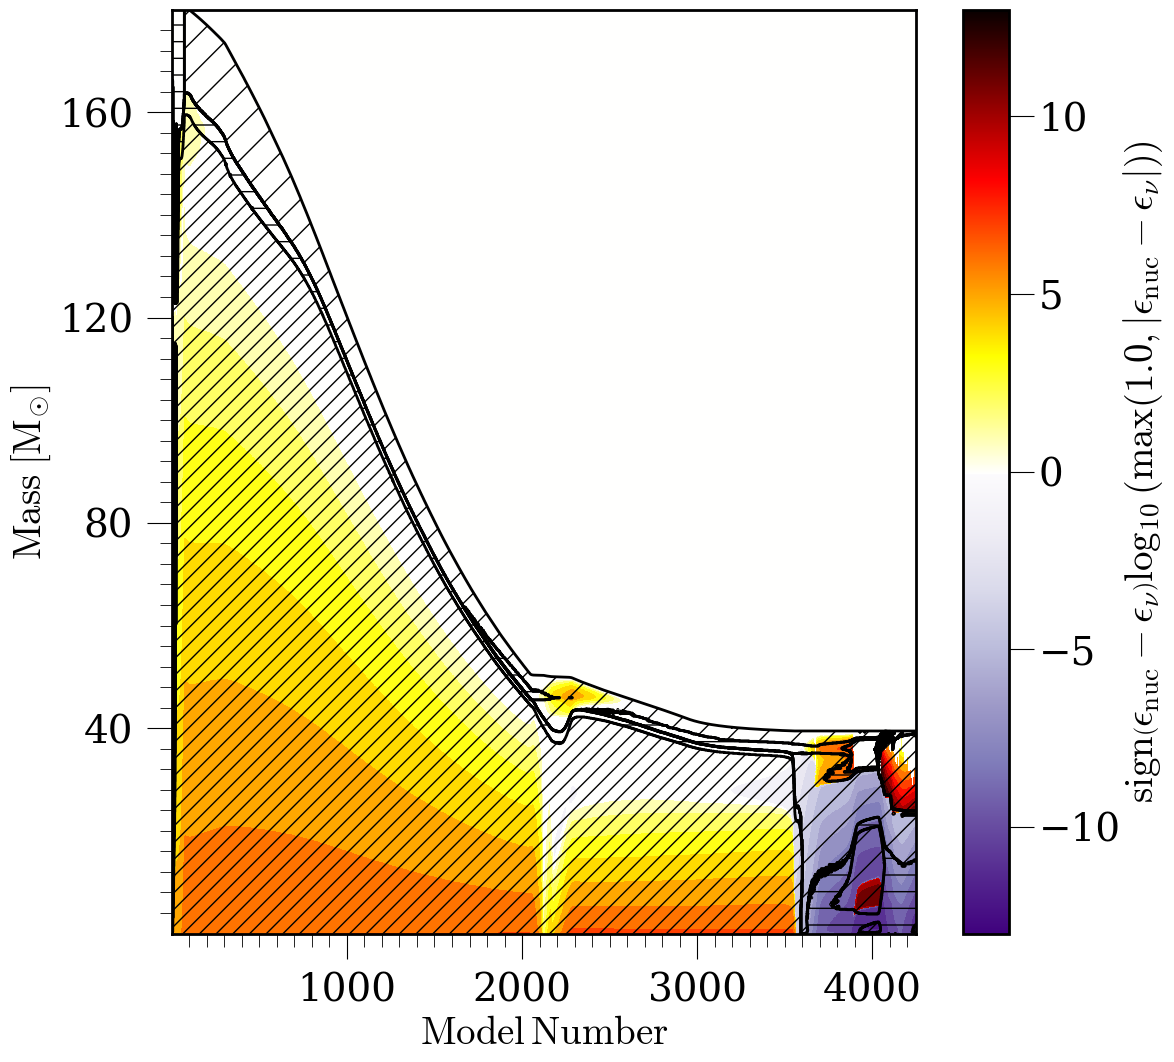

<Figure size 640x480 with 0 Axes>

In [267]:
yaxis = 'mass'

fig, ax = plt.subplots(figsize=(12, 12))

p = mp.plot()
p.plotKip3(mm, show_mix=True, mix_hatch=True, show_mix_labels=False, yaxis=yaxis, fig=fig, ax=ax)

fig.suptitle(f'${test_m}\\,\\mathrm{{M}}_\\odot,\\,{test_p}\\,\\mathrm{{d}}$')
savefig(fig, f'kipp_mass_{test_m}_{test_p}')

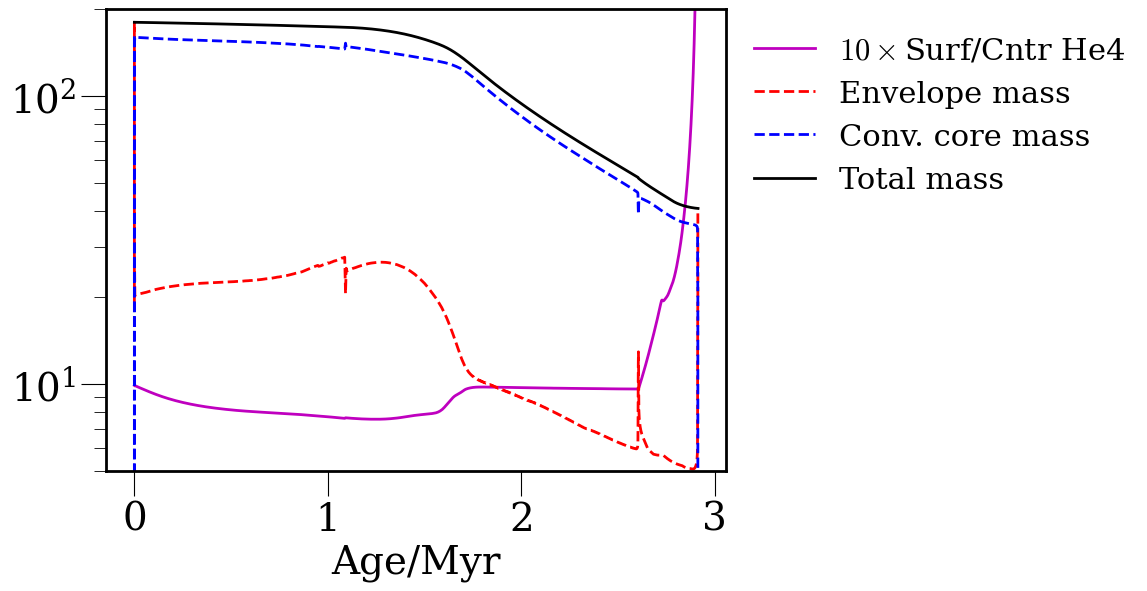

In [130]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(test_h.star_age/1e6, 10*test_h.surface_he4/test_h.center_he4, 'm-', label='$10\\times$Surf/Cntr He4')
ax.plot(test_h.star_age/1e6, test_h.star_mass-test_h.mass_conv_core, 'r--', label='Envelope mass')
ax.plot(test_h.star_age/1e6, test_h.mass_conv_core, 'b--', label='Conv. core mass')
ax.plot(test_h.star_age/1e6, test_h.star_mass, 'k-', label='Total mass')
ax.set_xlabel('Age/Myr')
ax.set_ylim(5, 200)
ax.set_yscale('log')
ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))

Text(0, 0.5, 'Center C12')

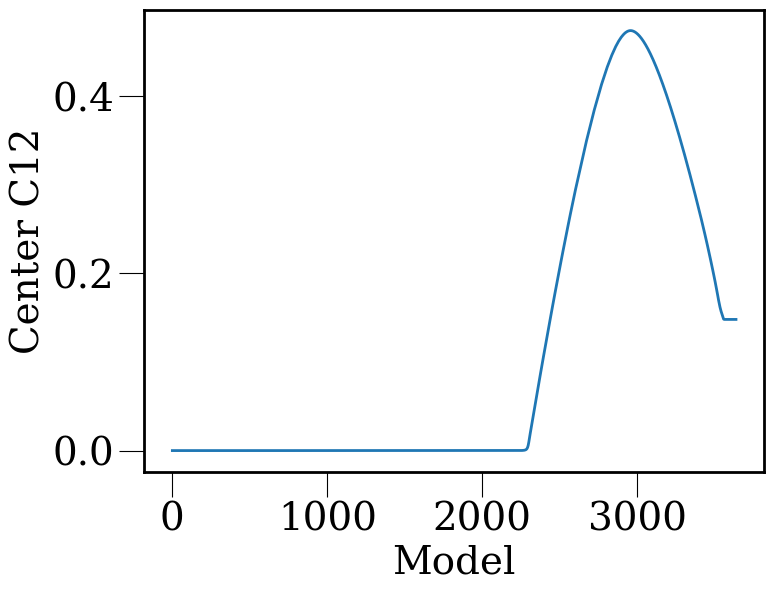

In [91]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(test_h.model_number, test_h.center_c12)
ax.set_xlabel('Model')
ax.set_ylabel('Center C12')

Text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$')

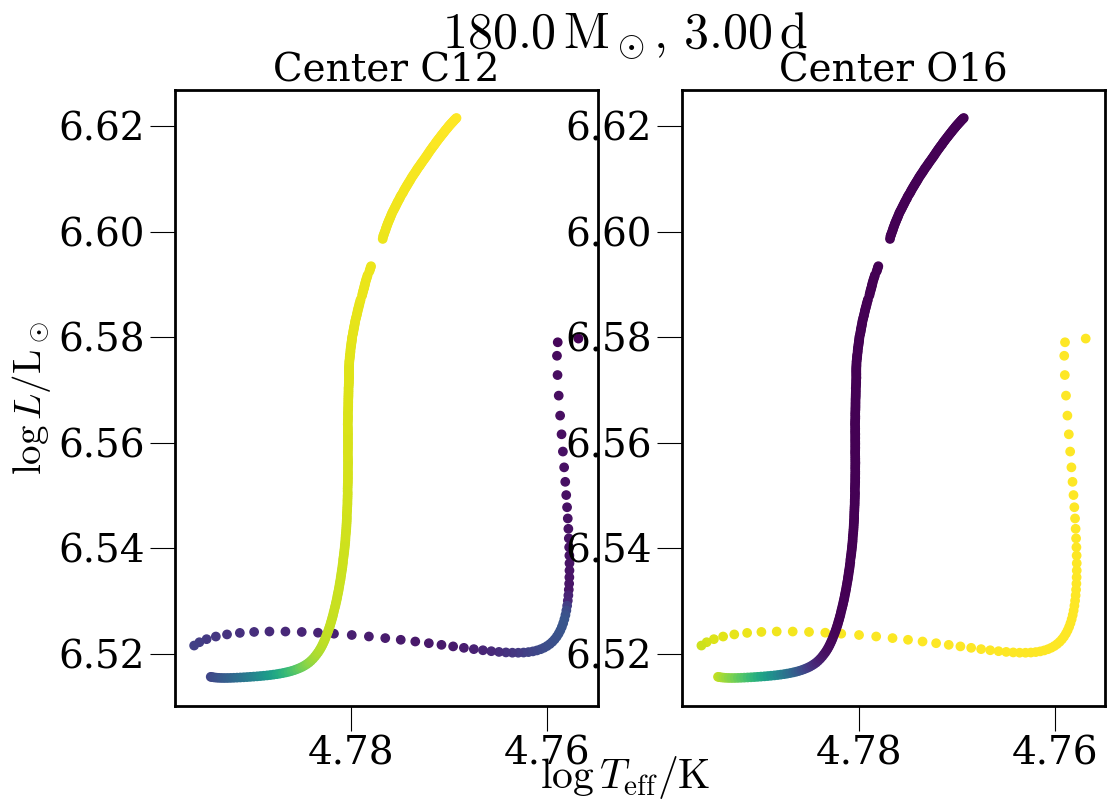

In [85]:
test_m = '180.0'
test_p = '3.00'
test_h = mr.MesaData(str(model_dicts[13][test_m][test_p]/'LOGS/history.data'))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 8))

ax1.scatter(test_h.log_Teff, test_h.log_L, c=test_h.center_c12)
ax1.invert_xaxis()
ax1.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
ax1.set_title('Center C12')

ax2.scatter(test_h.log_Teff, test_h.log_L, c=test_h.center_o16)
ax2.invert_xaxis()
ax2.set_title('Center O16')

fig.suptitle(f'${test_m}\\,\\mathrm{{M}}_\\odot,\\,{test_p}\\,\\mathrm{{d}}$')
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top')

The lest step of this run hits $dt<dt_\mathrm{min}$.

Text(0.5, 1.0, '$280.0\\,\\mathrm{M}_\\odot$')

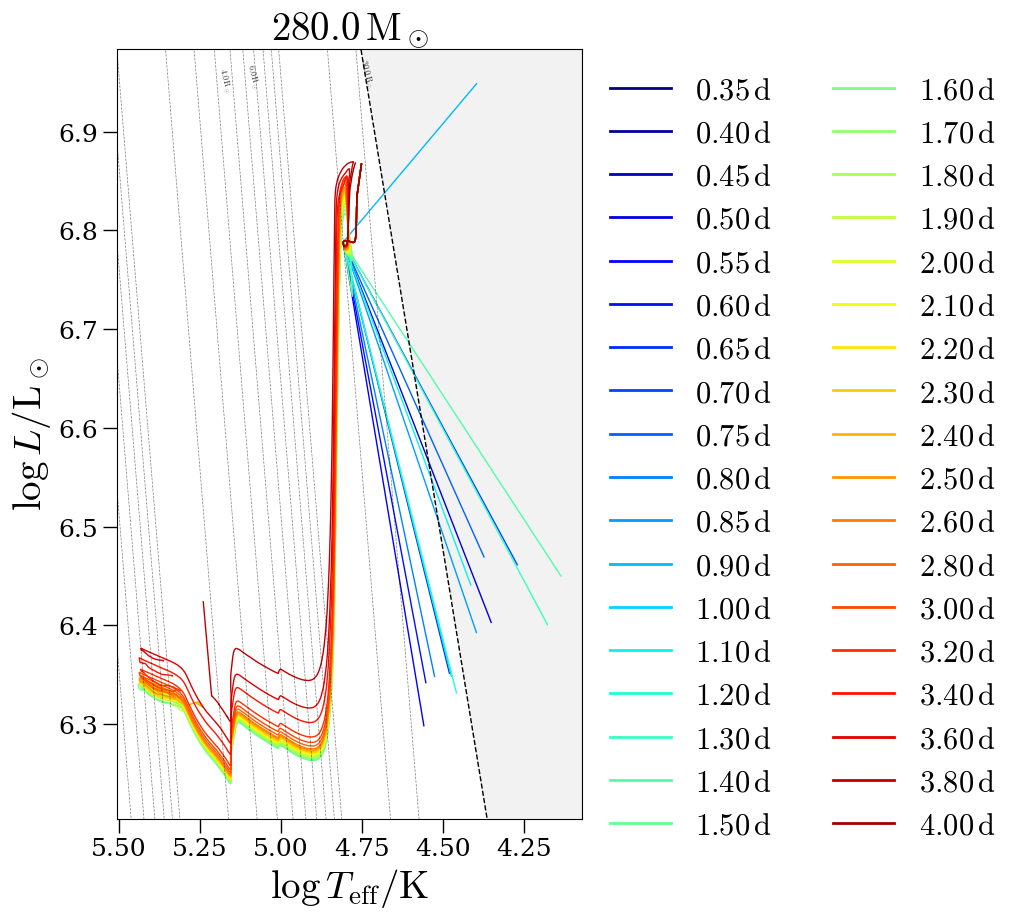

In [101]:
fig, ax = plt.subplots(figsize=(6, 10))
test_m = '280.0'

models_to_plot = [18]
model_style_list = ['-']
xlim = None
ylim = None
legend = True
labelx = True
labely = True

ax = hr_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )
ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

Text(0.5, 1.0, '$280.0\\,\\mathrm{M}_\\odot$')

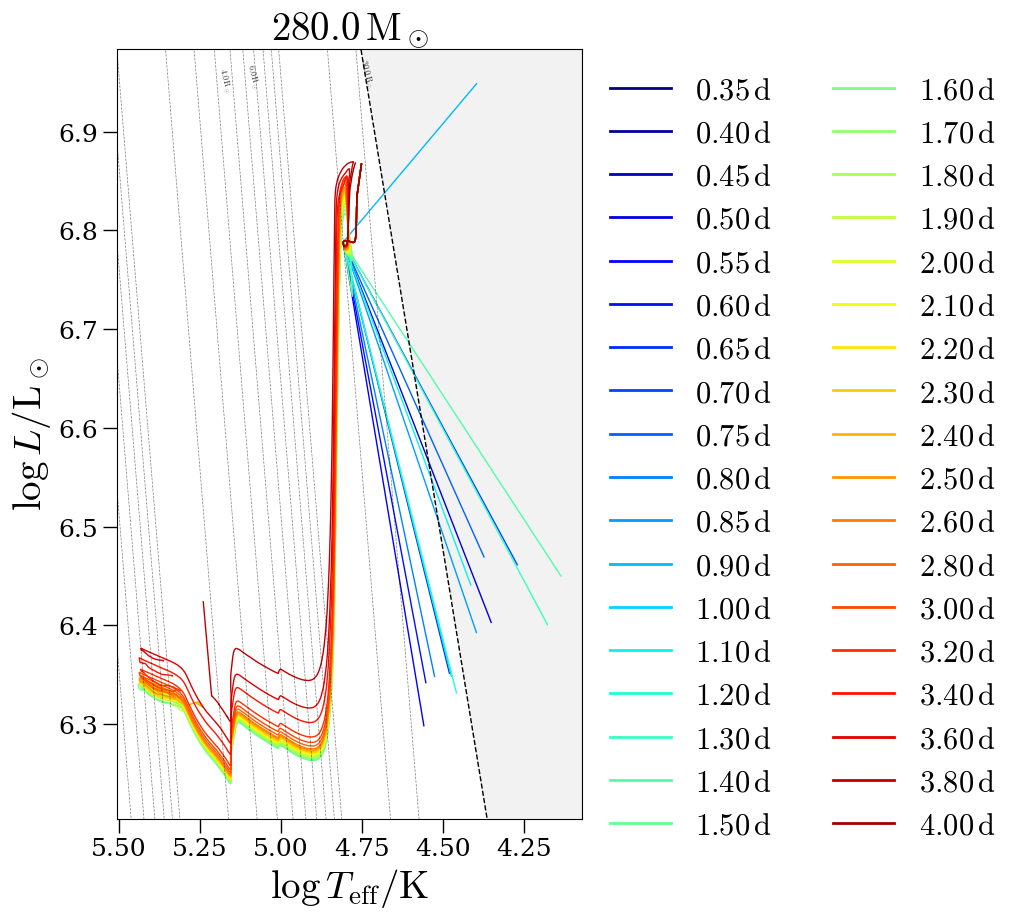

In [ ]:
fig, ax = plt.subplots(figsize=(6, 10))
test_m = '280.0'

models_to_plot = [18]
model_style_list = ['-']
xlim = None
ylim = None
legend = True
labelx = True
labely = True

settings = dict(
    x='log_Teff',
    y='log_L',
    invert_xaxis=True,
    invert_yaxis=False,
    model_dict_list=model_dict_list,
    model_styles=model_style_list,
    model_labels=model_label_list,
    label_period=legend
    )

ax = history_plot(ax, **settings)

ax.set_title(f'${test_m}\,\mathrm{{M}}_\\odot$')

Text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$')

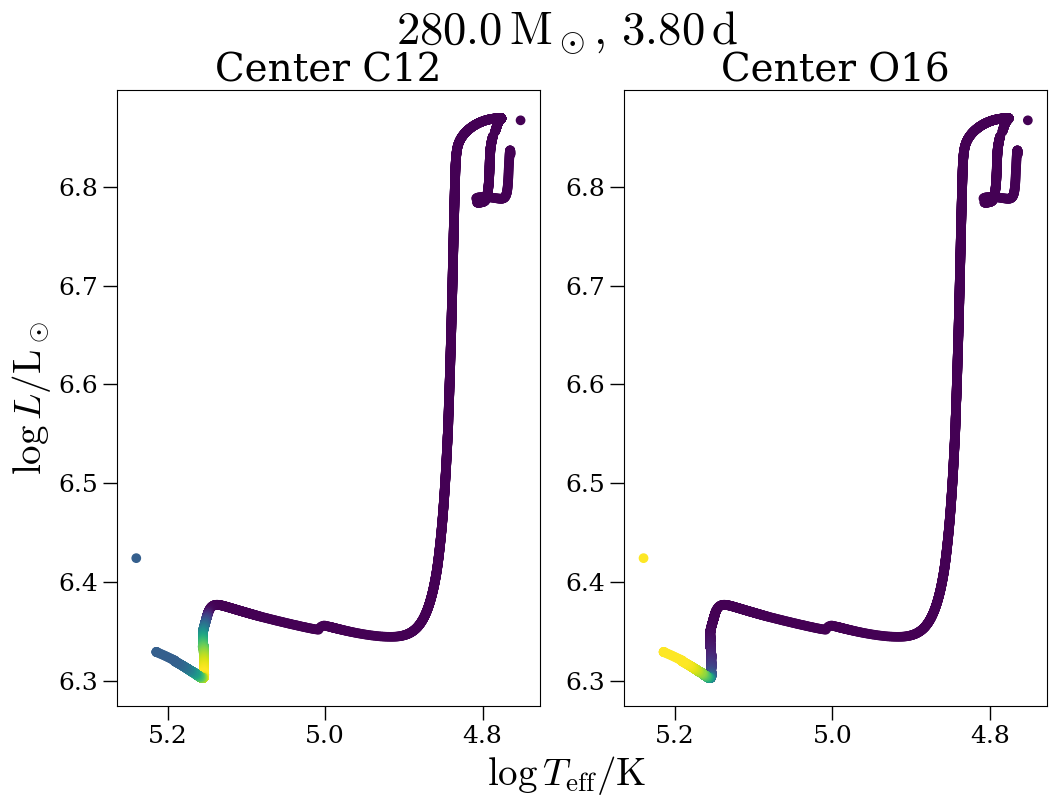

In [103]:
test_m = '280.0'
test_p = '3.80'
test_h = mr.MesaData(str(model_dicts[18][test_m][test_p]/'LOGS/history.data'))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 8))

ax1.scatter(test_h.log_Teff, test_h.log_L, c=test_h.center_c12)
ax1.invert_xaxis()
ax1.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
ax1.set_title('Center C12')

ax2.scatter(test_h.log_Teff, test_h.log_L, c=test_h.center_o16)
ax2.invert_xaxis()
ax2.set_title('Center O16')

fig.suptitle(f'${test_m}\\,\\mathrm{{M}}_\\odot,\\,{test_p}\\,\\mathrm{{d}}$')
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top')

In [110]:
test_h.bulk_names

('model_number',
 'num_zones',
 'star_age',
 'star_age_sec',
 'log_dt',
 'star_mass',
 'log_xmstar',
 'star_mdot',
 'log_abs_mdot',
 'mass_conv_core',
 'mix_type_1',
 'mix_qtop_1',
 'mix_type_2',
 'mix_qtop_2',
 'mix_type_3',
 'mix_qtop_3',
 'mix_type_4',
 'mix_qtop_4',
 'mix_type_5',
 'mix_qtop_5',
 'mix_type_6',
 'mix_qtop_6',
 'mix_type_7',
 'mix_qtop_7',
 'mix_type_8',
 'mix_qtop_8',
 'mix_type_9',
 'mix_qtop_9',
 'mix_type_10',
 'mix_qtop_10',
 'mix_type_11',
 'mix_qtop_11',
 'mix_type_12',
 'mix_qtop_12',
 'mix_type_13',
 'mix_qtop_13',
 'mix_type_14',
 'mix_qtop_14',
 'mix_type_15',
 'mix_qtop_15',
 'mix_type_16',
 'mix_qtop_16',
 'mix_type_17',
 'mix_qtop_17',
 'mix_type_18',
 'mix_qtop_18',
 'mix_type_19',
 'mix_qtop_19',
 'mix_type_20',
 'mix_qtop_20',
 'burn_type_1',
 'burn_qtop_1',
 'burn_type_2',
 'burn_qtop_2',
 'burn_type_3',
 'burn_qtop_3',
 'burn_type_4',
 'burn_qtop_4',
 'burn_type_5',
 'burn_qtop_5',
 'burn_type_6',
 'burn_qtop_6',
 'burn_type_7',
 'burn_qtop_7',
 'b

Text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$')

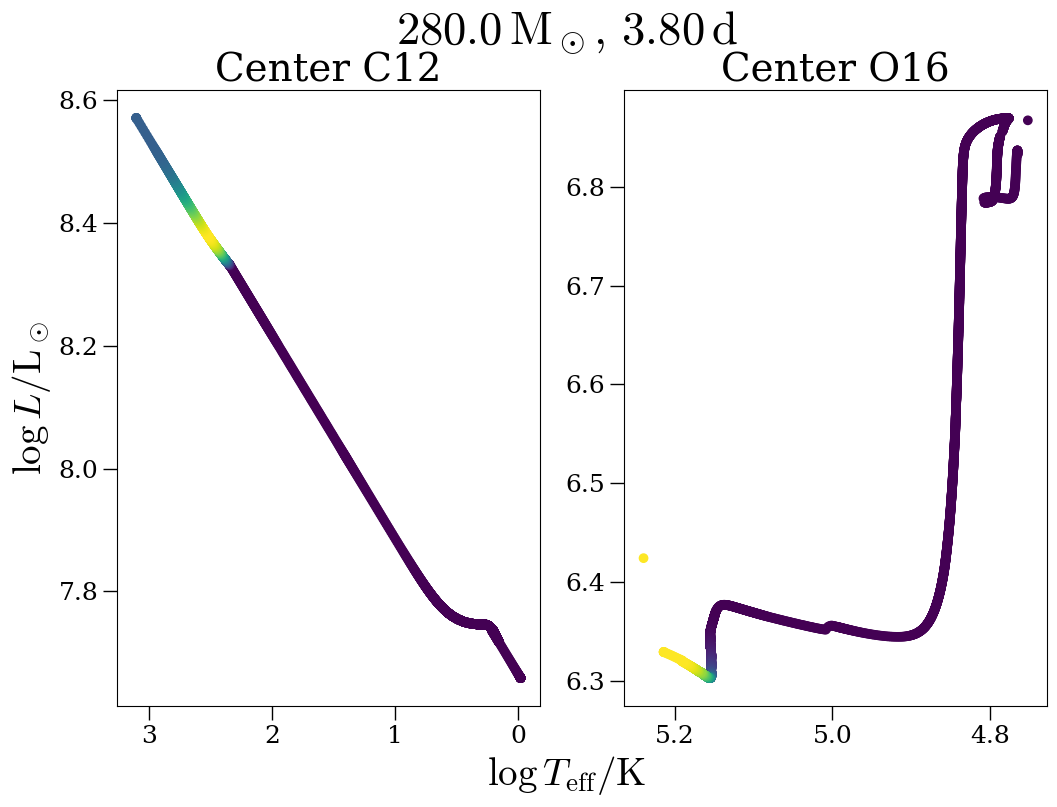

In [120]:
test_m = '280.0'
test_p = '3.80'
test_h = mr.MesaData(str(model_dicts[18][test_m][test_p]/'LOGS/history.data'))

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 8))

ax1.scatter(test_h.log_center_Rho, test_h.log_center_T, c=test_h.center_c12)
ax1.invert_xaxis()
ax1.set_ylabel('$\\log L/\\mathrm{L}_\\odot$')
ax1.set_title('Center C12')

ax2.scatter(test_h.log_Teff, test_h.log_L, c=test_h.center_o16)
ax2.invert_xaxis()
ax2.set_title('Center O16')

fig.suptitle(f'${test_m}\\,\\mathrm{{M}}_\\odot,\\,{test_p}\\,\\mathrm{{d}}$')
fig.text(0.5, 0.05, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', ha='center', va='top')

The lest step of this run hits $dt<dt_\mathrm{min}$.

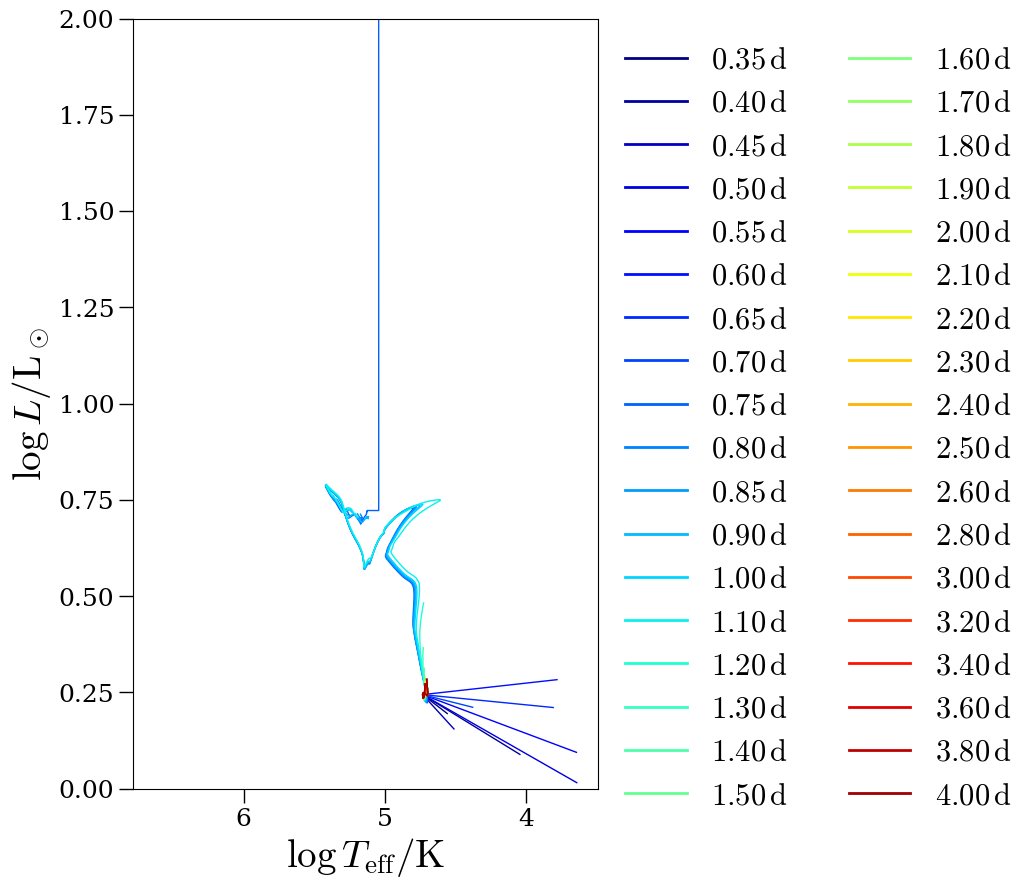

In [40]:
fig, ax = plt.subplots(figsize=(6, 10))

models_to_plot = [4]
model_style_list = ['-']
xlim = None
ylim = (0, 2)
legend = True
labelx = True
labely = True

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=[4],
    model_style_list=['-'],
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

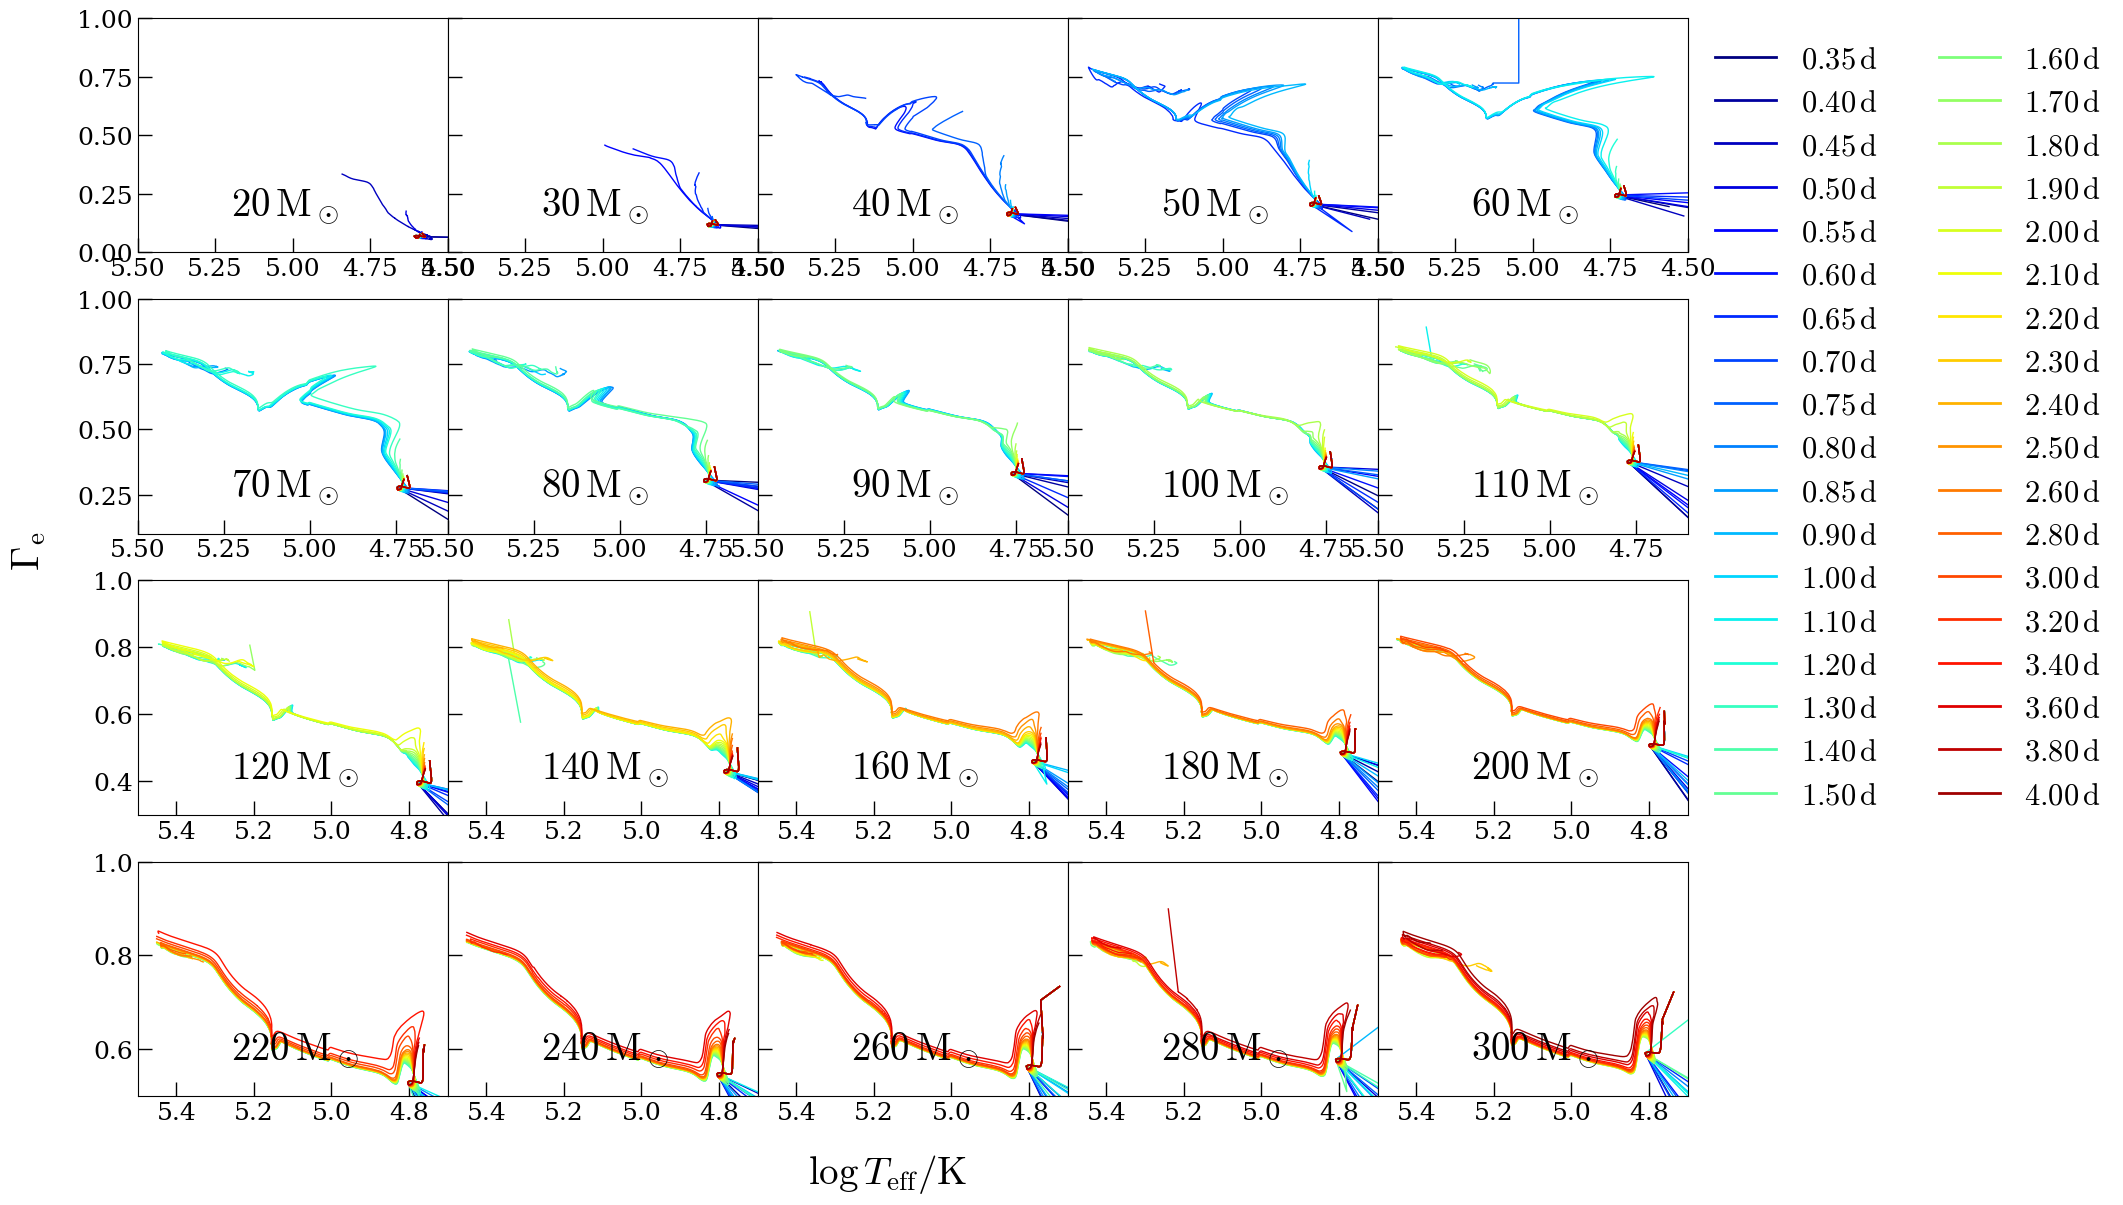

In [72]:
fig, axes = plt.subplots(4, 5, figsize=(20, 14))
fig.subplots_adjust(wspace=0)

xlim = (5.5, 4.5)
ylim = (0, 1)

# PLOT M=20
ax = axes[0, 0]
models_to_plot = [0]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(0.3, 0.2, '$20\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=50
ax = axes[0, 1]
models_to_plot = [1]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$30\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=40
ax = axes[0, 2]
models_to_plot = [2]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$40\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=50
ax = axes[0, 3]
models_to_plot = [3]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$50\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=60
ax = axes[0, 4]
models_to_plot = [4]
model_style_list = ['-']
legend = True
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$60\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

xlim = (5.5, 4.6)
ylim = (0.1, 1)

# PLOT M=70
ax = axes[1, 0]
models_to_plot = [5]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(0.3, 0.2, '$70\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=80
ax = axes[1, 1]
models_to_plot = [6]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$80\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=90
ax = axes[1, 2]
models_to_plot = [7]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$90\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=100
ax = axes[1, 3]
models_to_plot = [8]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$100\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=110
ax = axes[1, 4]
models_to_plot = [9]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$110\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

xlim = (5.5, 4.7)
ylim = (0.3, 1)

# PLOT M=120
ax = axes[2, 0]
models_to_plot = [10]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(0.3, 0.2, '$120\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=140
ax = axes[2, 1]
models_to_plot = [11]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$140\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=160
ax = axes[2, 2]
models_to_plot = [12]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$160\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=180
ax = axes[2, 3]
models_to_plot = [13]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$180\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=200
ax = axes[2, 4]
models_to_plot = [14]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.2, '$200\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

xlim = (5.5, 4.7)
ylim = (0.5, 1)

# PLOT M=220
ax = axes[3, 0]
models_to_plot = [15]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.text(0.3, 0.8, '$220\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=240
ax = axes[3, 1]
models_to_plot = [16]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.8, '$240\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=260
ax = axes[3, 2]
models_to_plot = [17]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.8, '$260\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=280
ax = axes[3, 3]
models_to_plot = [18]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.8, '$280\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

# PLOT M=300
ax = axes[3, 4]
models_to_plot = [19]
model_style_list = ['-']
legend = False
labelx = False
labely = False

ax = hre_diagram_tracks(
    ax=ax,
    models_to_plot=models_to_plot,
    model_style_list=model_style_list,
    xlim=xlim,
    ylim=ylim,
    legend=legend,
    labelx=labelx,
    labely=labely
    )

ax.tick_params(direction='in')
ax.set_yticklabels([])
ax.text(0.3, 0.8, '$300\\,\\mathrm{M}_\\odot$', va='center', ha='left', transform=ax.transAxes)

#######################################

fig.text(0.5, 0.07, '$\\log T_\\mathrm{eff}/\\mathrm{K}$', va='top', ha='center')
fig.text(0.08, 0.5, '$\\Gamma_\\mathrm{e}$', rotation=90, va='center', ha='right')

savefig(fig, 'hre_allp_mass_comparison')

## Core properties

In [36]:
# Select models
models_to_plot = np.arange(0, len(model_dicts), 1)
model_dict_list = model_dicts[models_to_plot]
print(f'Loading {model_dict_list}')

# Collect periods
all_periods = []
for dict_ in model_dict_list:
    for k1 in dict_.keys():
        for k2 in dict_[k1].keys():
            all_periods.append(k2)
all_periods = np.unique(all_periods)
all_periods = all_periods[np.argsort([float(p) for p in all_periods])][1:]
print(all_periods)

Loading [{'20.0': {'2.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w3.030d-05'), '0.85': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w8.556d-05'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w4.545d-05'), '0.70': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w1.039d-04'), '0.75': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w9.696d-05'), '2.30': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w3.162d-05'), '1.70': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w4.278d-05'), '1.10': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w6.

In [106]:


# Get core properties


p_plot = np.zeros((len(model_dict_list), len(all_periods), 7))
for j, p_key in enumerate(all_periods):
    print(f'Working for p={p_key}')
    p = float(p_key)    
    for i, dict_ in enumerate(model_dict_list):
        m_key = list(dict_.keys())[0]
        print(f'Working for m={m_key}')
        model_path = dict_[m_key][p_key]
        try:
            logs = mr.MesaLogDir(str(model_path/'LOGS'))
        except:
            continue
        else:
            final_h1_cntr = logs.profile_data(profile_number=logs.profile_numbers[-1]).h1[-1]
            if final_h1_cntr > 1e-7:
                print(f'Not CHE! m={m_key}, p={p_key}')
                is_che = False
                is_crit_at_zams = False
                #p_plot[i, j] = [np.nan]*5 + [is_crit_at_zams, is_che]
            else:
                is_che = True
            mass, spin, w = get_core_mass_spin_w(logs, core_def_iso)
            
            h = mr.MesaData(str(model_path/'LOGS/history.data'))
            r_prezams = h.radius[0]
            i_zams = np.searchsorted(h.surf_avg_v_rot, 0, side='right')
            
            is_crit_at_zams = False
            try:
                r_zams = h.radius[i_zams]
            except IndexError:
                is_crit_at_zams = True
                r_zams = h.radius[i_zams-1]        
            p_plot[i, j] = [mass, spin, w, r_zams, r_prezams, is_crit_at_zams, is_che]    

Loading [{'20.0': {'2.40': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w3.030d-05'), '0.85': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w8.556d-05'), '1.60': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w4.545d-05'), '0.70': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w1.039d-04'), '0.75': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w9.696d-05'), '2.30': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w3.162d-05'), '1.70': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w4.278d-05'), '1.10': PosixPath('/mnt/ceph/users/ldesa/mesa_che_grids/sse_carbon/001_md1_m20_zsundiv10_04y0_03dy/m2.000d+01_w6.

Not CHE! m=20.0, p=0.40
Working for m=30.0
Not CHE! m=30.0, p=0.40
Working for m=40.0
Not CHE! m=40.0, p=0.40
Working for m=50.0
Not CHE! m=50.0, p=0.40
Working for m=60.0
Not CHE! m=60.0, p=0.40
Working for m=70.0
Not CHE! m=70.0, p=0.40
Working for m=80.0
Not CHE! m=80.0, p=0.40
Working for m=90.0
Not CHE! m=90.0, p=0.40
Working for m=100.0
Not CHE! m=100.0, p=0.40
Working for m=110.0
Not CHE! m=110.0, p=0.40
Working for m=120.0
Not CHE! m=120.0, p=0.40
Working for m=140.0
Not CHE! m=140.0, p=0.40
Working for m=160.0
Working for m=180.0
Not CHE! m=180.0, p=0.40
Working for m=200.0
Not CHE! m=200.0, p=0.40
Working for m=220.0
Working for m=240.0
Not CHE! m=240.0, p=0.40
Working for m=260.0
Not CHE! m=260.0, p=0.40
Working for m=280.0
Working for m=300.0
Not CHE! m=300.0, p=0.40
Working for p=0.45
Working for m=20.0
Working for m=30.0
Not CHE! m=30.0, p=0.45
Working for m=40.0
Not CHE! m=40.0, p=0.45
Working for m=50.0
Not CHE! m=50.0, p=0.45
Working for m=60.0
Not CHE! m=60.0, p=0.45


KeyboardInterrupt: 

In [74]:
test_id = 19
test_m = '300.0'
test_p = '4.00'
test_case = model_dicts[test_id][test_m][test_p]
logs  = mr.MesaLogDir(str(test_case/'LOGS'))
profile_numbers = logs.profile_numbers

In [94]:
ns

array([42, 43, 44, 45, 46])

(0.0, 60.0)

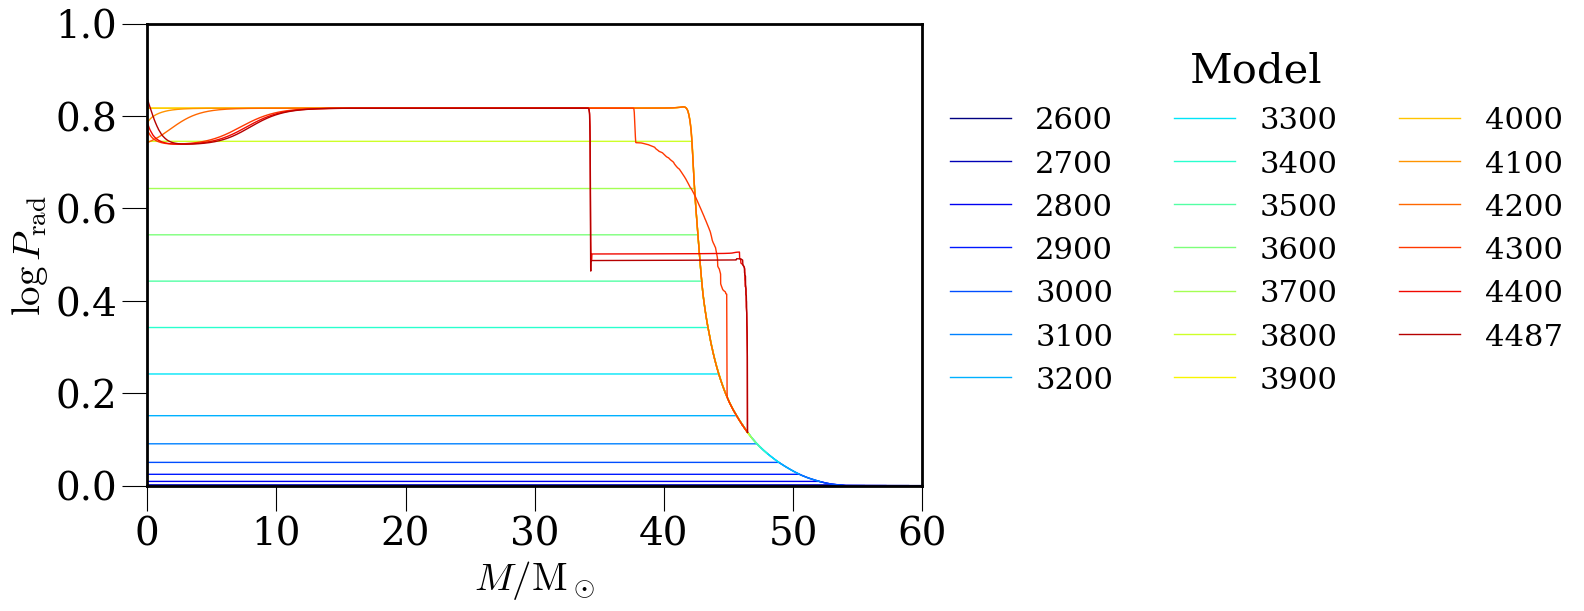

In [111]:
fig, ax = plt.subplots(figsize=(10,6))

ns = profile_numbers[-20:]
for i, n in enumerate(ns):
    prof = logs.profile_data(profile_number=n)
    c = cm.jet(i/len(ns))
    #ax.plot(prof.mass, prof.ne20, c=c, label=f'{prof.model_number}', lw=1)
    #ax.plot(prof.mass, prof.c12, c=c, label=f'{prof.model_number}', lw=1, ls='--')
    ax.plot(prof.mass, prof.o16, c=c, label=f'{prof.model_number}', lw=1, ls='-')
ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False, ncol=3, title='Model')
ax.set_xlabel('$M/\\mathrm{M}_\\odot$')
ax.set_ylabel('$\\log P_\\mathrm{rad}$')
ax.set_ylim(0, 1)
ax.set_xlim(0, 60)
#ax.tick_params(labelsize=16)
#ax.set_yticks(np.arange(12, 23, 1))
    

In [99]:
test_id = 19
test_m = '300.0'
test_p = '4.00'
mm = mp.MESA()
mm.loadHistory(f=str(model_dicts[test_id][test_m][test_p]/'LOGS'))
mm.scrubHistory()

2698.0


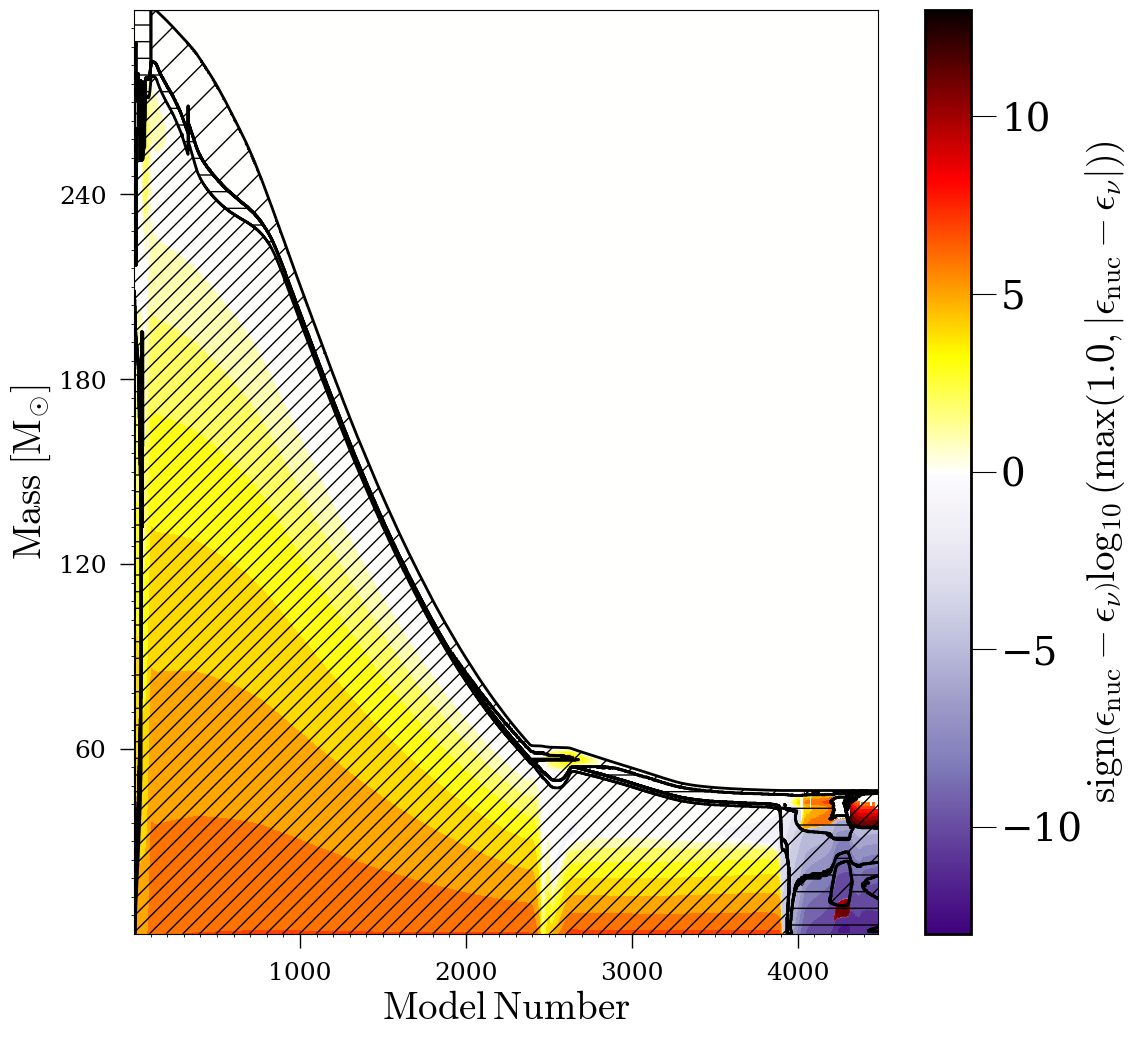

<Figure size 640x480 with 0 Axes>

In [100]:
yaxis = 'mass'

fig, ax = plt.subplots(figsize=(12, 12))

p = mp.plot()
p.plotKip3(mm, show_mix=True, mix_hatch=True, show_mix_labels=False, yaxis=yaxis, fig=fig, ax=ax)

fig.suptitle(f'${test_m}\\,\\mathrm{{M}}_\\odot,\\,{test_p}\\,\\mathrm{{d}}$')
savefig(fig, f'kipp_mass_{test_m}_{test_p}')

In [112]:
#np.save(f'nb{nb_id}_p_plot_extended.npy', p_plot)
final_mass_array = np.load('carbon_exh_core_properties.npy')

In [113]:
mass_guide_str = [list(dict_.keys())[0] for dict_ in model_dict_list]
mass_guide_float = np.array([float(m) for m in mass_guide_str])

period_guide_str = all_periods
period_guide_float = np.array([float(p) for p in period_guide_str])

In [114]:
from scipy.interpolate import interp1d

In [115]:
from math import nan

Below we build a core mass interpolator.

In [224]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 0] 

    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [0]
        p_arr = [1]

    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    interpolator_dict[m_key] = interpolator     
    
pzams_mcore_interpolator_dict = interpolator_dict

0.0 20.0
0.05 30.0
0.1 40.0
0.15 50.0
0.2 60.0
0.25 70.0
0.3 80.0
0.35 90.0
0.4 100.0
0.45 110.0
0.5 120.0
0.55 140.0
0.6 160.0
0.65 180.0
0.7 200.0
0.75 220.0
0.8 240.0
0.85 260.0
0.9 280.0
0.95 300.0


/tmp/ipykernel_457131/685806815.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,0][che_mask], marker='o', c=c, zorder=1, label=m_key)
/tmp/ipykernel_457131/685806815.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[~che_mask], final_mass_array[:,i,3][~che_mask], marker='x', c=c, zorder=2)


Text(0.5, 1.0, 'Data + $P$ interpolation')

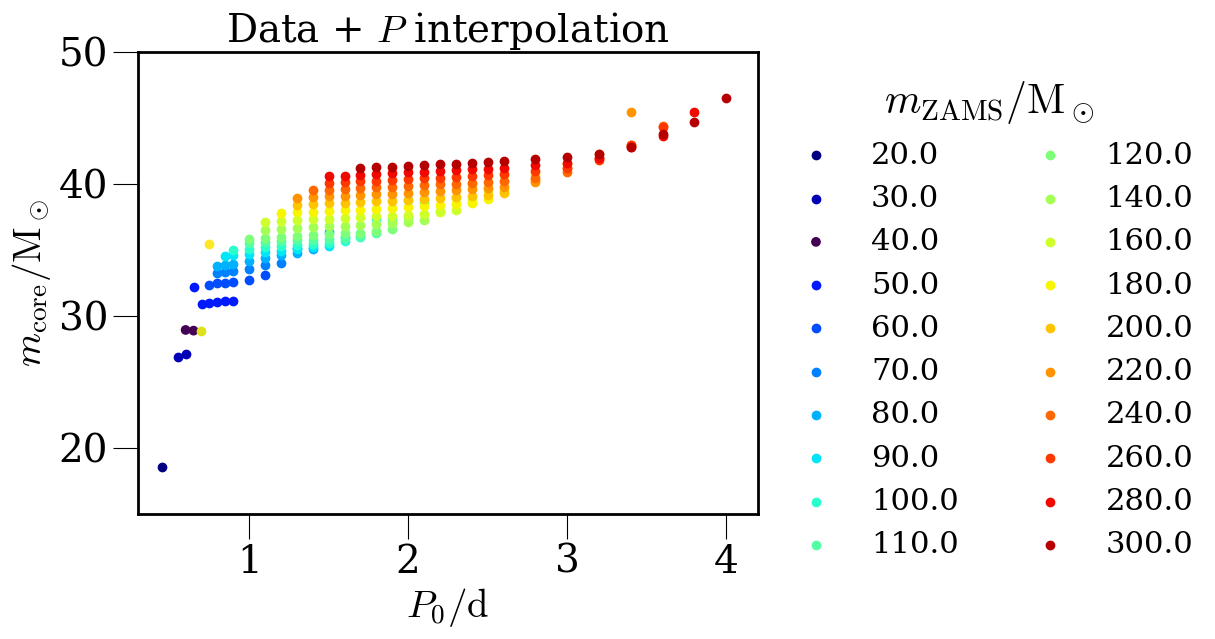

In [225]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator_dict = pzams_mcore_interpolator_dict

for i, m_key in enumerate(mass_guide_str):
    c = cm.jet(i/len(mass_guide_str))
    print(i/len(mass_guide_str), m_key)
    interpolator = interpolator_dict[m_key]
    plot_ps = np.linspace(0, 4, 100)
    che_mask = np.array(final_mass_array[:,i,9], bool)
    ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,0][che_mask], marker='o', c=c, zorder=1, label=m_key)
    ax.scatter(period_guide_float[~che_mask], final_mass_array[:,i,3][~che_mask], marker='x', c=c, zorder=2)
    #ax.plot(plot_ps, interpolator(plot_ps), c=c, zorder=0, lw=1)
    
ax.set_ylim(15, 50)
ax.set_xlim(0.3, 4.2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_title('Data + $P$ interpolation')

#savefig(fig, 'pzams_mcore_data')

/tmp/ipykernel_457131/747176874.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,1][che_mask], marker='o', c=c, zorder=1, label=m_key)


Text(0.5, 1.0, 'Data + $P$ interpolation')

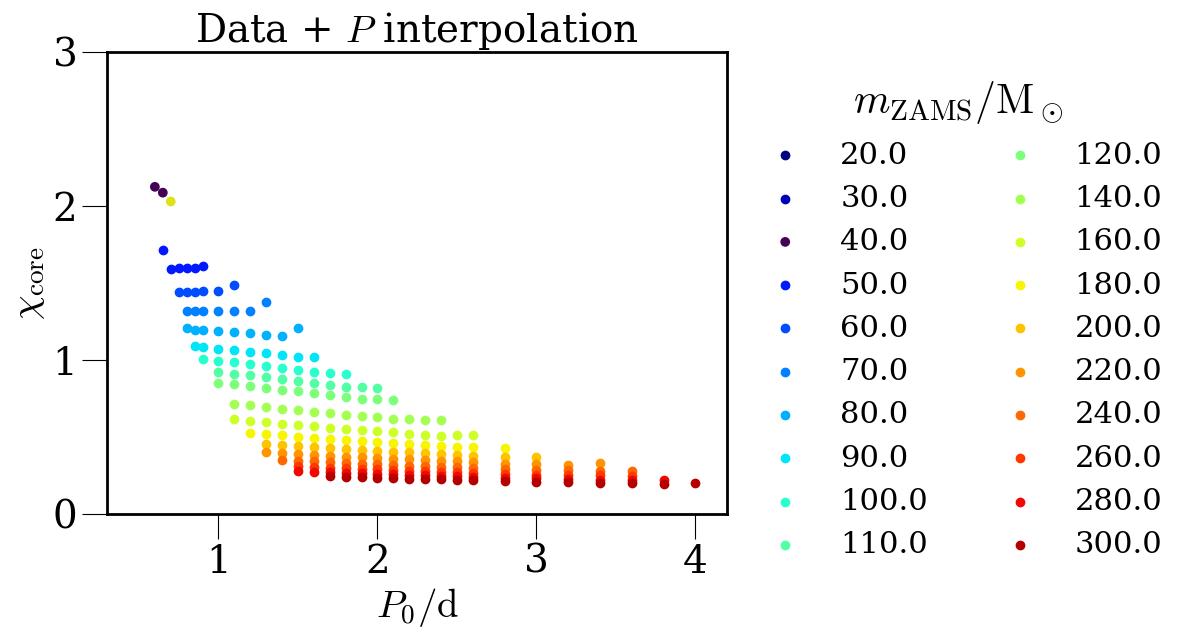

In [146]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator_dict = pzams_mcore_interpolator_dict

for i, m_key in enumerate(mass_guide_str):
    c = cm.jet(i/len(mass_guide_str))
    interpolator = interpolator_dict[m_key]
    plot_ps = np.linspace(0, 4, 100)
    che_mask = np.array(final_mass_array[:,i,9], bool)
    ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,1][che_mask], marker='o', c=c, zorder=1, label=m_key)
    #ax.scatter(period_guide_float[~che_mask], final_mass_array[:,i,3][~che_mask], marker='x', c=c, zorder=2)
    #ax.plot(plot_ps, interpolator(plot_ps), c=c, zorder=0, lw=1)
    
ax.set_ylim(0, 3)
ax.set_xlim(0.3, 4.2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$\\chi_\\mathrm{core}$')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_title('Data + $P$ interpolation')

#savefig(fig, 'pzams_mcore_data')

In [218]:
def mzams_mcore_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = pzams_mcore_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )
    
    m_core = interpolator(m_zams)
    
    return m_core  

Text(0.5, 1.0, 'Data + $P,m_\\mathrm{ZAMS}$ interpolation')

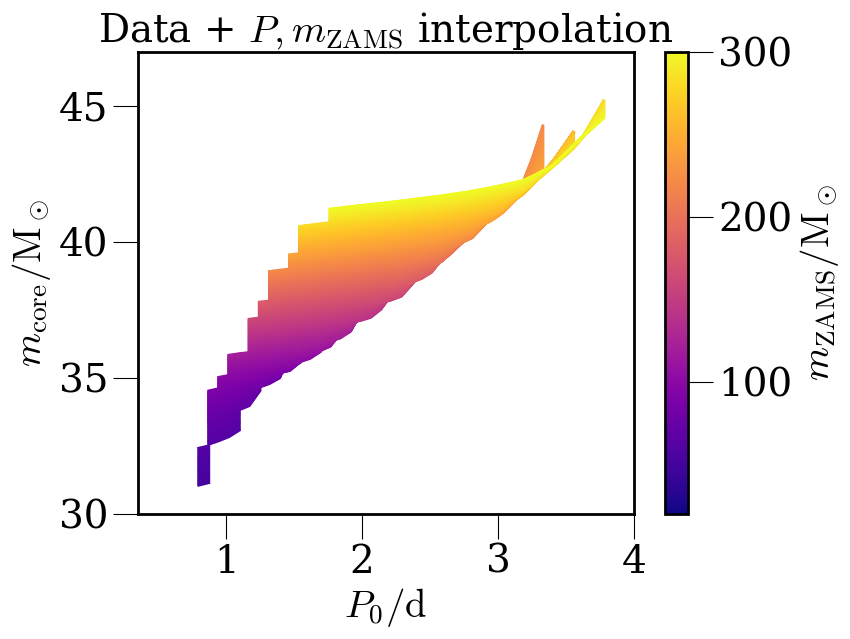

In [306]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator = mzams_mcore_interpolator
cmap = cm.plasma

test_masses = np.linspace(20, 300, 500)
test_periods = np.linspace(0.35, 4)

for i, m in enumerate(test_masses):
    c = cmap(i/len(test_masses))
    m_cores = [interpolator(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.set_ylim(30, 47)
ax.set_xlim(0.35, 4)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(test_masses), vmax=max(test_masses)), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

ax.set_title('Data + $P,m_\\mathrm{ZAMS}$ interpolation')

#savefig(fig, 'pzams_mcore_ip')

Below we build a ZAMS radius interpolator.

In [182]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 6] 

    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]

    if len(y_arr) == 0:
        y_arr = [0]
        p_arr = [1]
            
    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    interpolator_dict[m_key] = interpolator     
    
pzams_rzams_interpolator_dict = interpolator_dict

/tmp/ipykernel_457131/3142632089.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,6][che_mask], marker='o', c=c, zorder=1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Data + $P$ interpolation')

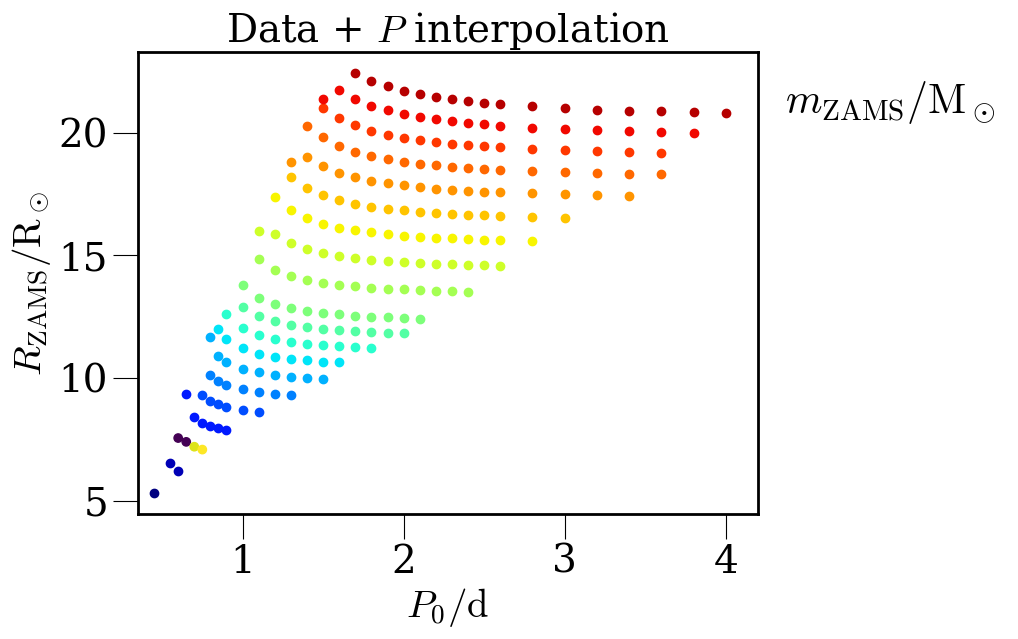

In [186]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator_dict = pzams_rzams_interpolator_dict

for i, m_key in enumerate(mass_guide_str):
    c = cm.jet(i/len(mass_guide_str))
    interpolator = interpolator_dict[m_key]
    plot_ps = np.linspace(0, 2, 1000)
    che_mask = np.array(final_mass_array[:,i,9], bool)
    ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,6][che_mask], marker='o', c=c, zorder=1)
    #ax.scatter(period_guide_float[~che_mask], final_mass_array[:,i,6][~che_mask], marker='x', c=c, zorder=2)
    #ax.plot(plot_ps, interpolator(plot_ps), c=c, label=m_key, zorder=0)
    
#ax.set_ylim(20, 40)
ax.set_xlim(0.35, 4.2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{ZAMS}/\\mathrm{R}_\\odot$')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=2, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_title('Data + $P$ interpolation')

#savefig(fig, 'pzams_rzams_data')

In [166]:
def mzams_rzams_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = pzams_rzams_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    m_core = interpolator(m_zams)
    
    return m_core      

Text(0.5, 1.0, 'Data + $P,m_\\mathrm{ZAMS}$ interpolation')

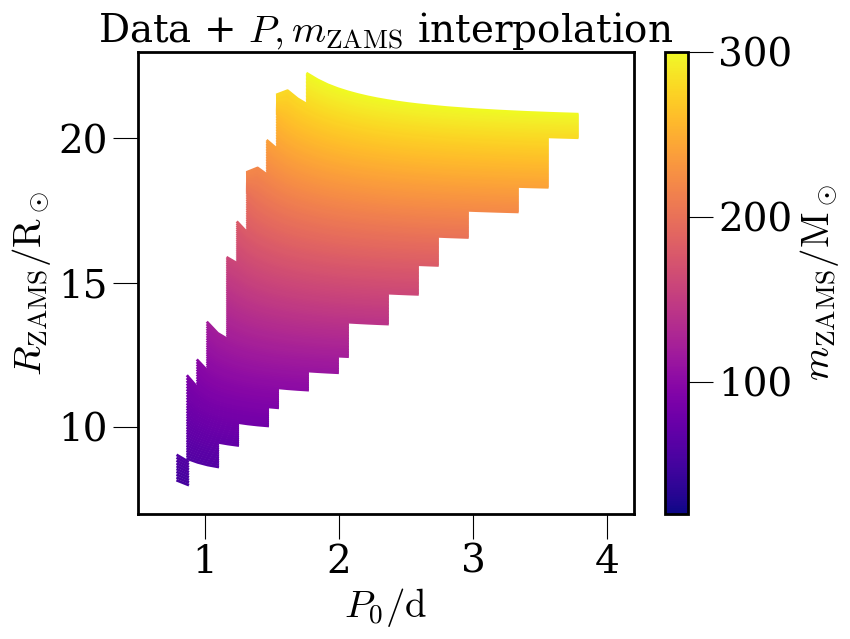

In [193]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator = mzams_rzams_interpolator
cmap = cm.plasma

test_masses = np.linspace(20, 300, 300)
test_periods = np.linspace(0.35, 4)

for i, m in enumerate(test_masses):
    c = cmap(i/len(test_masses))
    m_cores = [interpolator(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.set_ylim(7, 23)
ax.set_xlim(0.5, 4.2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{ZAMS}/\\mathrm{R}_\\odot$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(test_masses), vmax=max(test_masses)), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

ax.set_title('Data + $P,m_\\mathrm{ZAMS}$ interpolation')

#savefig(fig, 'pzams_rzams_ip')

Below we build a pre-ZAMS radius interpolator.

In [197]:
interpolator_dict = dict()

for i, m in enumerate(mass_guide_float):
    m_key = mass_guide_str[i]
    p_arr = period_guide_float   
    y_arr = final_mass_array[:, i, 7] 

    mask = np.array(final_mass_array[:, i, 9], bool)
    y_arr = y_arr[mask]
    p_arr = p_arr[mask]
    
    if len(y_arr) == 0:
        y_arr = [0]
        p_arr = [1]

    interpolator = interp1d(
        x=p_arr,
        y=y_arr,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    interpolator_dict[m_key] = interpolator     
    
pzams_rprezams_interpolator_dict = interpolator_dict

/tmp/ipykernel_457131/1535104987.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,7][che_mask], marker='o', c=c, zorder=1)
/tmp/ipykernel_457131/1535104987.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[~che_mask], final_mass_array[:,i,7][~che_mask], marker='x', c=c, zorder=2)


Text(0.5, 1.0, 'Data + $P$ interpolation')

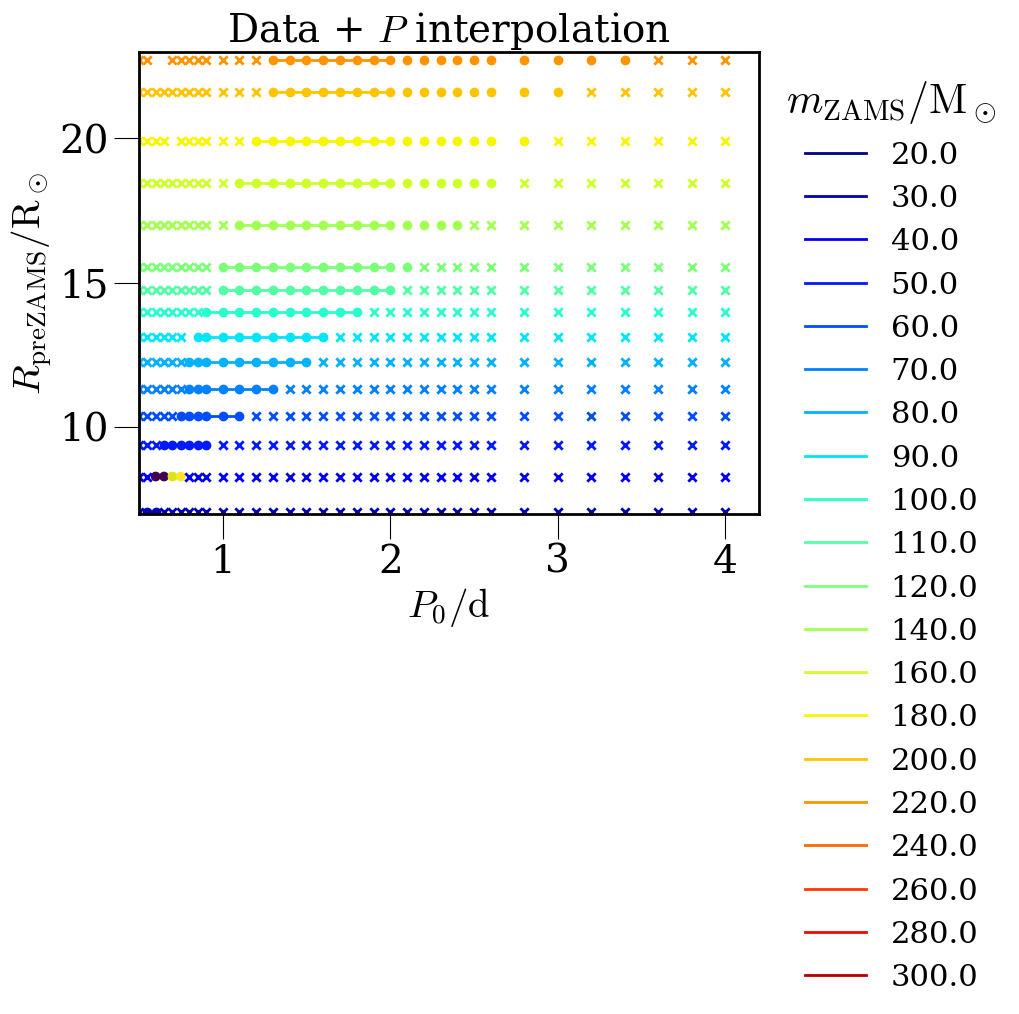

In [198]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator_dict = pzams_rprezams_interpolator_dict

for i, m_key in enumerate(mass_guide_str):
    c = cm.jet(i/len(mass_guide_str))
    interpolator = interpolator_dict[m_key]
    plot_ps = np.linspace(0, 2, 1000)
    che_mask = np.array(final_mass_array[:,i,9], bool)
    ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,7][che_mask], marker='o', c=c, zorder=1)
    ax.scatter(period_guide_float[~che_mask], final_mass_array[:,i,7][~che_mask], marker='x', c=c, zorder=2)
    ax.plot(plot_ps, interpolator(plot_ps), c=c, label=m_key, zorder=0)
    
ax.set_ylim(7, 23)
ax.set_xlim(0.5, 4.2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{preZAMS}/\\mathrm{R}_\\odot$')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_title('Data + $P$ interpolation')

#savefig(fig, 'pzams_rprezams_data')

In [179]:
def mzams_rprezams_interpolator(m_zams, p_zams):
    ip_m_cores = []
    for m_key in mass_guide_str:
        interpolator = pzams_rprezams_interpolator_dict[m_key]
        ip_m_cores.append(interpolator(p_zams))
    
    interpolator = interp1d(
        x=mass_guide_float,
        y=ip_m_cores,
        kind='linear',
        bounds_error=False,
        fill_value=nan
    )
    
    rprezams = interpolator(m_zams)
    
    return rprezams

Text(0.5, 1.0, 'Data + $P,m_\\mathrm{ZAMS}$ interpolation')

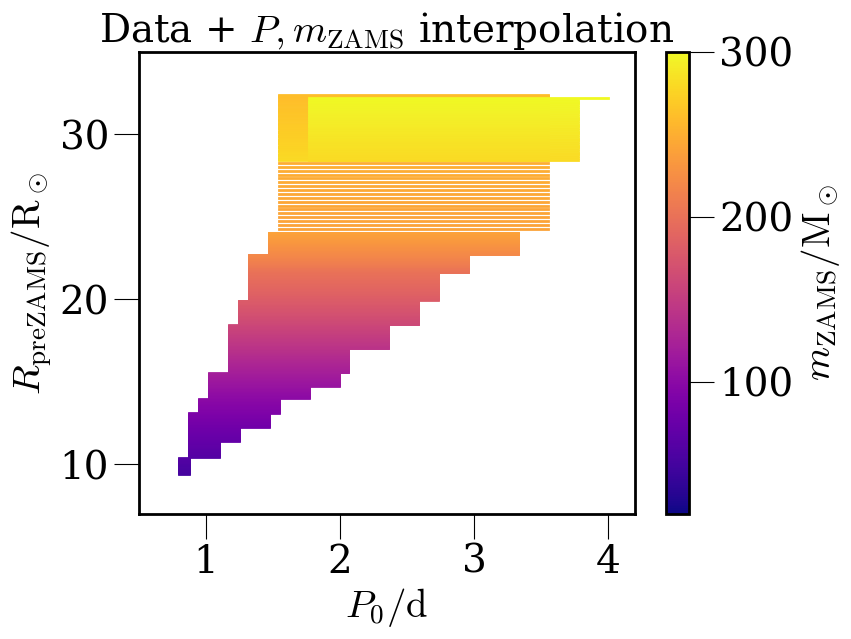

In [204]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator = mzams_rprezams_interpolator
cmap = cm.plasma

test_masses = np.linspace(20, 300, 500)
test_periods = np.linspace(0.35, 4)

for i, m in enumerate(test_masses):
    c = cmap(i/len(test_masses))
    m_cores = [interpolator(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.set_ylim(7, 35)
ax.set_xlim(0.5, 4.2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{preZAMS}/\\mathrm{R}_\\odot$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(test_masses), vmax=max(test_masses)), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

ax.set_title('Data + $P,m_\\mathrm{ZAMS}$ interpolation')

#savefig(fig, 'pzams_rprezams_ip')

Comparing pre-ZAMS and ZAMS radii.

Text(0.5, 1.0, 'Data + $P,m_\\mathrm{ZAMS}$ interpolation')

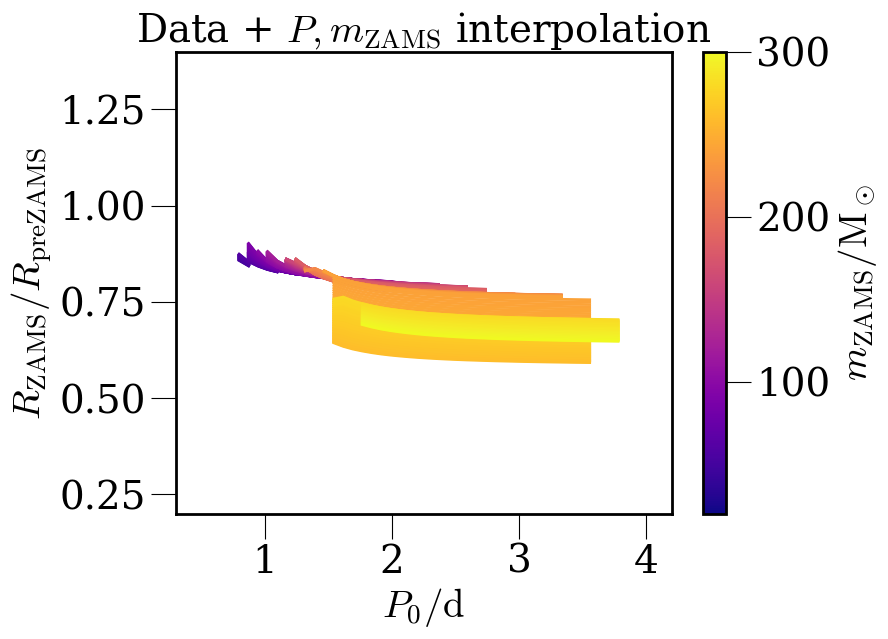

In [207]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator1 = mzams_rzams_interpolator
interpolator2 = mzams_rprezams_interpolator
cmap = cm.plasma

test_masses = np.linspace(20, 300, 500)
test_periods = np.linspace(0.35, 4)

for i, m in enumerate(test_masses):
    c = cmap(i/len(test_masses))
    m_cores = [interpolator1(m, p)/interpolator2(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.set_ylim(0.2, 1.4)
ax.set_xlim(0.3, 4.2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{ZAMS}/R_\\mathrm{preZAMS}$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(test_masses), vmax=max(test_masses)), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

ax.set_title('Data + $P,m_\\mathrm{ZAMS}$ interpolation')

#savefig(fig, 'zams_prezams_radii_ip')

/tmp/ipykernel_457131/1546723372.py:9: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,6][che_mask]/final_mass_array[:,i,7][che_mask], marker='o', c=c, zorder=1)
/tmp/ipykernel_457131/1546723372.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(period_guide_float[~che_mask], final_mass_array[:,i,6][~che_mask]/final_mass_array[:,i,7][~che_mask], marker=

Text(0.5, 1.0, 'Data + $P$ interpolation')

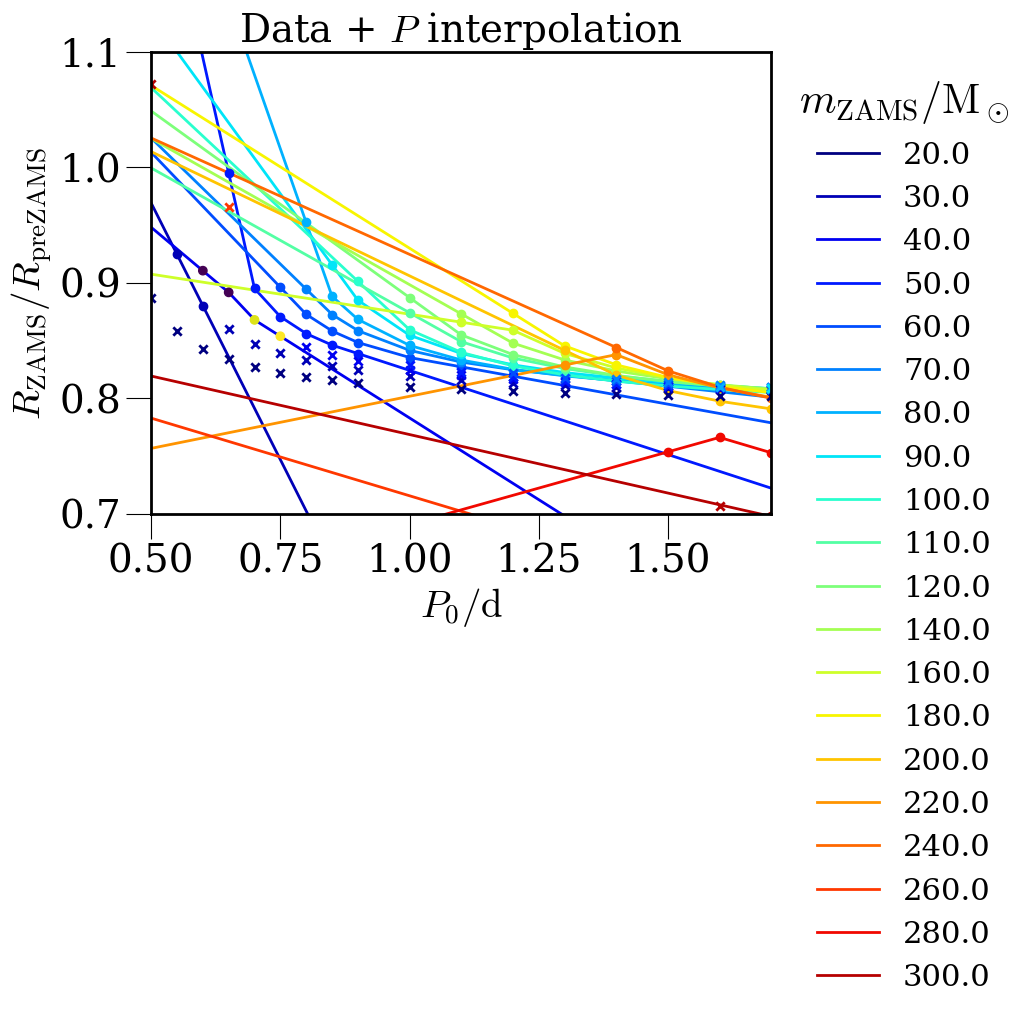

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

for i, m_key in enumerate(mass_guide_str):
    c = cm.jet(i/len(mass_guide_str))
    interpolator1 = pzams_rprezams_interpolator_dict[m_key]
    interpolator2 = pzams_rzams_interpolator_dict[m_key]
    plot_ps = np.linspace(0, 2, 1000)
    che_mask = np.array(final_mass_array[:,i,9], bool)
    ax.scatter(period_guide_float[che_mask], final_mass_array[:,i,6][che_mask]/final_mass_array[:,i,7][che_mask], marker='o', c=c, zorder=1)
    ax.scatter(period_guide_float[~che_mask], final_mass_array[:,i,6][~che_mask]/final_mass_array[:,i,7][~che_mask], marker='x', c=c, zorder=2)
    ax.plot(plot_ps, interpolator2(plot_ps)/interpolator1(plot_ps), c=c, label=m_key, zorder=0)
    
ax.set_ylim(0.7, 1.1)
ax.set_xlim(0.5, 1.7)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$R_\\mathrm{ZAMS}/R_\\mathrm{preZAMS}$')

ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
ax.set_title('Data + $P$ interpolation')

#savefig(fig, 'zams_prezams_radii_data')

We now want to check for overflow.

In [208]:
def is_of(r, m, p, q=1, kind='RL'):
    a = a_from_p(p, m, q)
    if kind == 'merger':
        of_a = a.to(u.Rsun).value
    elif kind == 'RL':
        of_a = eggleton_rl1_radius(a, q).to(u.Rsun).value
    elif kind == 'L2':
        of_a = marchant_l2_radius(a, q).to(u.Rsun).value
    else:
        raise ValueError(f'kind {kind} not recognized')
    if of_a <= r:
        isof = True
    else:
        isof = False

    return isof

In [209]:
test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)[::-1]

of_kind = 'RL'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rzams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    of_i = np.where(test_of)[0][0]
    of_p = test_periods[of_i]
    of_m_core = mzams_mcore_interpolator(m, of_p)
    of_locations[i] = [of_p, of_m_core]
    
zams_rlof_locs = of_locations

In [210]:
test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)[::-1]

of_kind = 'L2'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rzams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    of_i = np.where(test_of)[0][0]
    of_p = test_periods[of_i]
    of_m_core = mzams_mcore_interpolator(m, of_p)
    of_locations[i] = [of_p, of_m_core]
    
zams_l2of_locs = of_locations

In [211]:
test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)[::-1]

of_kind = 'merger'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rzams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    of_i = np.where(test_of)[0][0]
    of_p = test_periods[of_i]
    of_m_core = mzams_mcore_interpolator(m, of_p)
    of_locations[i] = [of_p, of_m_core]
    
zams_merger_locs = of_locations

IndexError: index 0 is out of bounds for axis 0 with size 0

In [96]:
test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)[::-1]

of_kind = 'RL'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rprezams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    of_i = np.where(test_of)[0][0]
    of_p = test_periods[of_i]
    of_m_core = mzams_mcore_interpolator(m, of_p)
    of_locations[i] = [of_p, of_m_core]
    
prezams_rlof_locs = of_locations

In [97]:
test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)[::-1]

of_kind = 'L2'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rprezams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    of_i = np.where(test_of)[0][0]
    of_p = test_periods[of_i]
    of_m_core = mzams_mcore_interpolator(m, of_p)
    of_locations[i] = [of_p, of_m_core]
    
prezams_l2of_locs = of_locations

In [98]:
test_masses = np.linspace(70, 100, 300)
test_periods = np.linspace(0, 2)[::-1]

of_kind = 'merger'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rprezams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    of_i = np.where(test_of)[0][0]
    of_p = test_periods[of_i]
    of_m_core = mzams_mcore_interpolator(m, of_p)
    of_locations[i] = [of_p, of_m_core]
    
prezams_merger_locs = of_locations

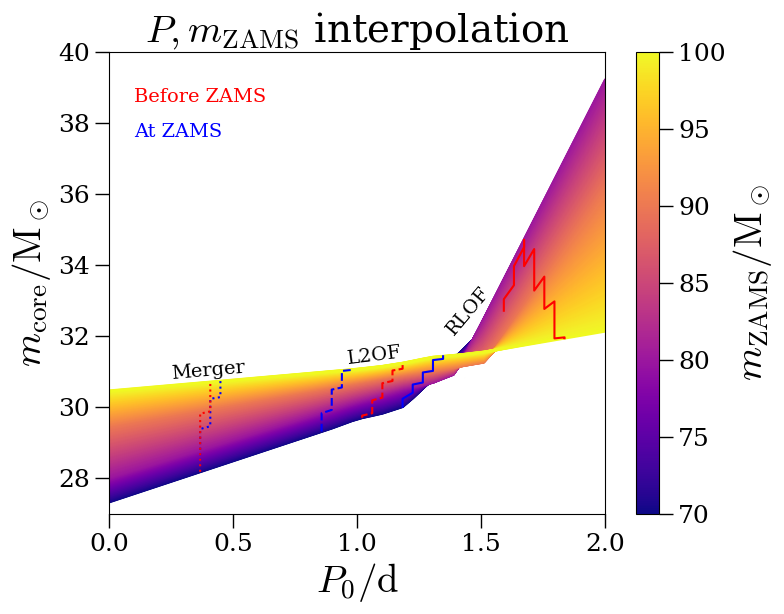

In [99]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator = mzams_mcore_interpolator
cmap = cm.plasma

for i, m in enumerate(test_masses):
    c = cmap(i/len(test_masses))
    m_cores = [interpolator(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.plot(zams_rlof_locs[:, 0], zams_rlof_locs[:, 1], 'b-', lw=1.5)
ax.plot(zams_l2of_locs[:, 0], zams_l2of_locs[:, 1], 'b--', lw=1.5)
ax.plot(zams_merger_locs[:, 0], zams_merger_locs[:, 1], 'b:', lw=1.5)

ax.plot(prezams_rlof_locs[:, 0], prezams_rlof_locs[:, 1], 'r-', lw=1.5)
ax.plot(prezams_l2of_locs[:, 0], prezams_l2of_locs[:, 1], 'r--', lw=1.5)
ax.plot(prezams_merger_locs[:, 0], prezams_merger_locs[:, 1], 'r:', lw=1.5)

ax.text(0.4, 30.7, 'Merger', rotation=5, ha='center', va='bottom', fontsize=14)
ax.text(1.07, 31.1, 'L2OF', rotation=7, ha='center', va='bottom', fontsize=14)
ax.text(1.45, 32.7, 'RLOF', rotation=50, ha='center', va='center', fontsize=14)

ax.text(0.1, 39, 'Before ZAMS', ha='left', va='top', c='r', fontsize=14)
ax.text(0.1, 38, 'At ZAMS', ha='left', va='top', c='b', fontsize=14)

ax.set_ylim(27, 40)
ax.set_xlim(0, 2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(test_masses), vmax=max(test_masses)), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')

ax.set_title('$P,m_\\mathrm{ZAMS}$ interpolation')

savefig(fig, 'partial_che_window_extended')

### Extended P0 x mcore plot

In [254]:
test_masses = np.linspace(20, 300, 300)
test_periods = np.linspace(0, 4, 100)[::-1]

of_kind = 'RL'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    try:
        of_i = np.where(test_of)[0][0]
    except:
        of_locations[i] = [nan, nan]
    else:
        of_p = test_periods[of_i]
        of_m_core = mzams_mcore_interpolator(m, of_p)
        of_locations[i] = [of_p, of_m_core]
    
zams_rlof_locs = of_locations

#

of_kind = 'L2'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rzams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    try:
        of_i = np.where(test_of)[0][0]
    except:
        of_locations[i] = [nan, nan]
    else:
        of_p = test_periods[of_i]
        of_m_core = mzams_mcore_interpolator(m, of_p)
        of_locations[i] = [of_p, of_m_core]
        
zams_l2of_locs = of_locations

#

of_kind = 'merger'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rzams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    try:
        of_i = np.where(test_of)[0][0]
    except:
        of_locations[i] = [nan, nan]
    else:
        of_p = test_periods[of_i]
        of_m_core = mzams_mcore_interpolator(m, of_p)
        of_locations[i] = [of_p, of_m_core]
    
zams_merger_locs = of_locations

#

of_kind = 'RL'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rprezams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    try:
        of_i = np.where(test_of)[0][0]
    except:
        of_locations[i] = [nan, nan]
    else:
        of_p = test_periods[of_i]
        of_m_core = mzams_mcore_interpolator(m, of_p)
        of_locations[i] = [of_p, of_m_core]
    
prezams_rlof_locs = of_locations

#

of_kind = 'L2'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rprezams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    try:
        of_i = np.where(test_of)[0][0]
    except:
        of_locations[i] = [nan, nan]
    else:
        of_p = test_periods[of_i]
        of_m_core = mzams_mcore_interpolator(m, of_p)
        of_locations[i] = [of_p, of_m_core]
        
prezams_l2of_locs = of_locations

#

of_kind = 'merger'
of_locations = np.zeros((len(test_masses), 2))
for i, m in enumerate(test_masses):
    test_of = [is_of(mzams_rprezams_interpolator(m, p), m, p, q=1, kind=of_kind) for p in test_periods]
    try:
        of_i = np.where(test_of)[0][0]
    except:
        of_locations[i] = [nan, nan]
    else:
        of_p = test_periods[of_i]
        of_m_core = mzams_mcore_interpolator(m, of_p)
        of_locations[i] = [of_p, of_m_core]
    
prezams_merger_locs = of_locations

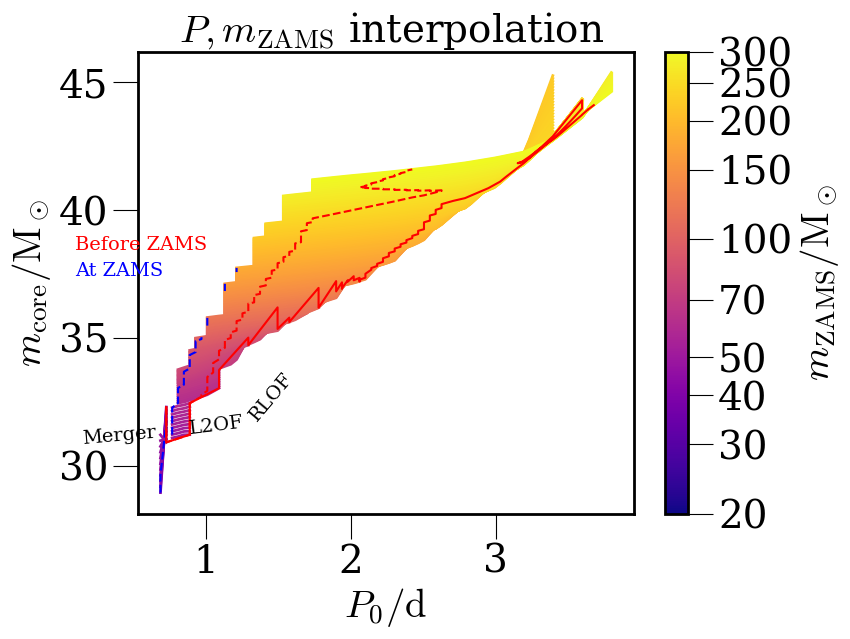

In [255]:
fig, ax = plt.subplots(figsize=(8, 6))
interpolator = mzams_mcore_interpolator
cmap = cm.plasma

for i, m in enumerate(test_masses):
    c = cmap((np.log10(m)-np.log10(20))/(np.log10(300)-np.log10(20)))
    m_cores = [interpolator(m, p) for p in test_periods]
    ax.plot(test_periods, m_cores, c=c, lw=2, label=f'${m:.1f}$')
    
ax.plot(zams_rlof_locs[:, 0], zams_rlof_locs[:, 1], 'b-', lw=1.5)
ax.plot(zams_l2of_locs[:, 0], zams_l2of_locs[:, 1], 'b--', lw=1.5)
ax.plot(zams_merger_locs[:, 0], zams_merger_locs[:, 1], 'b:', lw=1.5)

ax.plot(prezams_rlof_locs[:, 0], prezams_rlof_locs[:, 1], 'r-', lw=1.5)
ax.plot(prezams_l2of_locs[:, 0], prezams_l2of_locs[:, 1], 'r--', lw=1.5)
ax.plot(prezams_merger_locs[:, 0], prezams_merger_locs[:, 1], 'r:', lw=1.5)

ax.text(0.4, 30.7, 'Merger', rotation=5, ha='center', va='bottom', fontsize=14)
ax.text(1.07, 31.1, 'L2OF', rotation=7, ha='center', va='bottom', fontsize=14)
ax.text(1.45, 32.7, 'RLOF', rotation=50, ha='center', va='center', fontsize=14)

ax.text(0.1, 39, 'Before ZAMS', ha='left', va='top', c='r', fontsize=14)
ax.text(0.1, 38, 'At ZAMS', ha='left', va='top', c='b', fontsize=14)

#ax.set_ylim(30, 47)
#ax.set_xlim(0, 4.2)

ax.set_xlabel('$P_0/\\mathrm{d}$')
ax.set_ylabel('$m_\\mathrm{core}/\\mathrm{M}_\\odot$')

#ax.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, title='$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
sm = ScalarMappable(norm=Normalize(vmin=min(np.log10(test_masses)), vmax=max(np.log10(test_masses))), cmap=cmap)
cb = fig.colorbar(mappable=sm, ax=ax)
cb.set_label('$m_\\mathrm{ZAMS}/\\mathrm{M}_\\odot$')
cb.set_ticks(np.log10([20, 30, 40, 50, 70, 100, 150, 200, 250, 300]))
cb.set_ticklabels([20, 30, 40, 50, 70, 100, 150, 200, 250, 300])

ax.set_title(' $P,m_\\mathrm{ZAMS}$ interpolation')

savefig(fig, 'full_che_window_extended')

# Mixing timescale

# Core mass distribution

In [290]:
res = int(1e6)
min_m = 20
max_m = 300
min_p = 0.1
max_p = 4

sample_masses = np.linspace(min_m, max_m, res)
sample_probs = sample_masses**-2.3/np.sum(sample_masses**-2.3)
sample_masses = np.random.choice(sample_masses, p=sample_probs, size=int(res/100))

sample_periods = np.linspace(np.log10(min_p), np.log10(max_p), res)
sample_probs = np.ones(res)/res
sample_periods = 10.**np.random.choice(sample_periods, p=sample_probs, size=int(res/100))

sample_prezams_rs = np.array([mzams_rprezams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])
sample_zams_rs = np.array([mzams_rzams_interpolator(m, p) for m, p in zip(sample_masses, sample_periods)])

sample_mcores = np.zeros(int(res/100))

sample_ = np.array([sample_masses, sample_periods, sample_prezams_rs, sample_zams_rs, sample_mcores]).T

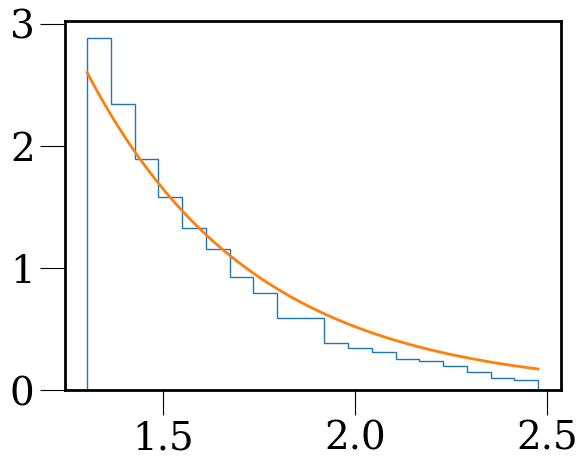

In [293]:
plt.stairs(*np.histogram(np.log10(sample_masses), density=True, bins=np.linspace(np.log10(min_m), np.log10(max_m), 20)))
plt.plot(np.linspace(np.log10(min_m), np.log10(max_m), 100), 0.13*np.logspace(np.log10(min_m), np.log10(max_m)**-2.3, 100))

(array([ 977.,  981., 1016.,  945., 1042., 1011., 1050.,  990.,  979.,
        1009.]),
 array([-0.99998078, -0.8397799 , -0.67957903, -0.51937816, -0.35917729,
        -0.19897641, -0.03877554,  0.12142533,  0.28162621,  0.44182708,
         0.60202795]),
 <BarContainer object of 10 artists>)

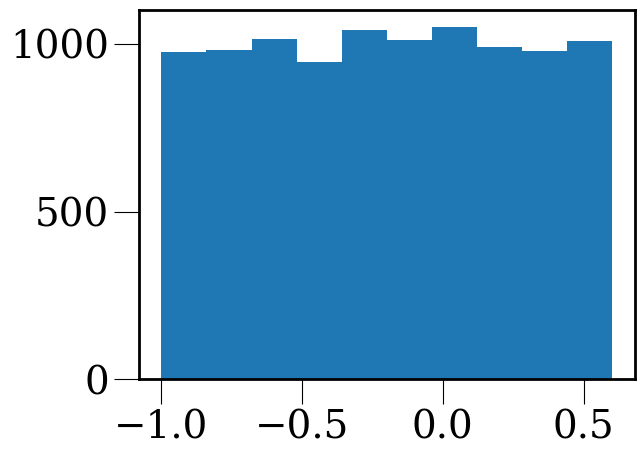

In [292]:
plt.hist(np.log10(sample_periods))

In [294]:
def set_mcores(sample, of_kind='none', of_when='zams'):
    for i, star in enumerate(sample):
        if of_when == 'zams':
            r = star[3]
        elif of_when == 'prezams':
            r = star[2]
        else:
            raise ValueError(f'Value {of_when} not valid for arg of_when')
        
        if of_kind == 'none':
            mcore = mzams_mcore_interpolator(star[0], star[1])
        else:
            try:
                isof = is_of(r=r, m=star[0], p=star[1], q=1, kind=of_kind)            
            except ValueError:
                raise ValueError(f'Value {of_kind} not valid for arg of_kind')
            else:
                if isof:
                    mcore = nan
                else:
                    mcore = mzams_mcore_interpolator(star[0], star[1])
                
        sample[i, 4] = mcore
    return sample

In [295]:
full_sample = set_mcores(sample_, of_kind='none').copy()

zams_rlof_sample = set_mcores(sample_, of_kind='RL', of_when='zams').copy()
zams_l2of_sample = set_mcores(sample_, of_kind='L2', of_when='zams').copy()
zams_merger_sample = set_mcores(sample_, of_kind='merger', of_when='zams').copy()

prezams_rlof_sample = set_mcores(sample_, of_kind='RL', of_when='prezams').copy()
prezams_l2of_sample = set_mcores(sample_, of_kind='L2', of_when='prezams').copy()
prezams_merger_sample = set_mcores(sample_, of_kind='merger', of_when='prezams').copy()

In [296]:
prezams_rlof_sample[:, 4]

array([nan, nan, nan, ..., nan, nan, nan])

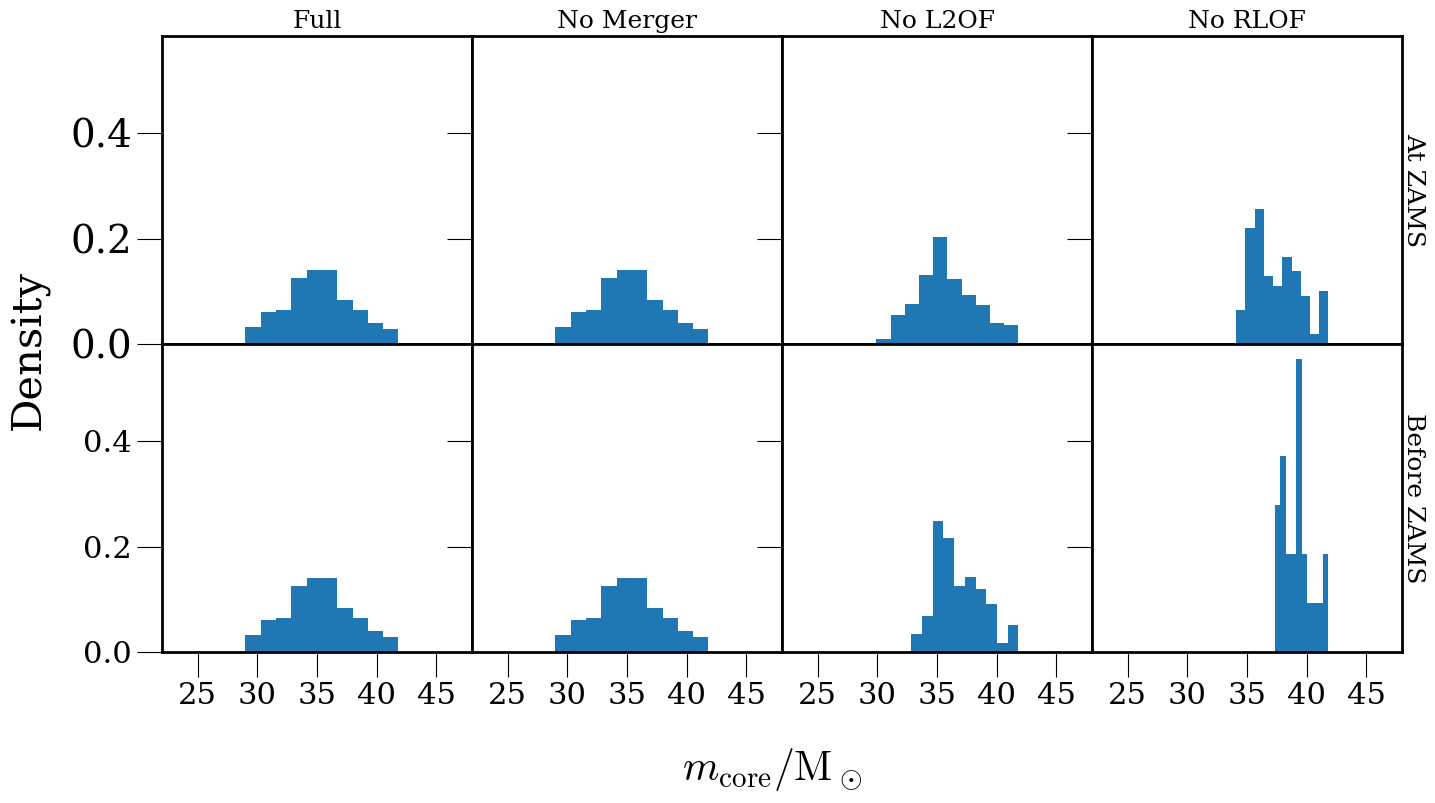

In [305]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0, hspace=0)

# AT ZAMS ROW
# Full
axes[0, 0].hist(full_sample[:, 4], density=True)
axes[0, 0].set_title('Full', fontsize=18)

# No Merger
axes[0, 1].hist(zams_merger_sample[:, 4], density=True)
axes[0, 1].set_title('No Merger', fontsize=18)

# No L2OF
axes[0, 2].hist(zams_l2of_sample[:, 4], density=True)
axes[0, 2].set_title('No L2OF', fontsize=18)

# No RLOF
axes[0, 3].hist(zams_rlof_sample[:, 4], density=True)
axes[0, 3].text(1, 0.5, 'At ZAMS', rotation=-90, ha='left', va='center', transform=axes[0, 3].transAxes, fontsize=18)
axes[0, 3].set_title('No RLOF', fontsize=18)


# BEFORE ZAMS ROW
# Full
axes[1, 0].hist(full_sample[:, 4], density=True)

# No Merger
axes[1, 1].hist(prezams_merger_sample[:, 4], density=True)

# No L2OF
axes[1, 2].hist(prezams_l2of_sample[:, 4], density=True)

# No RLOF
axes[1, 3].hist(prezams_rlof_sample[:, 4], density=True)
axes[1, 3].text(1, 0.5, 'Before ZAMS', rotation=-90, ha='left', va='center', transform=axes[1, 3].transAxes, fontsize=18)

fig.text(0.45, -0.05, '$m_\\mathrm{core}/\\mathrm{M}_\\odot$', transform=fig.transFigure)
fig.text(0.03, 0.4, 'Density', rotation=90, transform=fig.transFigure)

for ax in axes[1,:]:
    ax.set_xticks(np.arange(25, 50, 5))
    ax.set_xlim(22, 48)
    ax.tick_params(labelsize=22)
    
savefig(fig, 'mcore_distributions_extended')

In [ ]:
import pickle as pkl
np.save('26mcore_sample.npy', sample_)
with open('26mzams_mcore_interpolator.pkl', 'wb') as f:
    pkl.dump(mzams_mcore_interpolator, f)

In [ ]:
np.save('full_sample26.npy', full_sample)

np.save('zams_rlof_sample26.npy', zams_rlof_sample)
np.save('zams_l2of_sample26.npy', zams_l2of_sample)
np.save('zams_merger_sample26.npy', zams_l2of_sample)

np.save('prezams_rlof_sample26.npy', prezams_rlof_sample)
np.save('prezams_l2of_sample26.npy', prezams_l2of_sample)
np.save('prezams_merger_sample26.npy', prezams_merger_sample)